In [13]:
from pathlib import Path
from dataclasses import dataclass
from typing import Tuple, NamedTuple, Optional, List
import pandas as pd
from typing import List, Tuple
import json
import numpy as np
from cyvcf2 import VCF
import matplotlib.pyplot as plt
import seaborn as sns
FIGSIZE = (13, 8)
DPI = 200
plt.style.use("ggplot")

PRECISION_KEY = "Precision_edit_dist"
RECALL_KEY = "Recall_edit_dist"
BETA = 0.25  # recall is beta times as important as precision
MAX_COVG = 0

In [2]:
def f1_score(precision: float, recall: float) -> float:
    return f_score(precision, recall, beta=1.0)

def f_score(precision: float, recall: float, beta: float = 1.0) -> float:
    """A more general F score, F beta, that uses a positive real factor beta, 
    where beta is chosen such that recall is considered beta times as 
    important as precision.
    Setting to 1 gives the f1 score
    Taken from https://en.wikipedia.org/wiki/F-score
    """
    b2 = beta**2
    return (1 + b2) * ((precision * recall) / ((b2 * precision) + recall))


columns = ["sample", "tool", "judge", "precision", "recall", "FN", "FP", "f1", "fbeta"]


def extract_results(directory: str, include_varifier: bool=False) -> pd.DataFrame:
    result_files = list(Path(directory).rglob("*summary.csv"))
    if include_varifier:
        result_files.extend(list(Path(directory).rglob("*.json")))
    
    data = []
    for p in result_files:
        sample = p.parts[1]
        tool = p.parts[0]
        if tool.startswith("bcftools-"):
            tool = tool.replace("bcftools-", "")
        judge = p.parts[2]
        if judge == "varifier":
            if not include_varifier:
                continue
            precision = float(d["Precision"][PRECISION_KEY])
            recall = float(d["Recall"][RECALL_KEY])
            fns = int(d["Recall"]["FN"]["Count"])
            fps = int(d["Precision"]["FP"]["Count"])
            f1 = f1_score(precision, recall)
            fbeta = f_score(precision, recall, BETA)
            data.append((sample, tool, judge, precision, recall, fns, fps, f1, fbeta))
        elif judge == "happy":
            d = pd.read_csv(p).query("Type=='SNP' and Filter=='PASS'").to_dict(orient="records")[0]
            precision = float(d["METRIC.Precision"])
            recall = float(d["METRIC.Recall"])
            fns = int(d["TRUTH.FN"])
            fps = int(d["QUERY.FP"])
            f1 = d["METRIC.F1_Score"]
            fbeta = f_score(precision, recall, BETA)
            data.append((sample, tool, judge, precision, recall, fns, fps, f1, fbeta)) 
            
    return pd.DataFrame(data, columns=columns)

In [3]:
include_varifier = False
dfs = []
dfs.append(extract_results("compass", include_varifier=include_varifier))
dfs.extend([extract_results(d, include_varifier=include_varifier) for d in Path().glob("bcftools*")])
df = pd.concat(dfs)

In [4]:
df.groupby(["tool", "judge"])["FP"].sum()

tool              judge
compass           happy     33
q85               happy     88
q85K90            happy     60
q85K90x20         happy     53
q85K90x20s1       happy     53
q85K90x20s1V1e-5  happy     50
unfiltered        happy    360
Name: FP, dtype: int64

In [5]:
df.groupby(["tool", "judge"])["FN"].sum()

tool              judge
compass           happy    585
q85               happy    503
q85K90            happy    727
q85K90x20         happy    755
q85K90x20s1       happy    757
q85K90x20s1V1e-5  happy    762
unfiltered        happy    315
Name: FN, dtype: int64

In [6]:
df.groupby(["tool", "judge"]).describe()[["precision", "recall"]]

precision                                          \
                           count      mean       std       min       25%   
tool             judge                                                     
compass          happy       7.0  0.995369  0.002265  0.991416  0.994348   
q85              happy       7.0  0.988735  0.004848  0.980932  0.986129   
q85K90           happy       7.0  0.992220  0.003413  0.987041  0.989920   
q85K90x20        happy       7.0  0.992974  0.003709  0.987041  0.990994   
q85K90x20s1      happy       7.0  0.992973  0.003708  0.987041  0.990994   
q85K90x20s1V1e-5 happy       7.0  0.993504  0.003892  0.987041  0.990991   
unfiltered       happy       7.0  0.953330  0.027853  0.916546  0.933909   

                                                     recall            \
                             50%       75%       max  count      mean   
tool             judge                                                  
compass          happy  0.995704  0.996962  0.997845    7.0  0.925440   
q85              happy  0.989038  0.991648  0.995616    7.0  0.939208   
q85K90           happy  0.992509  0.994834  0.996483    7.0  0.916705   
q85K90x20        happy  0.992500  0.995870  0.997549    7.0  0.912984   
q85K90x20s1      happy  0.992500  0.995868  0.997549    7.0  0.912832   
q85K90x20s1V1e-5 happy  0.995249  0.996353  0.997547    7.0  0.912189   
unfiltered       happy  0.954593  0.973554  0.987241    7.0  0.961871   

                                                                          \
                             std       min       25%       50%       75%   
tool             judge                                                     
compass          happy  0.063720  0.840129  0.876158  0.918699  0.985615   
q85              happy  0.047712  0.872180  0.907307  0.934549  0.977363   
q85K90           happy  0.051313  0.853921  0.885686  0.905218  0.946971   
q85K90x20        happy  0.052233  0.852846  0.882545  0.902439  0.939283   
q85K90x20s1      happy  0.052265  0.852846  0.882545  0.902439  0.938751   
q85K90x20s1V1e-5 happy  0.052444  0.851772  0.881472  0.901700  0.938751   
unfiltered       happy  0.035225  0.911923  0.933601  0.969957  0.992277   

                                  
                             max  
tool             judge            
compass          happy  0.995704  
q85              happy  0.998389  
q85K90           happy  0.992481  
q85K90x20        happy  0.991944  
q85K90x20s1      happy  0.991944  
q85K90x20s1V1e-5 happy  0.991407  
unfiltered       happy  0.999463

Text(0, 0.5, 'recall/sensitivity/TPR')

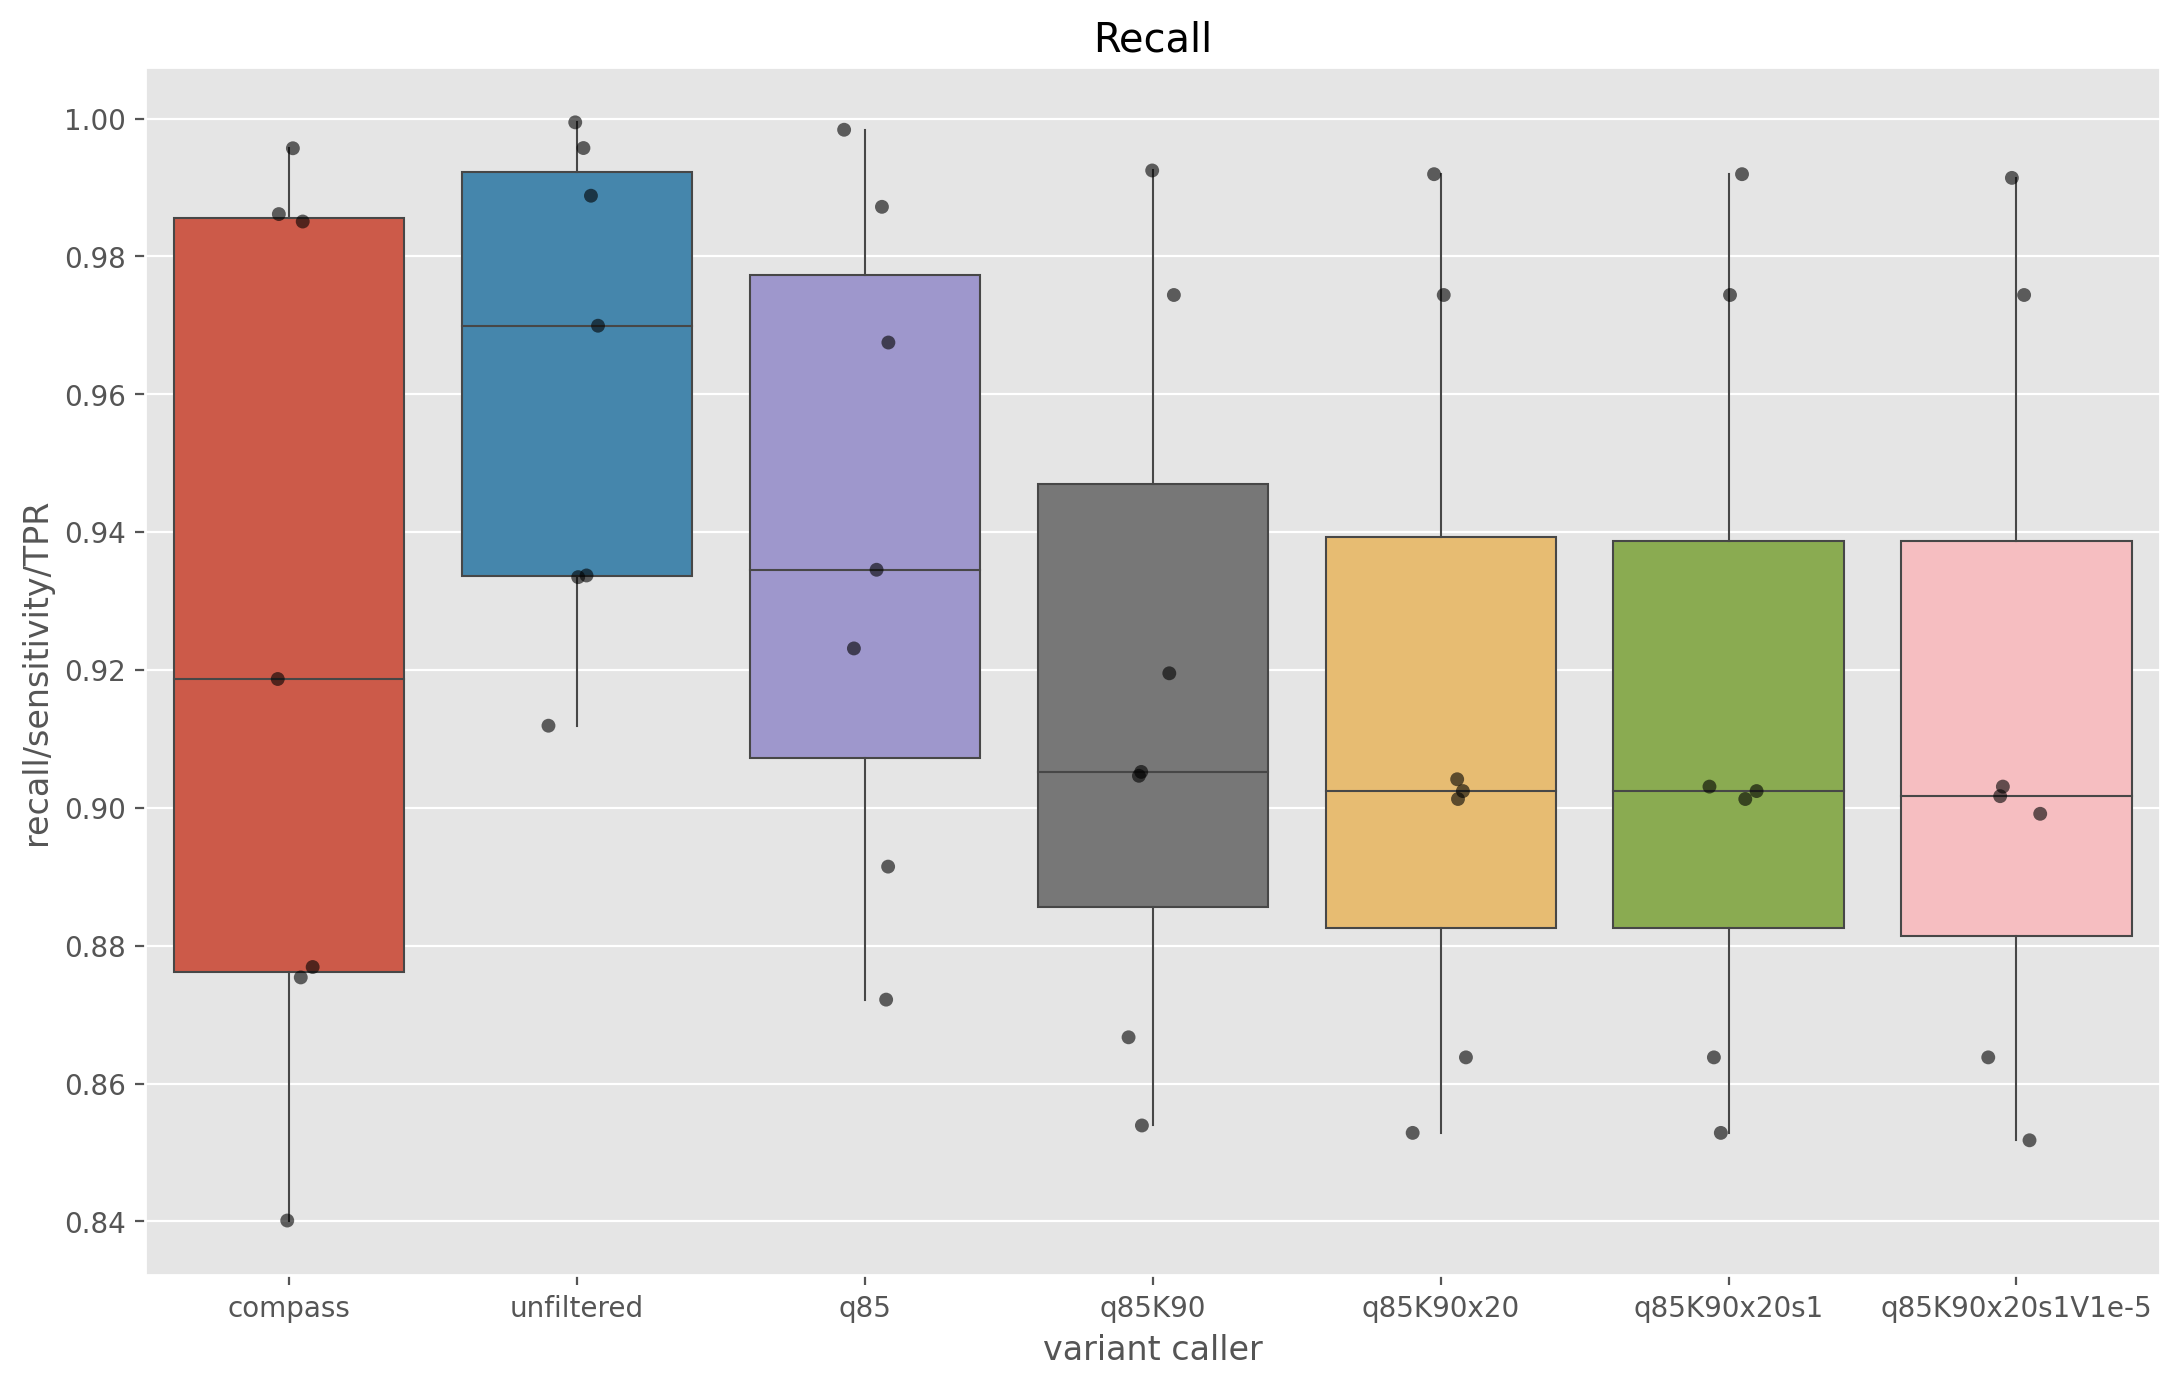

In [7]:
boxprops = dict(linewidth=0.75, fliersize=0, showcaps=False)
stripprops = dict(dodge=True, color="black", alpha=0.6)

x = "tool"
y = "recall"
# hue = "tool"
fixed_labels = ["compass", "unfiltered"]
order = [*fixed_labels, *[label for label in sorted(df[x].unique()) if label not in fixed_labels]]
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
sns.boxplot(x=x, y=y, data=df, ax=ax, order=order, **boxprops)
sns.stripplot(x=x, y=y, data=df, ax=ax, order=order, **stripprops)
ax.set(title=y.capitalize(), xlabel="variant caller")
ax.set_ylabel("recall/sensitivity/TPR")
# ax.set_xticklabels(["COMPASS", "bcftools-ONT", "pandora-ONT"])
# ax.set(ylim=(0.70, 0.95))
# _ = plt.xticks(rotation=90)
# plt.legend(loc='lower left')
# leghandles, leglabels = ax.get_legend_handles_labels()
# ax.legend(leghandles[:2], leglabels[:2], loc="best", prop={"size": 11}, title="Caller")
# ax.get_legend().remove()
# fig.savefig(snakemake.output.recall_plot)

Text(0, 0.5, 'precision/PPV')

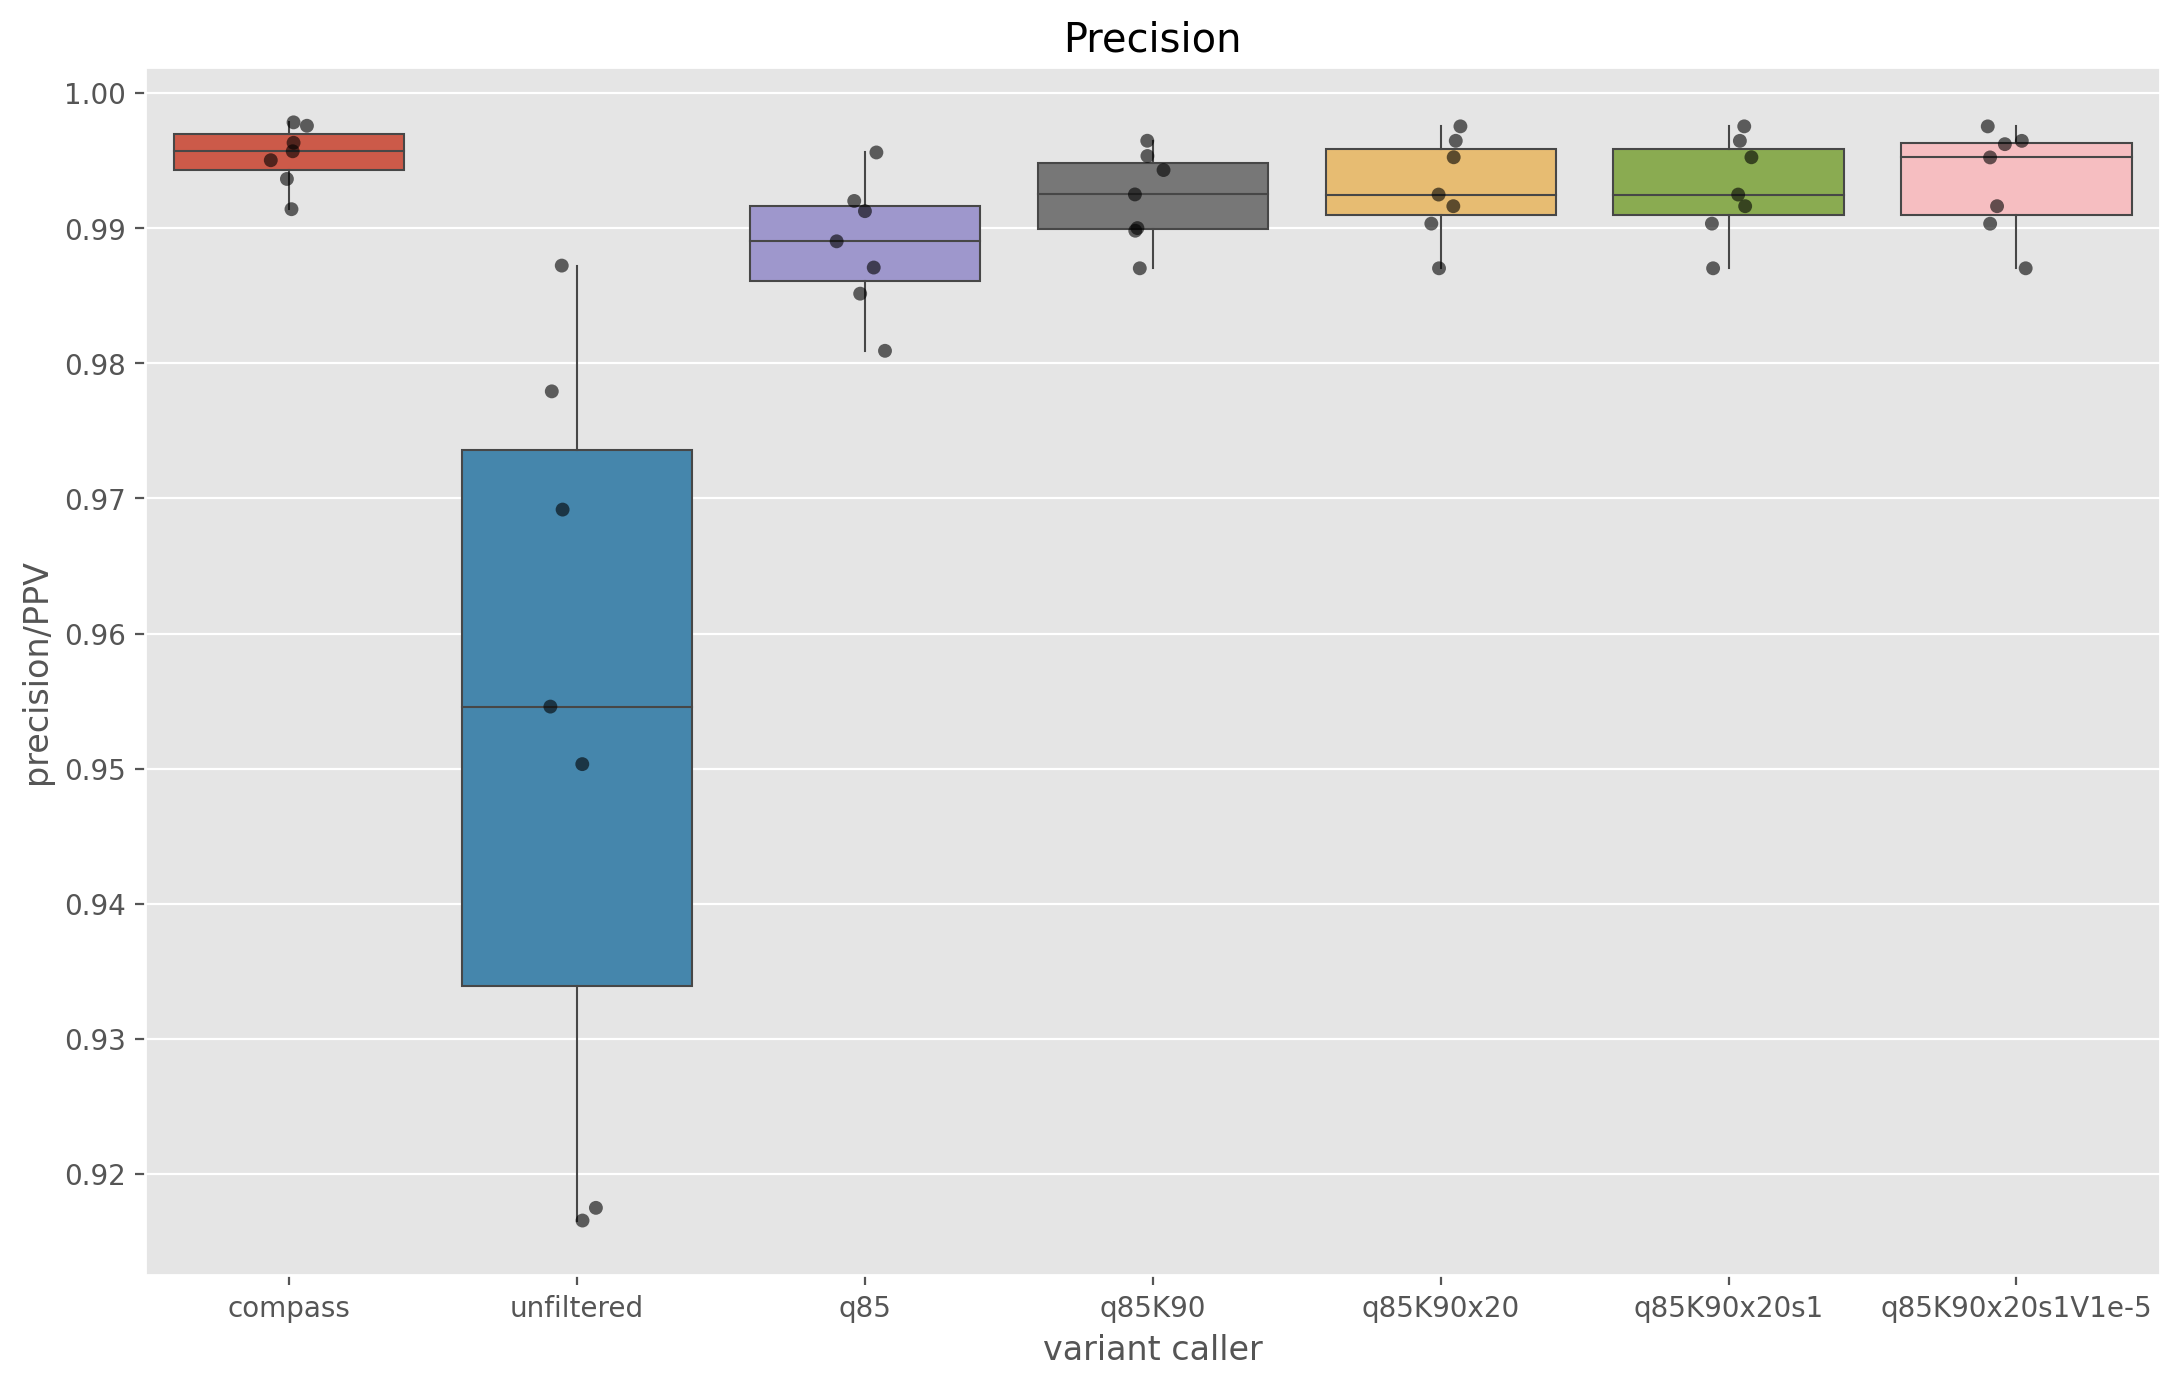

In [8]:
y = "precision"
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
sns.boxplot(x=x, y=y, data=df, ax=ax, order=order, **boxprops)
sns.stripplot(x=x, y=y, data=df, ax=ax, order=order, **stripprops)
ax.set(title=y.capitalize(), xlabel="variant caller")
ax.set_ylabel("precision/PPV")
# ax.set_xticklabels(["COMPASS", "bcftools-ONT", "pandora-ONT"])
# ax.set(ylim=(0.995, 1.001))
# _ = plt.xticks(rotation=90)
# leghandles, leglabels = ax.get_legend_handles_labels()
# ax.legend(leghandles[:2], leglabels[:2], loc="best", prop={"size": 11}, title="Caller")
# plt.legend(loc='lower left')
# fig.savefig(snakemake.output.recall_plot)

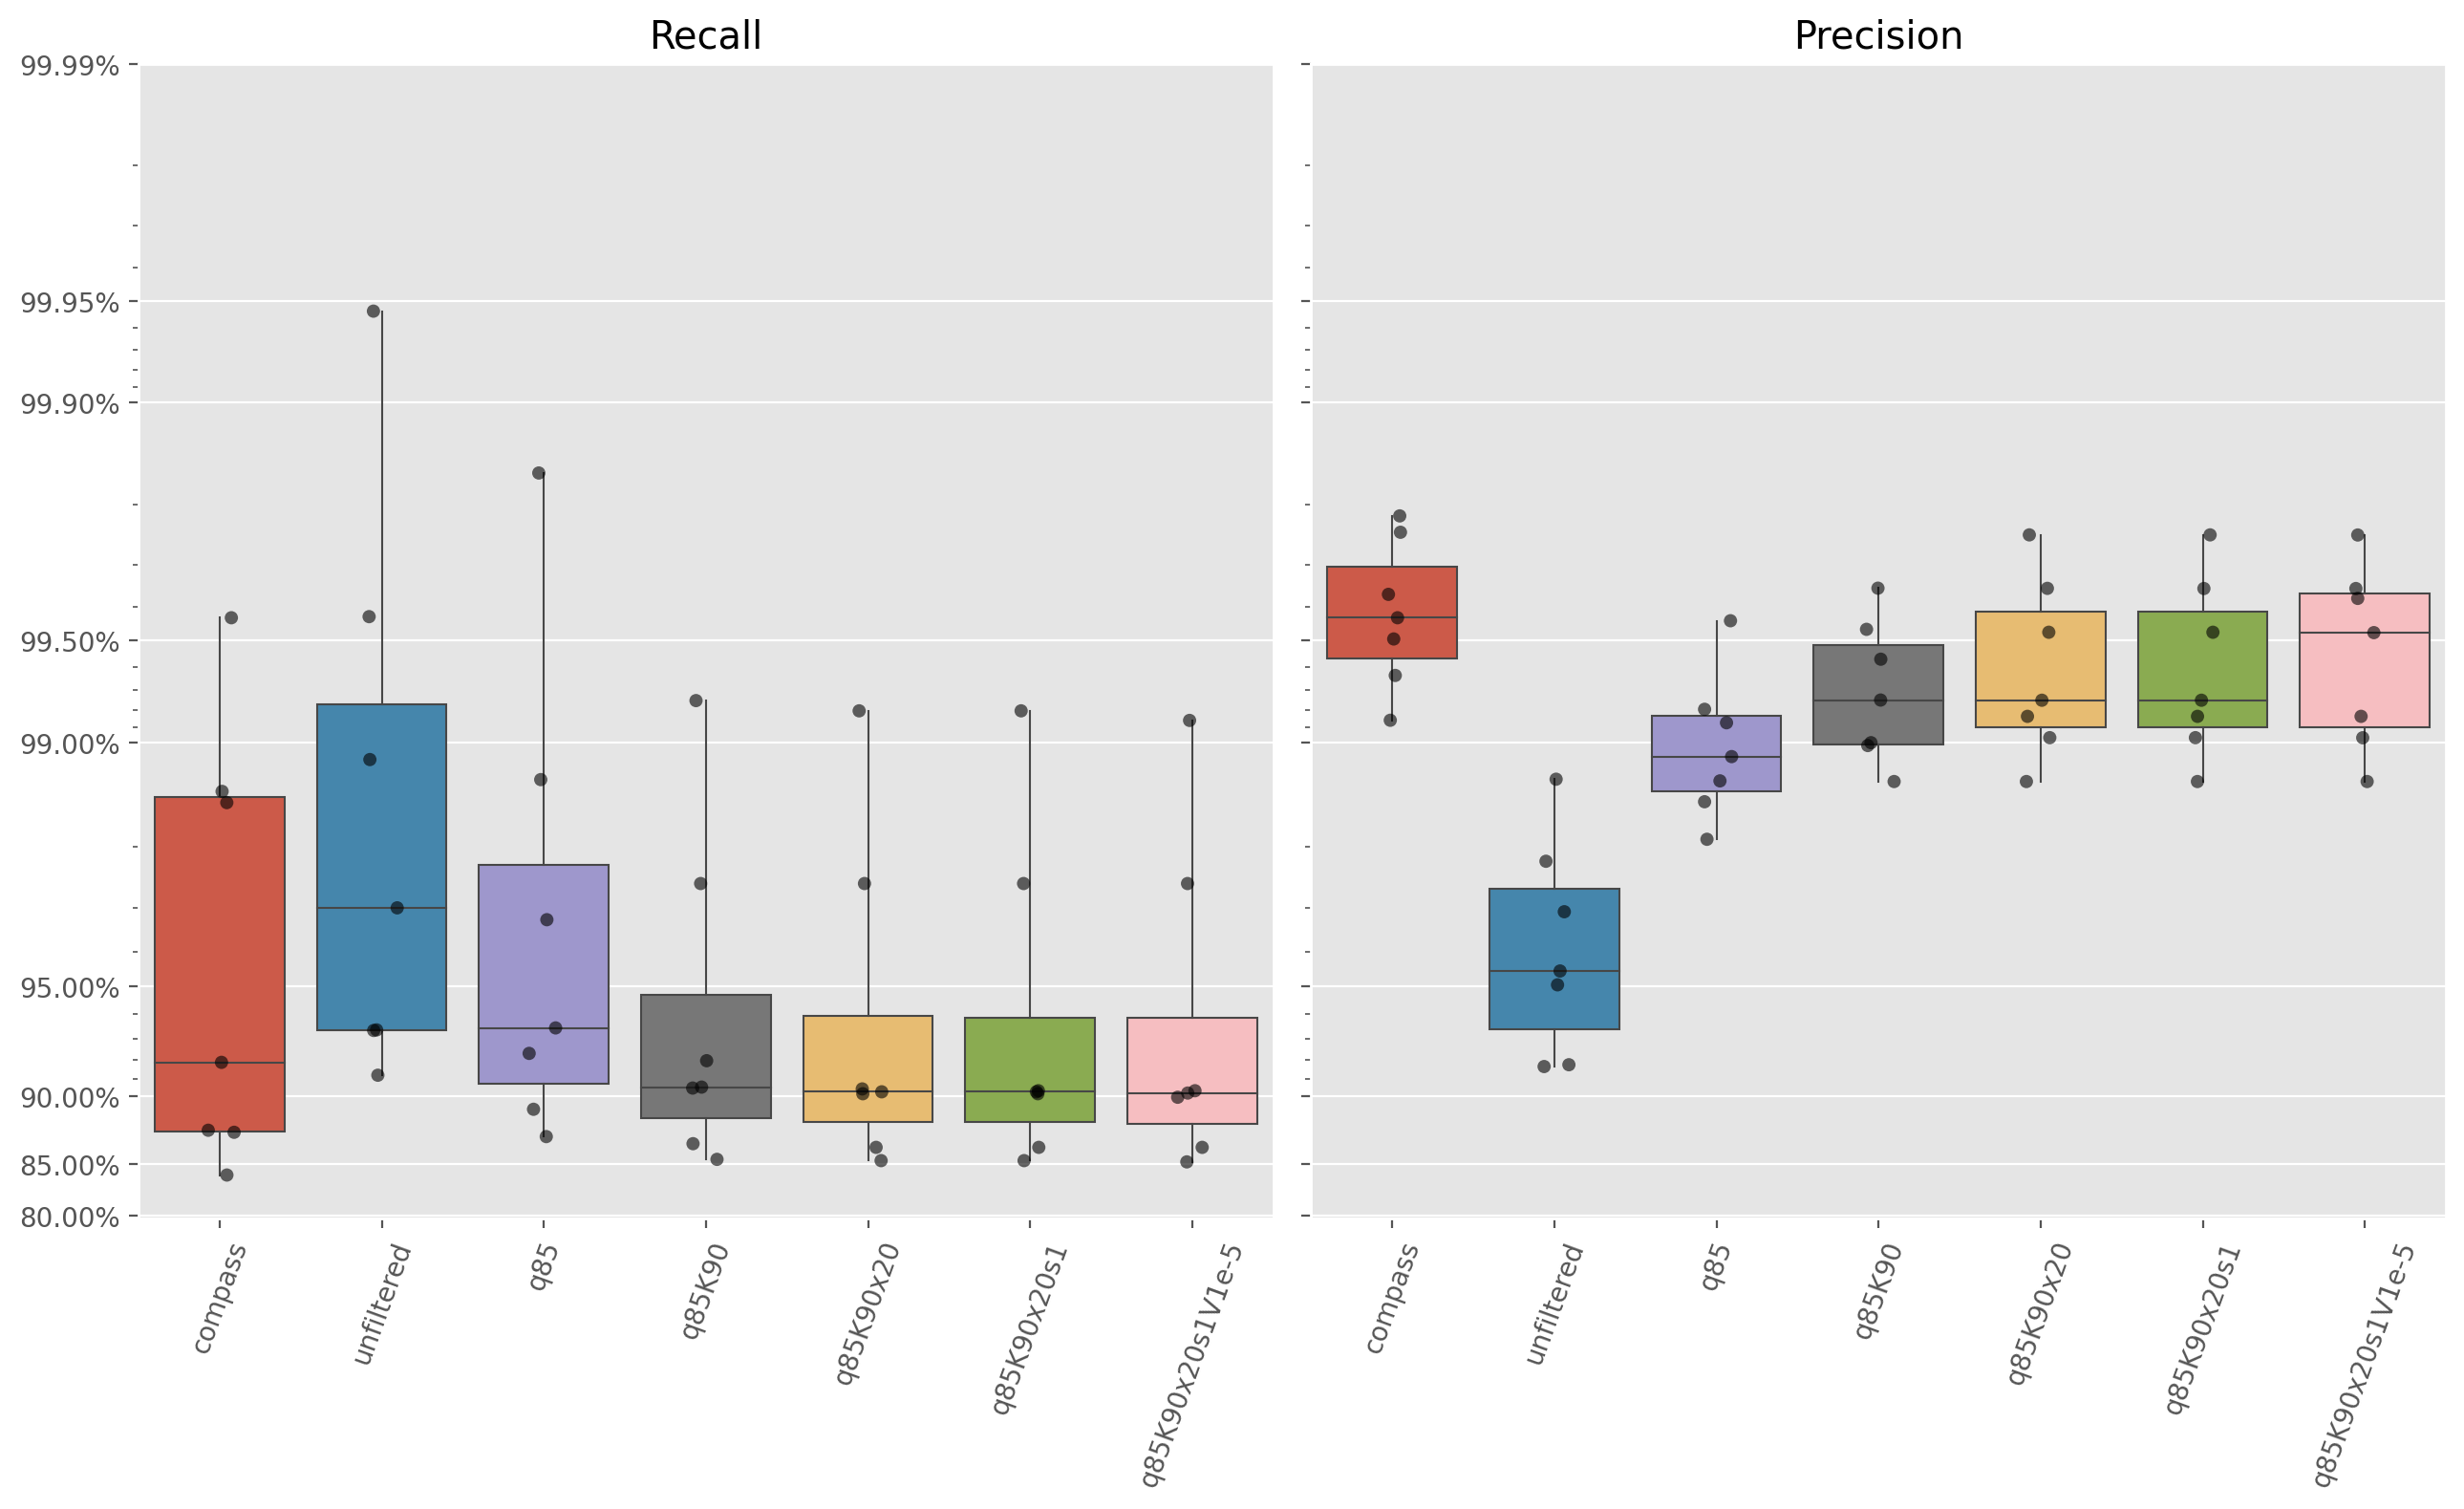

In [9]:
from matplotlib.ticker import PercentFormatter
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI, sharey=True, sharex=True)
for ax, y in zip(axes.flatten(), ["recall", "precision"]):
    sns.boxplot(x=x, y=y, data=df, ax=ax, order=order, **boxprops)
    sns.stripplot(x=x, y=y, data=df, ax=ax, order=order, **stripprops)
    ax.set(title=y.capitalize(), xlabel="", ylabel="")
    ax.set_xlabel("")
#     leghandles, leglabels = ax.get_legend_handles_labels()
#     ax.legend(leghandles[:2], leglabels[:2], loc="best", prop={"size": 11}, title="Caller")
#     if y == "precision":
#         ax.set_ylim(ymin=0.98)
    ax.tick_params("x", labelrotation=70)
    ax.set_yscale("logit")
    ylabs = [0.80, 0.85, 0.9, 0.95, 0.99, 0.995, 0.999, 0.9995, 0.9999]
    ax.set_yticks(ylabs)
    ax.set_yticklabels(ylabs)
#     ax.set_xticklabels(["COMPASS", "#nofilter", "QUAL", "+RPB+VDB+SGB", "+FRS"])
    # plt.legend(loc='lower left')
    # fig.savefig(snakemake.output.recall_plot)
# ax.get_legend().remove()
axes.flatten()[0].yaxis.set_major_formatter(PercentFormatter(1.0, decimals=2))
fig.tight_layout()
# plt.xlabel("variant caller", x=0, ha="center")

In [10]:
from matplotlib.container import BarContainer

Text(0, 0.5, 'Count')

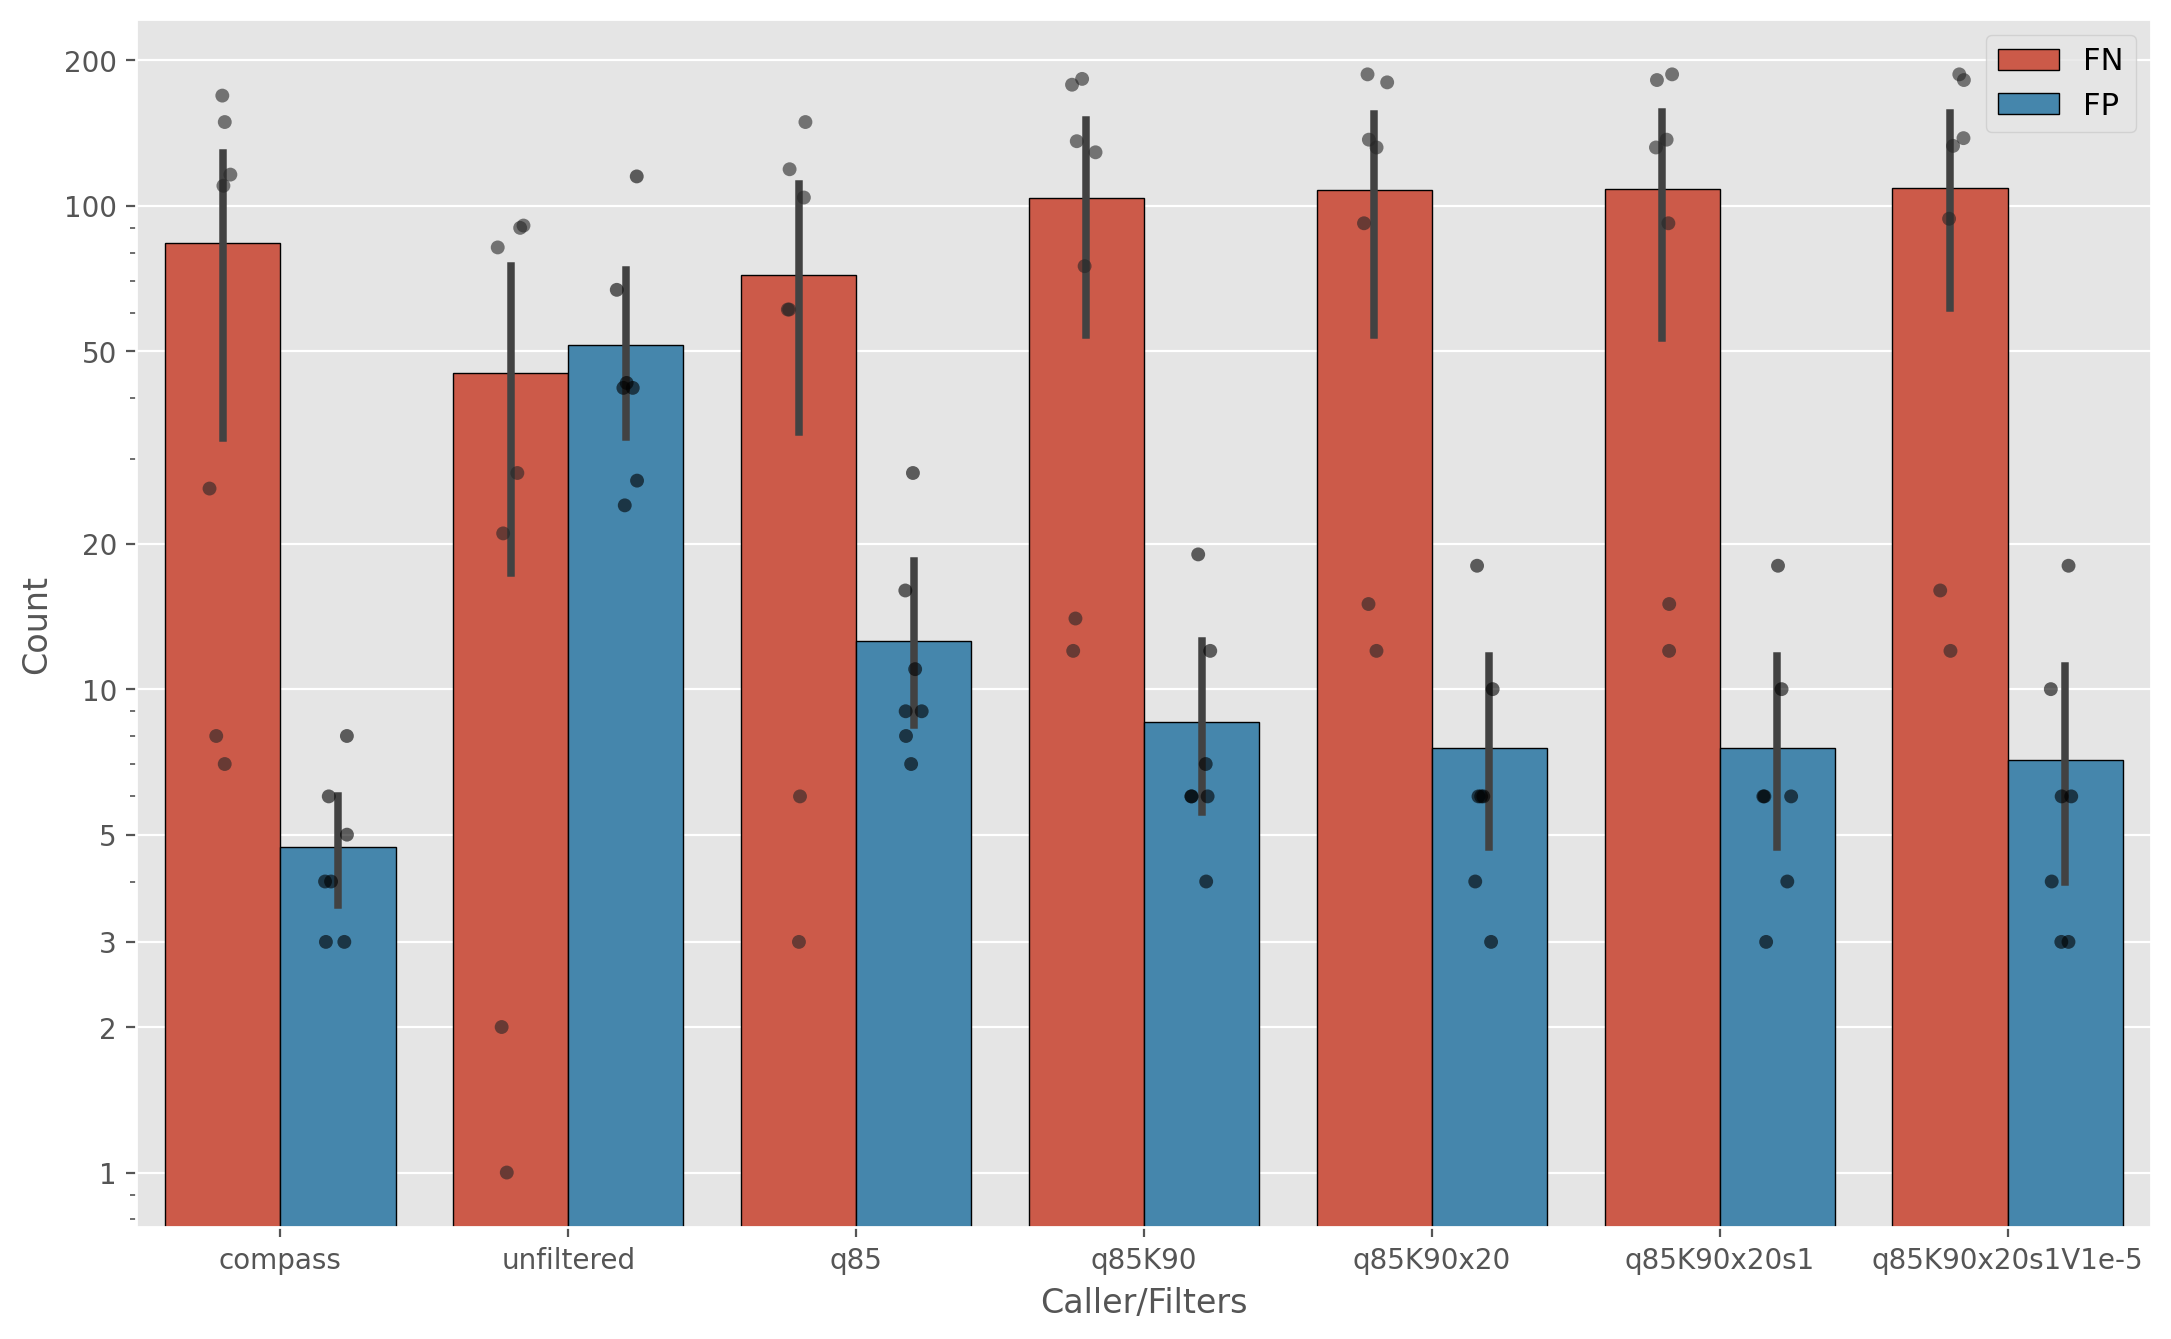

In [11]:
d = df.melt(id_vars=["sample", "tool", "judge"]).query("variable in ('FP', 'FN')")
x = "tool"
y = "value"
hue = "variable"
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
sns.barplot(x=x, y=y, data=d, ax=ax, hue=hue, edgecolor="black", order=order)
sns.stripplot(x=x, y=y, data=d, ax=ax, hue=hue, order=order, **stripprops)
ax.set_yscale("log")
ylabs = [1, 2, 3, 5, 10, 20, 50, 100, 200]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
leghandles, leglabels = ax.get_legend_handles_labels()
new_handles = []
new_labels = []
for i in range(len(leghandles)):
    h = leghandles[i]
    if type(h) == BarContainer:
        new_handles.append(h)
        new_labels.append(leglabels[i])
ax.legend(new_handles, new_labels, loc="best", prop={"size": 11})
ax.set_xlabel("Caller/Filters")
ax.set_ylabel("Count")

In [134]:
df.nlargest(5, columns=["precision"])

,sample,tool,judge,precision,recall,false_negs,fps,f1,fbeta
3,mada_104,compass,happy,0.997845,0.986155,26,4,0.991966,0.997150
5,mada_125,compass,happy,0.997592,0.918699,110,3,0.956522,0.992578
5,mada_125,q85K90x20s1,happy,0.997549,0.902439,132,3,0.947614,0.991403
5,mada_125,q85K90x20,happy,0.997549,0.902439,132,3,0.947614,0.991403
3,mada_104,q70K90V1e-8,happy,0.996495,0.908413,172,6,0.950418,0.990844


In [135]:
df.nlargest(5, columns=["recall"])

,sample,tool,judge,precision,recall,false_negs,fps,f1,fbeta
1,mada_1-44,unfiltered,happy,0.977930,0.999463,1,42,0.988579,0.979171
1,mada_1-44,q85,happy,0.985162,0.998389,3,28,0.991731,0.985930
1,mada_1-44,K80s1q60x15,happy,0.987248,0.997852,4,24,0.992521,0.987866
4,mada_132,unfiltered,happy,0.917485,0.995736,2,42,0.955010,0.921746
1,mada_1-44,compass,happy,0.995704,0.995704,8,8,0.995704,0.995704


In [14]:
class Genotype(NamedTuple):
    allele1: int
    allele2: int

    def is_null(self) -> bool:
        """Is the genotype null. i.e. ./."""
        return self.allele1 == -1 and self.allele2 == -1

    def is_hom(self) -> bool:
        """Is the genotype homozygous"""
        if self.is_null():
            return False
        if self.allele1 == -1 or self.allele2 == -1:
            return True
        return self.allele1 == self.allele2

    def is_het(self) -> bool:
        """Is the genotype heterozyhous"""
        return not self.is_null() and not self.is_hom()

    def is_hom_ref(self) -> bool:
        """Is genotype homozygous reference?"""
        return self.is_hom() and (self.allele1 == 0 or self.allele2 == 0)

    def is_hom_alt(self) -> bool:
        """Is genotype homozygous alternate?"""
        return self.is_hom() and (self.allele1 > 0 or self.allele2 > 0)

    def alt_index(self) -> Optional[int]:
        """If the genotype is homozygous alternate, returns the 0-based index of the
        alt allele in the alternate allele array.
        """
        if not self.is_hom_alt():
            return None
        return max(self.allele1, self.allele2) - 1

    def allele_index(self) -> Optional[int]:
        """The index of the called allele"""
        if self.is_hom_ref() or self.is_null():
            return 0
        elif self.is_hom_alt():
            return self.alt_index() + 1
        else:
            raise NotImplementedError(f"Het Genotype is unexpected: {self}")

    @staticmethod
    def from_arr(arr: List[int]) -> "Genotype":
        alleles = [a for a in arr if type(a) is int]
        if len(alleles) < 2:
            alleles.append(-1)
        return Genotype(*alleles)

@dataclass
class StrandDepths:
    ref_forward: int = 0
    ref_reverse: int = 0
    alt_forward: int = 0
    alt_reverse: int = 0

    @staticmethod
    def _ratio(depths: Tuple[int, int]) -> float:
        try:
            return min(depths) / sum(depths)
        except ZeroDivisionError:
            return 0.5

    @property
    def ref_depths(self) -> Tuple[int, int]:
        return self.ref_forward, self.ref_reverse

    @property
    def alt_depths(self) -> Tuple[int, int]:
        return self.alt_forward, self.alt_reverse

    @property
    def ref_ratio(self) -> float:
        return self._ratio(self.ref_depths)

    @property
    def alt_ratio(self) -> float:
        return self._ratio(self.alt_depths)

    def to_tuple(self) -> Tuple[int, int, int, int]:
        return self.ref_forward, self.ref_reverse, self.alt_forward, self.alt_reverse

def fraction_read_support(variant) -> float:
    strand_depths = get_strand_depths(variant)
    if strand_depths is None:
        return 1.0
    total_covg = sum(strand_depths.to_tuple())
    called_idx = Genotype.from_arr(variant.genotypes[0]).allele_index()
    if called_idx == 0:  # ref
        called_covg = sum(strand_depths.ref_depths)
    else:
        called_covg = sum(strand_depths.alt_depths)
    try:
        return called_covg / total_covg
    except ZeroDivisionError:
        return 1.0
    
def fraction_expected_depth(variant, expected_depth) -> Tuple[float, float]:
    fed = variant.INFO["DP"] / expected_depth
    strand_depths = get_strand_depths(variant)
    i = Genotype.from_arr(variant.genotypes[0]).allele_index()
    if i == 0:
        hqdp = sum(strand_depths.ref_depths)
    else:
        hqdp = sum(strand_depths.alt_depths)
    return fed, hqdp/expected_depth
    
    
    
    
def get_strand_depths(
    variant, default = None
) -> StrandDepths:
    strand_depths = variant.INFO.get("DP4", None)
    return StrandDepths(*strand_depths) if strand_depths is not None else default

def strand_bias(variant) -> float:
        strand_depths = get_strand_depths(variant)
        assert strand_depths is not None, (
            f"Strand bias filter should be turned off if no DP4 "
            f"tag is present."
        )

        gt = Genotype.from_arr(variant.genotypes[0])
        if gt.is_hom_alt():
            ratio = strand_depths.alt_ratio
        elif gt.is_hom_ref():
            ratio = strand_depths.ref_ratio
        elif gt.is_het():
            ratio = min(strand_depths.ref_ratio, strand_depths.alt_ratio)
        elif gt.is_null():
            ratio = 0.5
        else:
            raise NotImplementedError(
                f"Don't know how to interpret genotype {gt} for variant at "
                f"POS {variant.POS}"
            )
        return ratio

In [15]:
clf_vcfs = sorted(Path("bcftools-q85K90x20s1V1e-5/").rglob("*.bcf"))
query_vcfs = sorted(Path("vcfs/bcftools/unfiltered/").rglob("*.bcf"))

In [16]:
info = ["BQBZ", "DP", "FS", "MQ", "MQ0F", "RPBZ", "SCBZ", "SGB", "VDB", "MQBZ"]

In [18]:
# median_covgs = {}
# for p in query_vcfs:
#     sample = p.name.split(".")[0]
#     dps = []
#     for v in VCF(p):
#         dp = v.INFO["DP"]
#         if dp is None:
#             continue
#         dps.append(dp)
#     median_covgs[sample] = np.median(dps)

In [19]:
median_covgs

{'mada_1-44': 131.0,
 'mada_102': 147.0,
 'mada_104': 37.0,
 'mada_116': 80.0,
 'mada_125': 68.0,
 'mada_130': 46.0,
 'mada_132': 30.0}

In [46]:
data = []
index_cols = ["sample", "pos"]
columns = [*index_cols, "classification", "quality", "FRS", "HQDP", "DR", "SB", "SP", "FED", "HQFED", "SCR", "SCRF"]
info = ["MQSBZ", "MQ", "VDB", "RPBZ", "SCBZ", "BQBZ", "SGB", "DP"]
columns.extend(info)
for p, qp in zip(clf_vcfs, query_vcfs):
    sample = p.parts[-3]
    qvcf = VCF(qp)
    for v in VCF(p):
        vtypes = v.format("BVT")
        ref_is_indel = vtypes[0] == "INDEL"
        if ref_is_indel:
            continue
        results = set([r for r in v.format("BD") if r != "."])
        assert len(results) == 1
        clfn = list(results)[0]
        
        qv = next(qvcf(f"{v.CHROM}:{v.POS}-{v.POS}"))
        assert qv.POS == v.POS
        
        d = [sample, v.POS, clfn, qv.QUAL]
        
        d.append(fraction_read_support(qv))

        hqdp = sum(qv.INFO["DP4"])
        d.append(hqdp)
        
        try:
            depth_ratio = hqdp / qv.INFO["DP"]
        except ZeroDivisionError:
            depth_ratio = None
        d.append(depth_ratio)
        
        sb = strand_bias(qv)
        sp = qv.format("SP")[0][0]
        d.extend([sb, sp])
        
        ed = median_covgs[sample]
        fed, hqfed = fraction_expected_depth(qv, ed)
        d.extend([fed, hqfed])
        
        scr = qv.INFO.get("SCR", 0)
        try:
            scr_frac = scr / hqdp
        except ZeroDivisionError:
            scr_frac = None
        d.extend([scr, scr_frac])
        
        for k in info:
            d.append(qv.INFO.get(k))
            
        data.append(tuple(d))

In [47]:
df = pd.DataFrame(data, columns=columns)

In [48]:
filter_out_fn = True
if filter_out_fn:
    df = df.query("classification!='FN'")

In [145]:
print(len(df.query("quality<100 and classification=='TP'")))
print(len(df.query("quality<100 and classification=='FP'")))

25
0


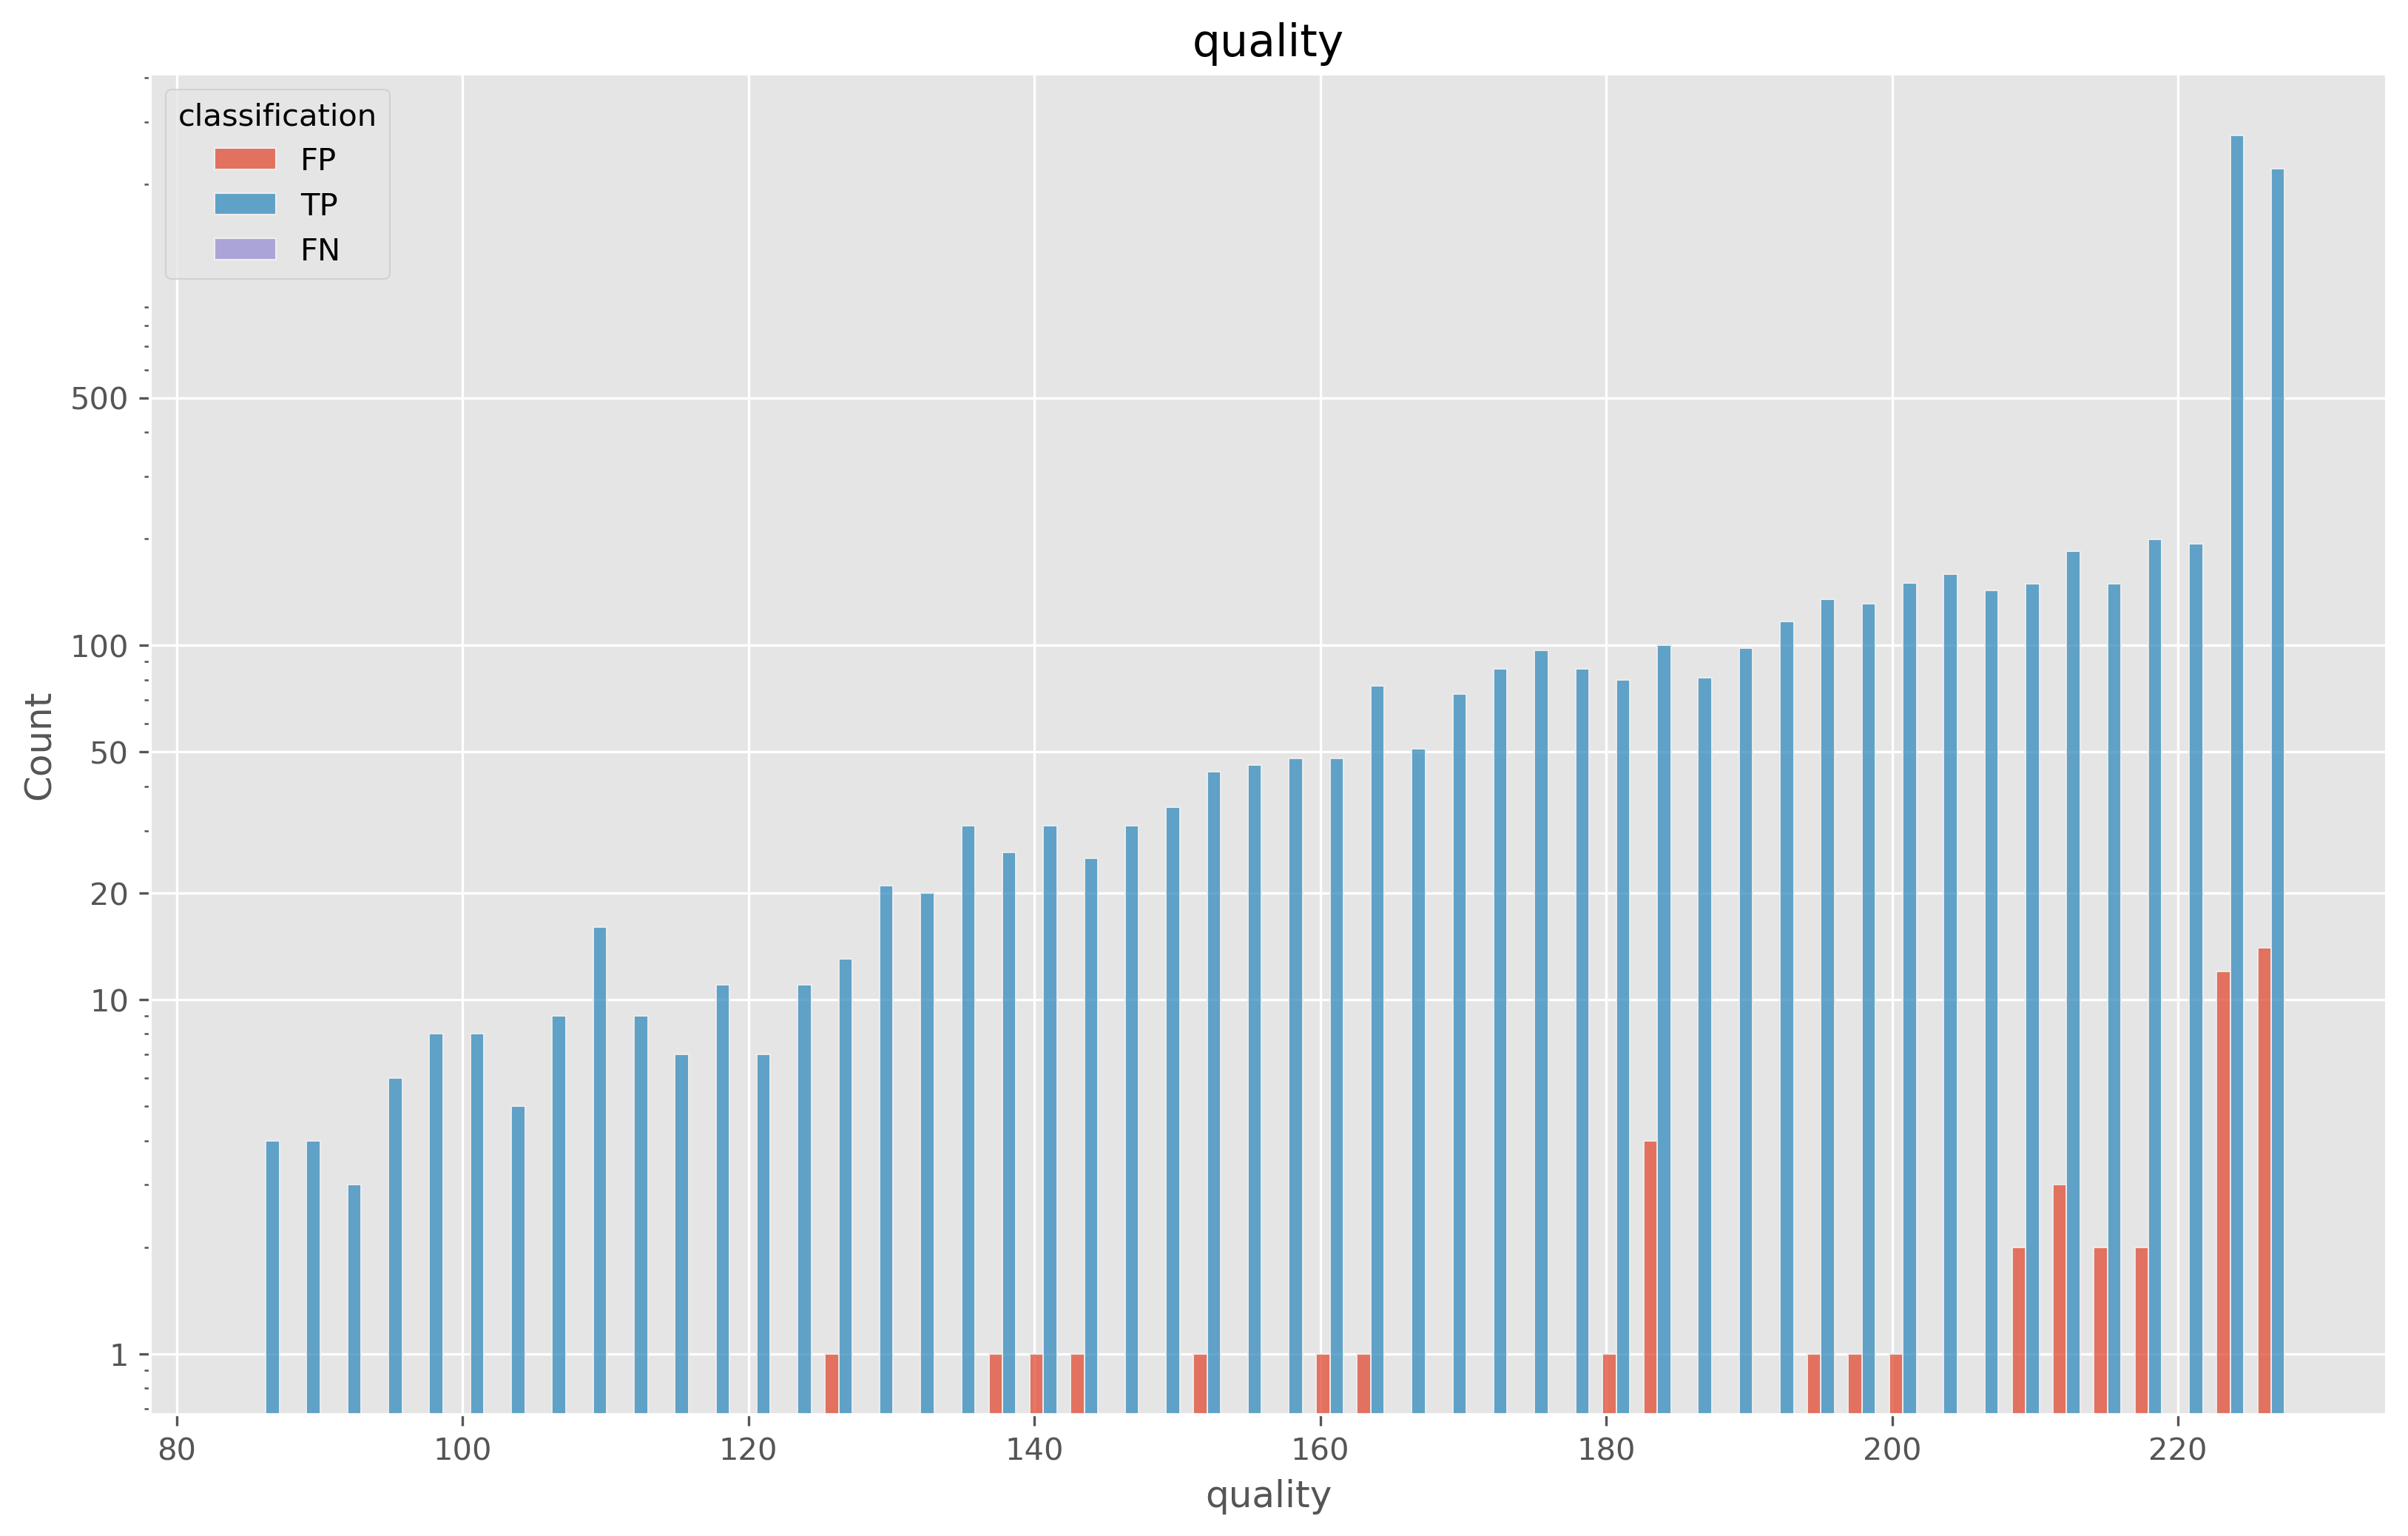

In [23]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "quality"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# xlabs = [60, 65, 70, 75, 80, 85, 90, 95, 100]
# ax.set_xticks(xlabs)
# ax.set_xticklabels(xlabs)
# ax.set_xlim((0, 110))
_=ax.set_title(x)

In [147]:
print(len(df.query("FRS<0.85 and classification=='TP'")))
print(len(df.query("FRS<0.85 and classification=='FP'")))

0
0


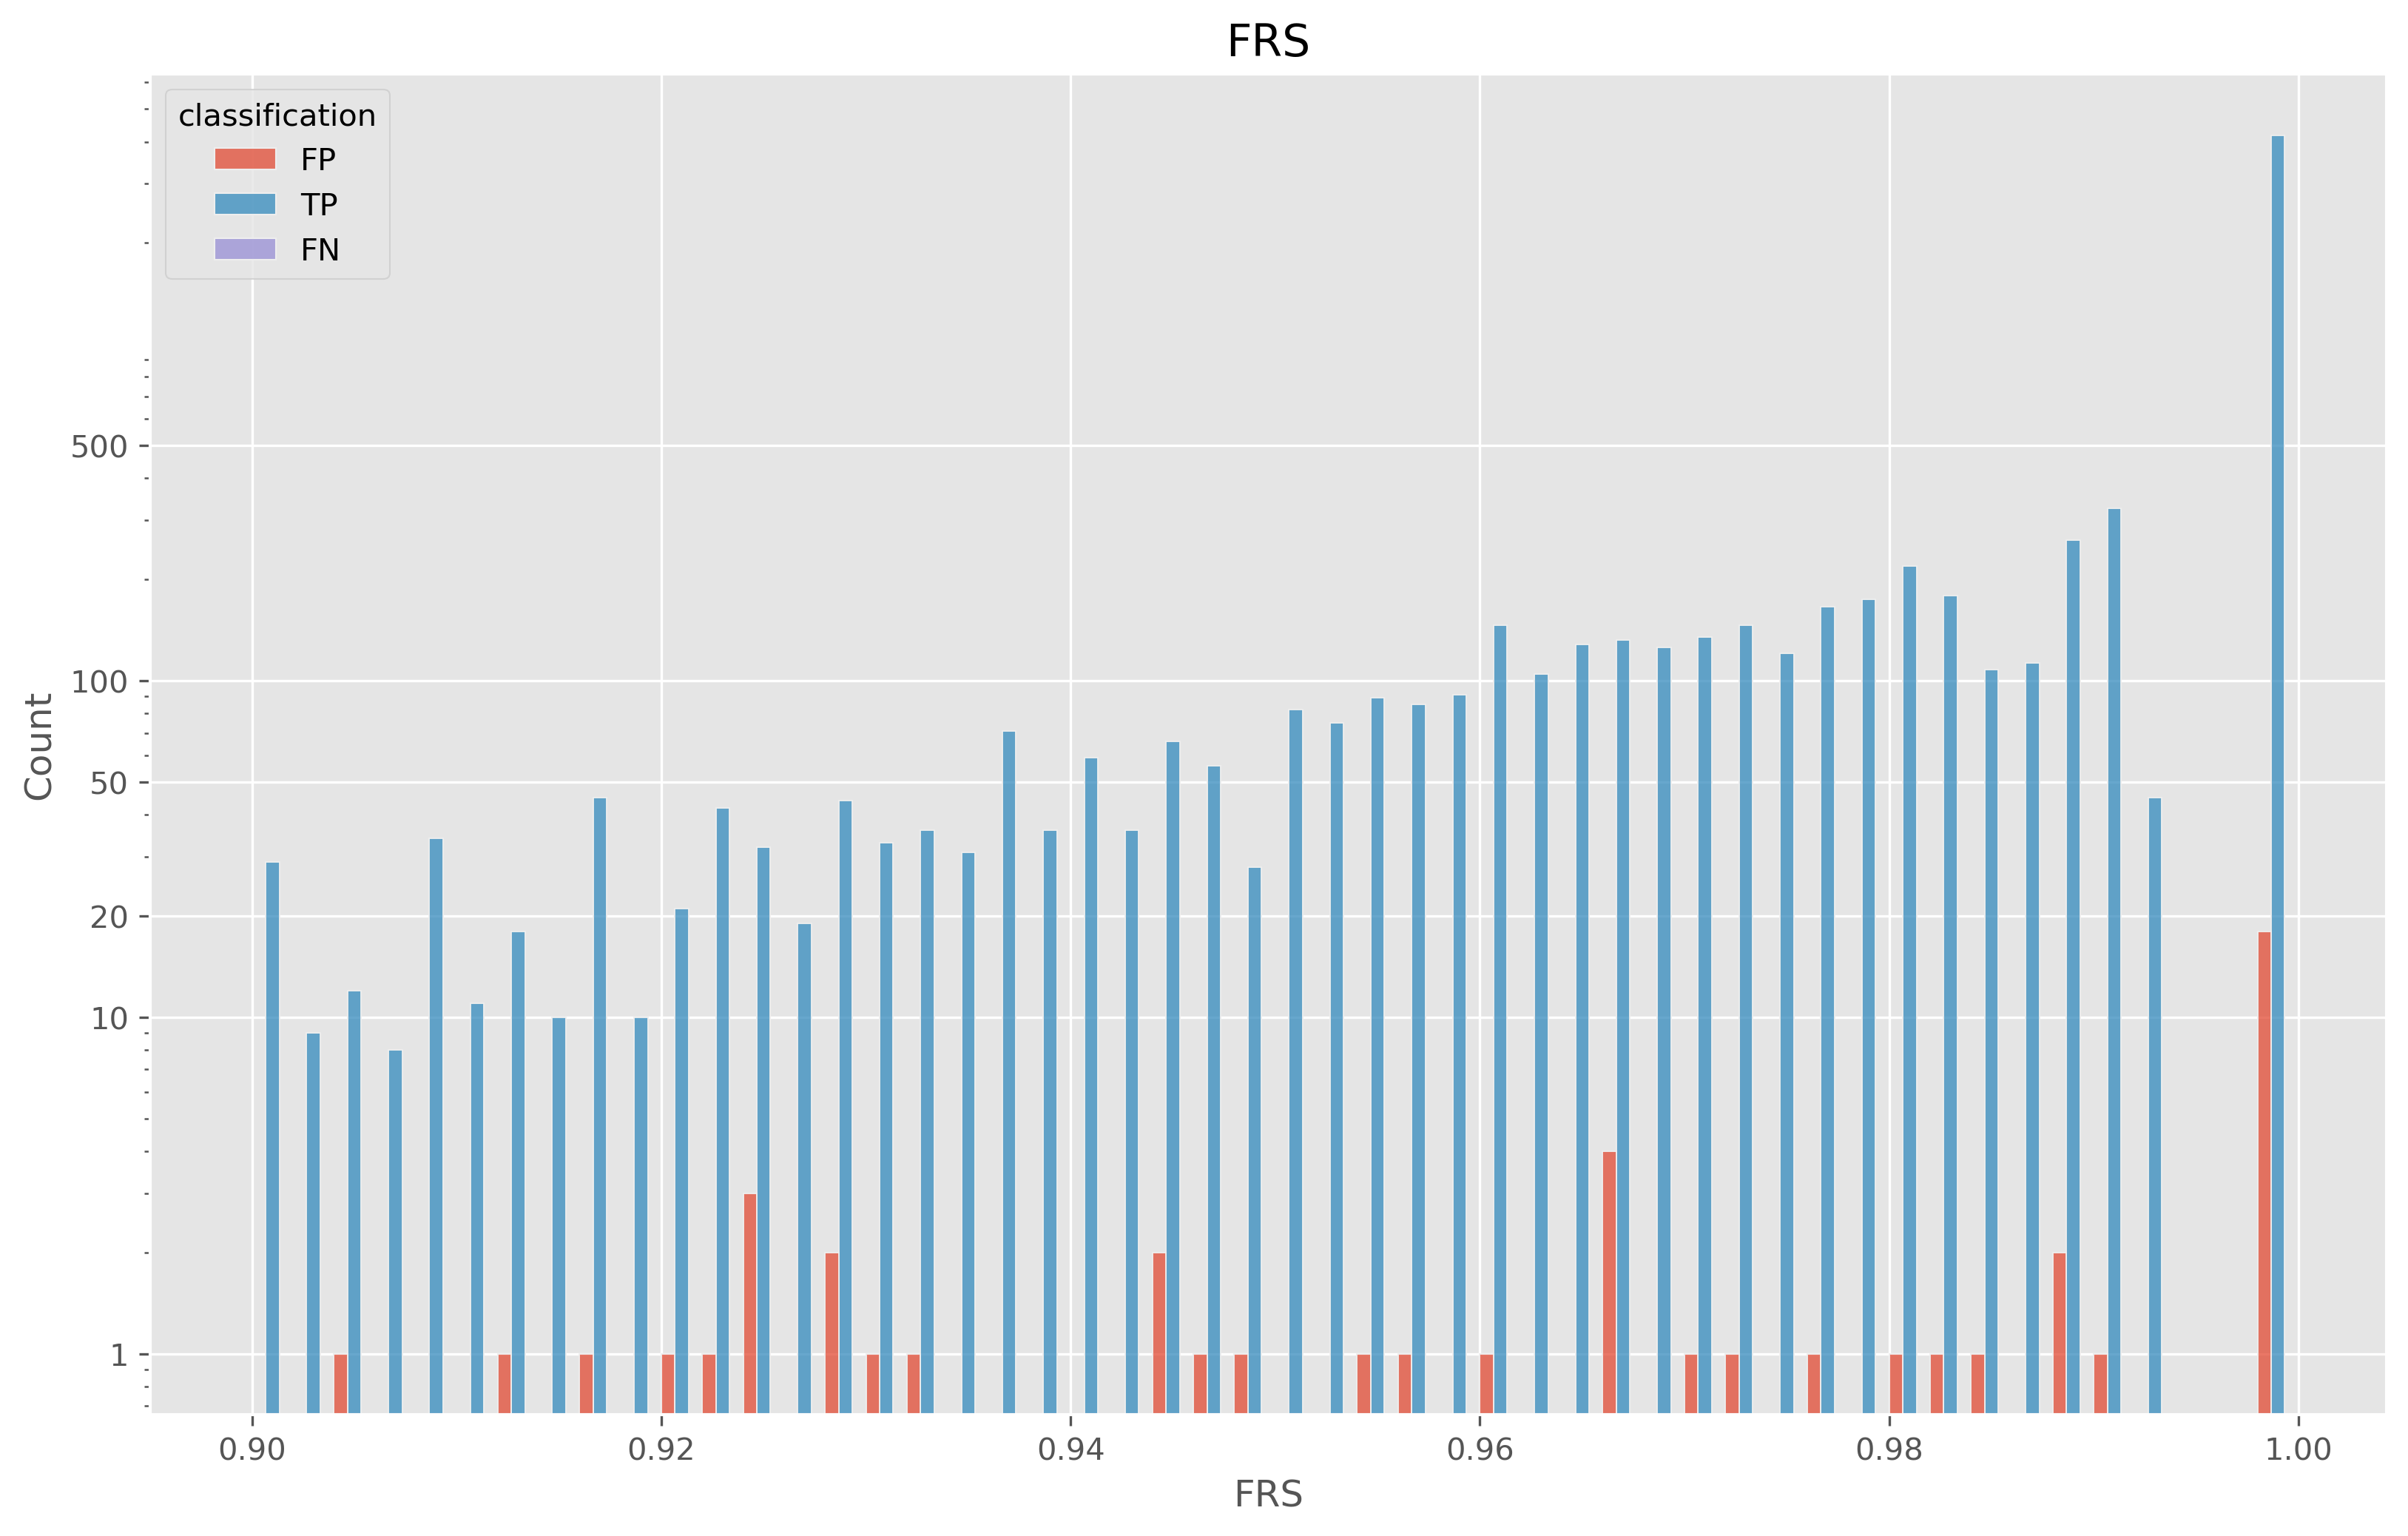

In [24]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "FRS"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# xlabs = [0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# ax.set_xticks(xlabs)
# ax.set_xticklabels(xlabs)
_=ax.set_title(x)

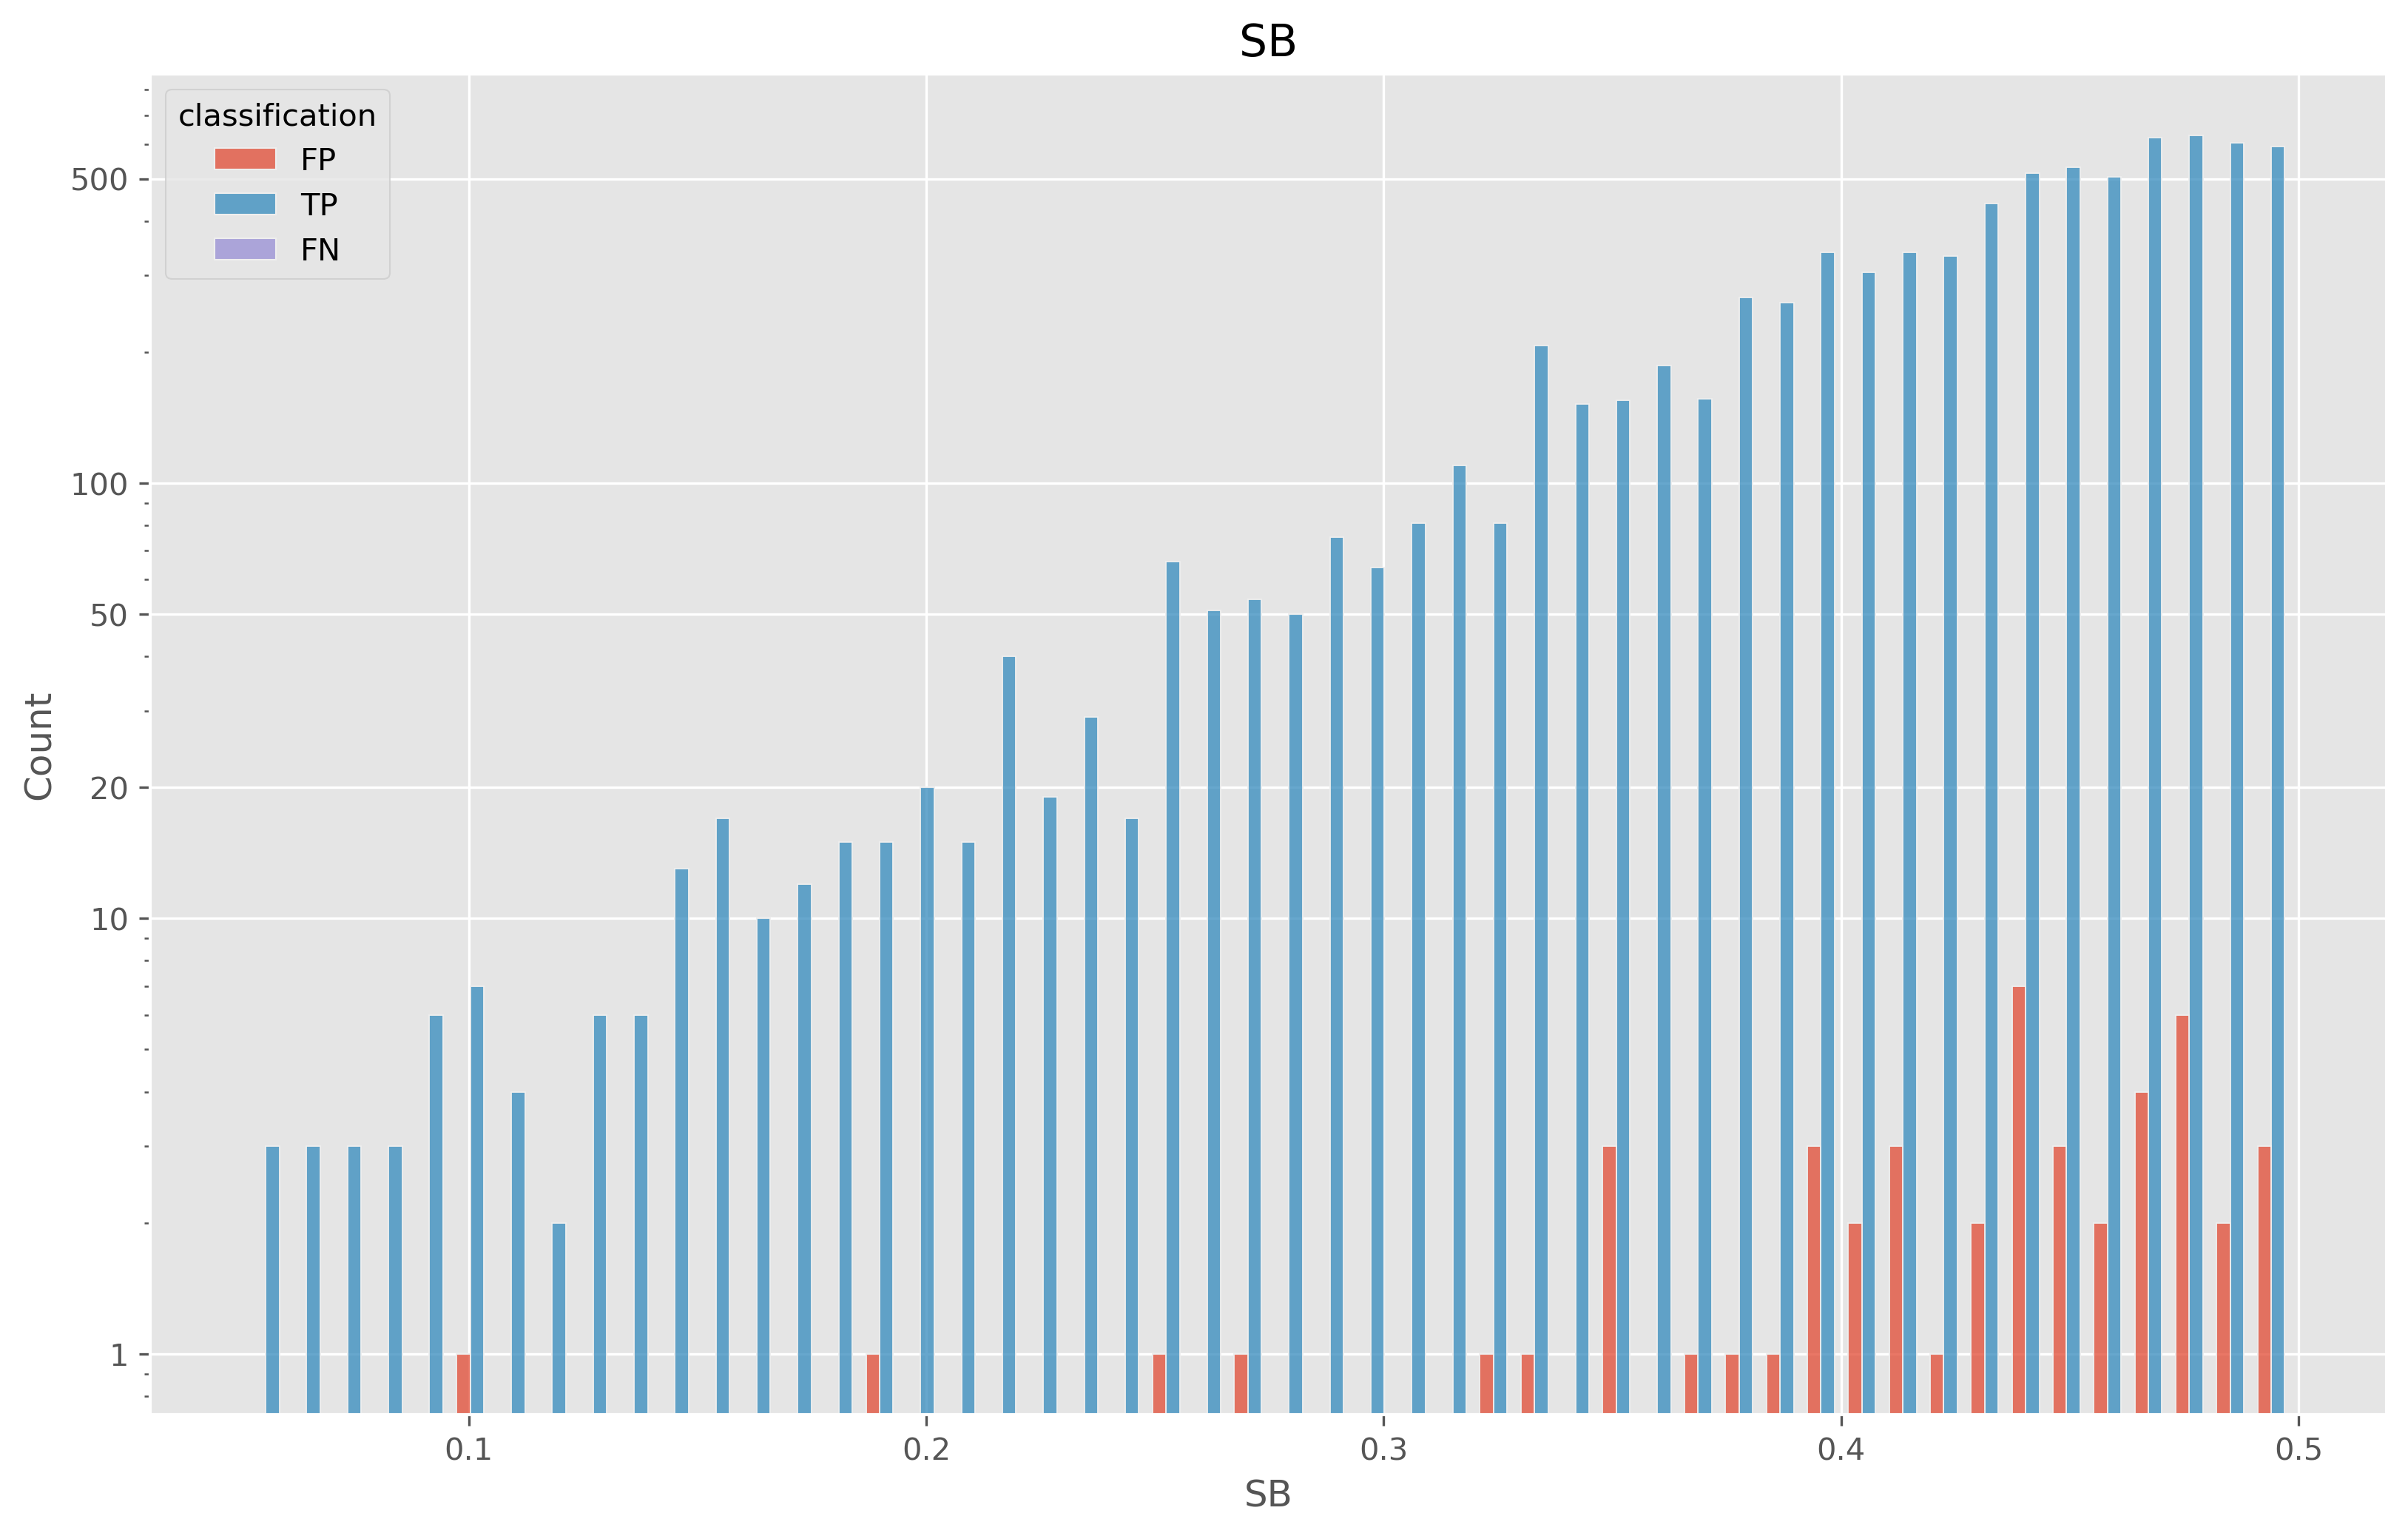

In [25]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "SB"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
_=ax.set_title(x)

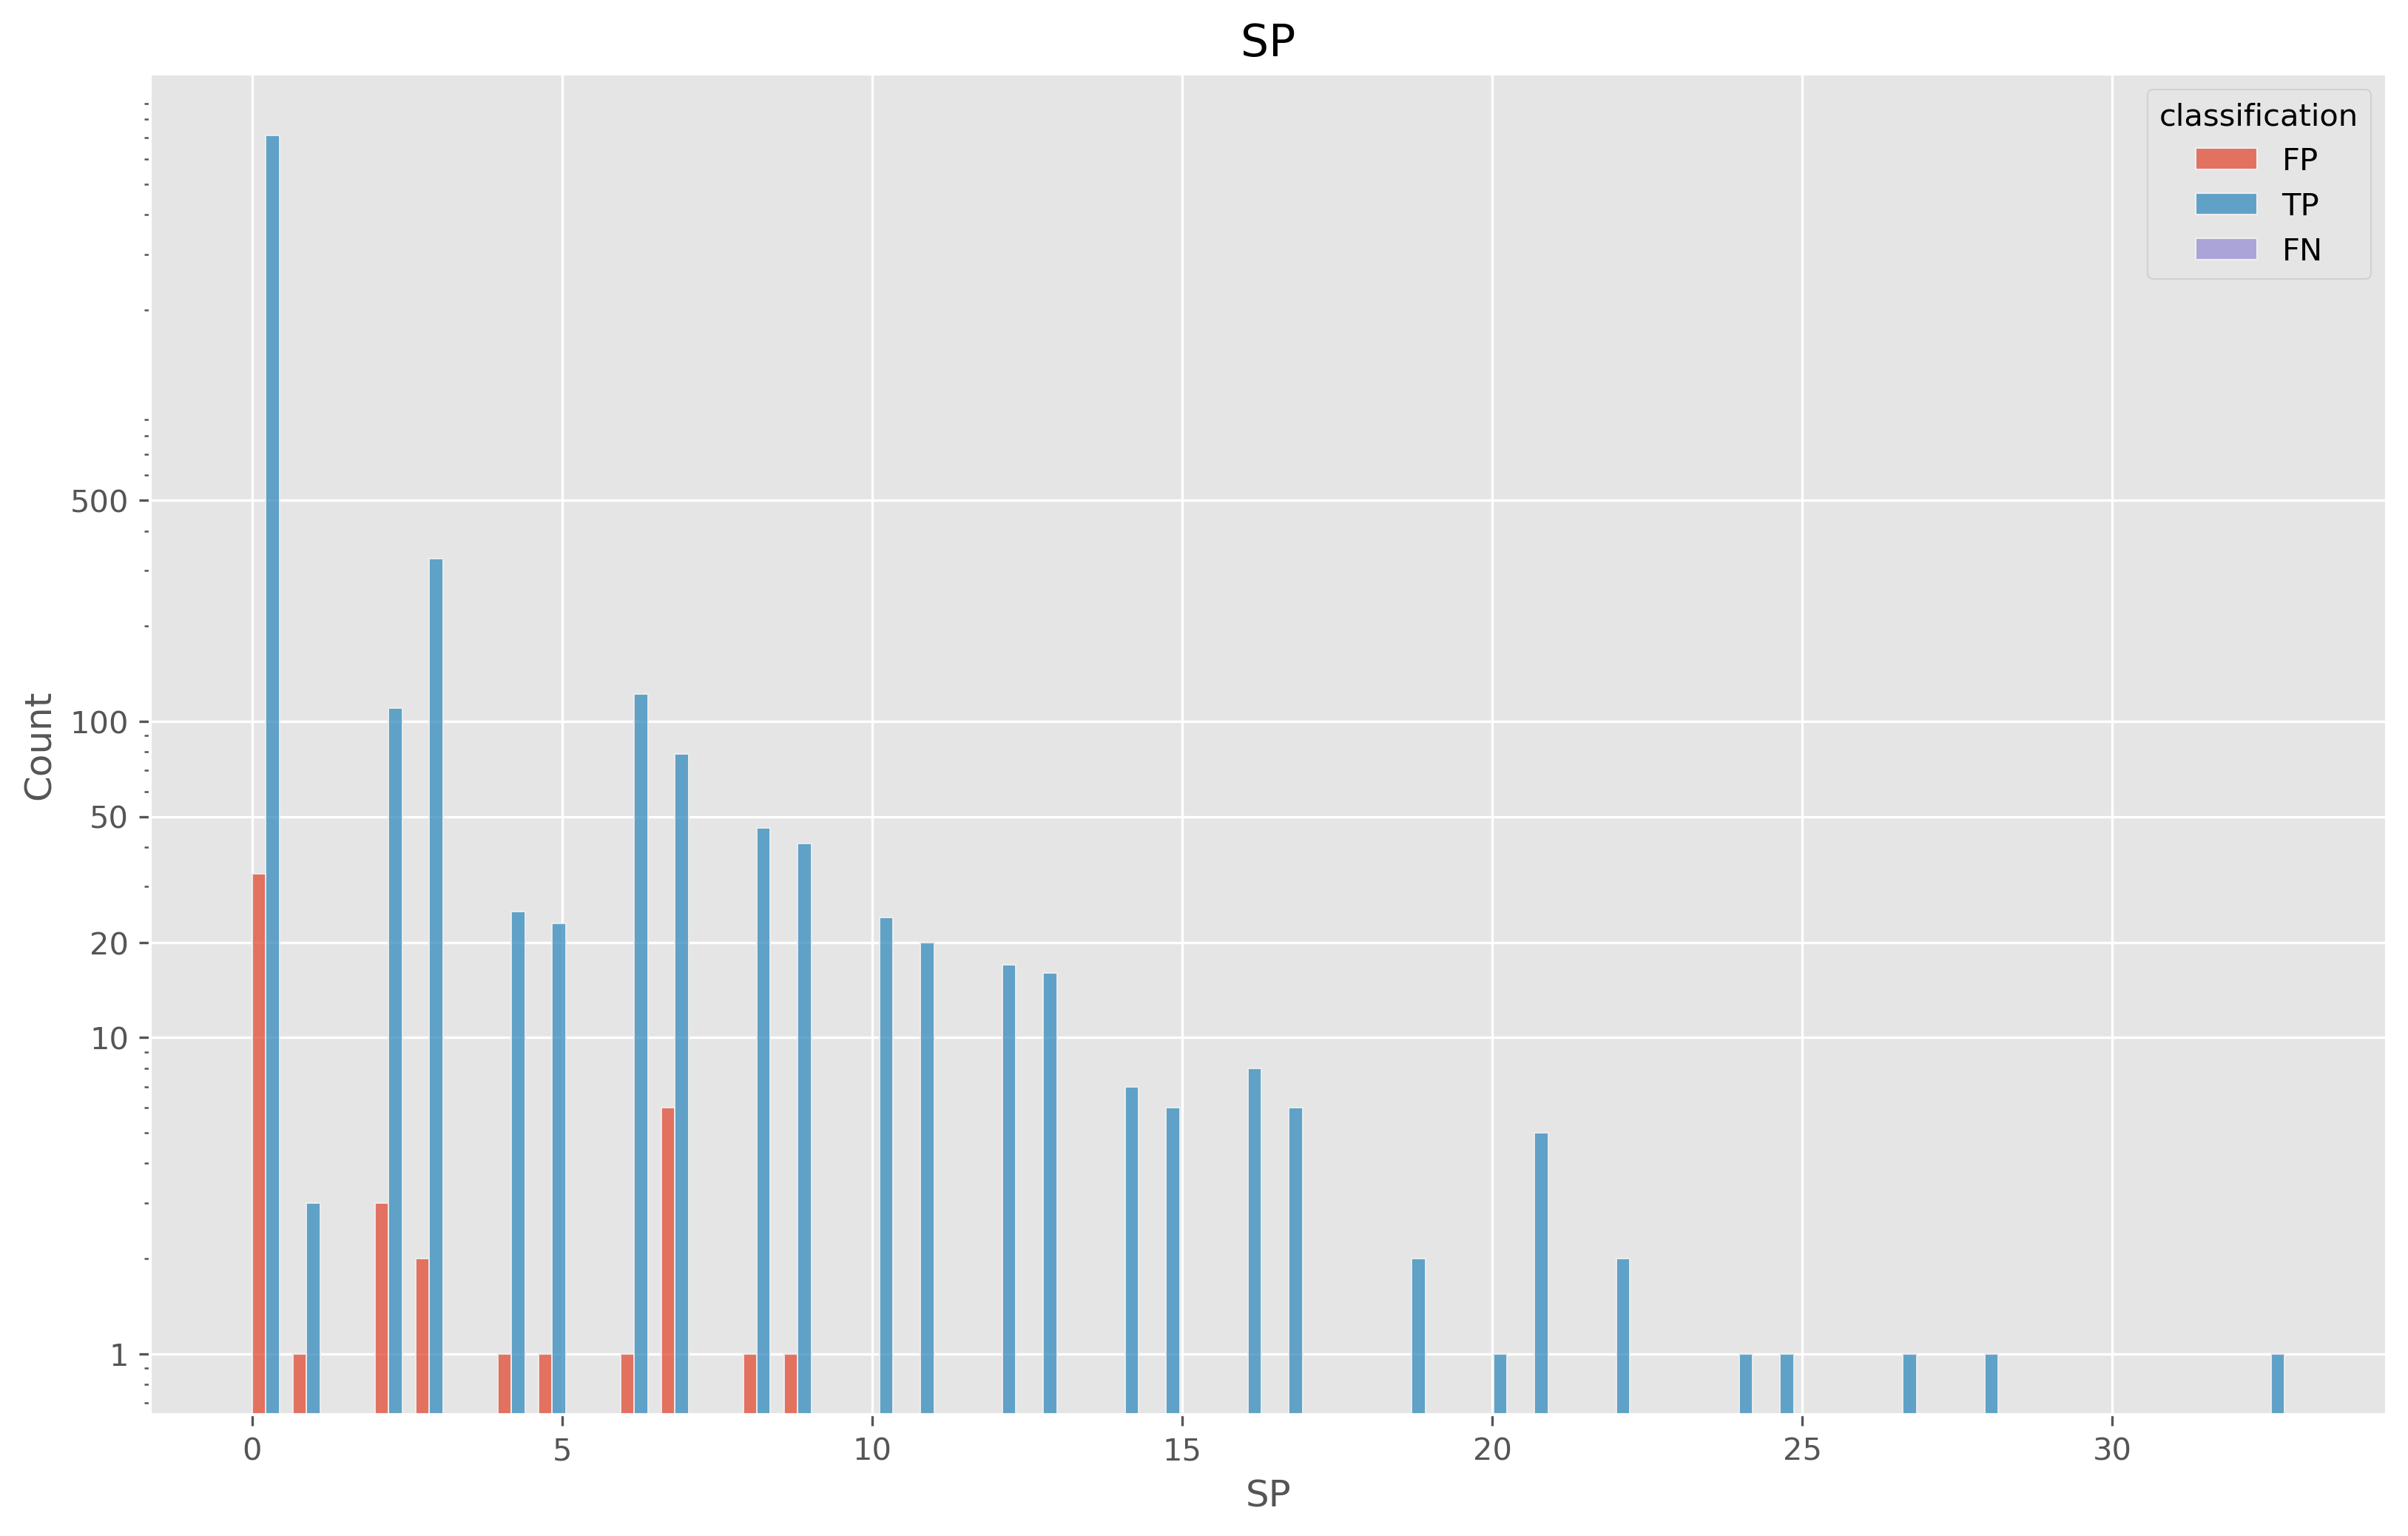

In [26]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "SP"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
_=ax.set_title(x)

In [151]:
print(len(df.query("FED<0.15 and classification=='TP'")))
print(len(df.query("FED<0.15 and classification=='FP'")))

0
0


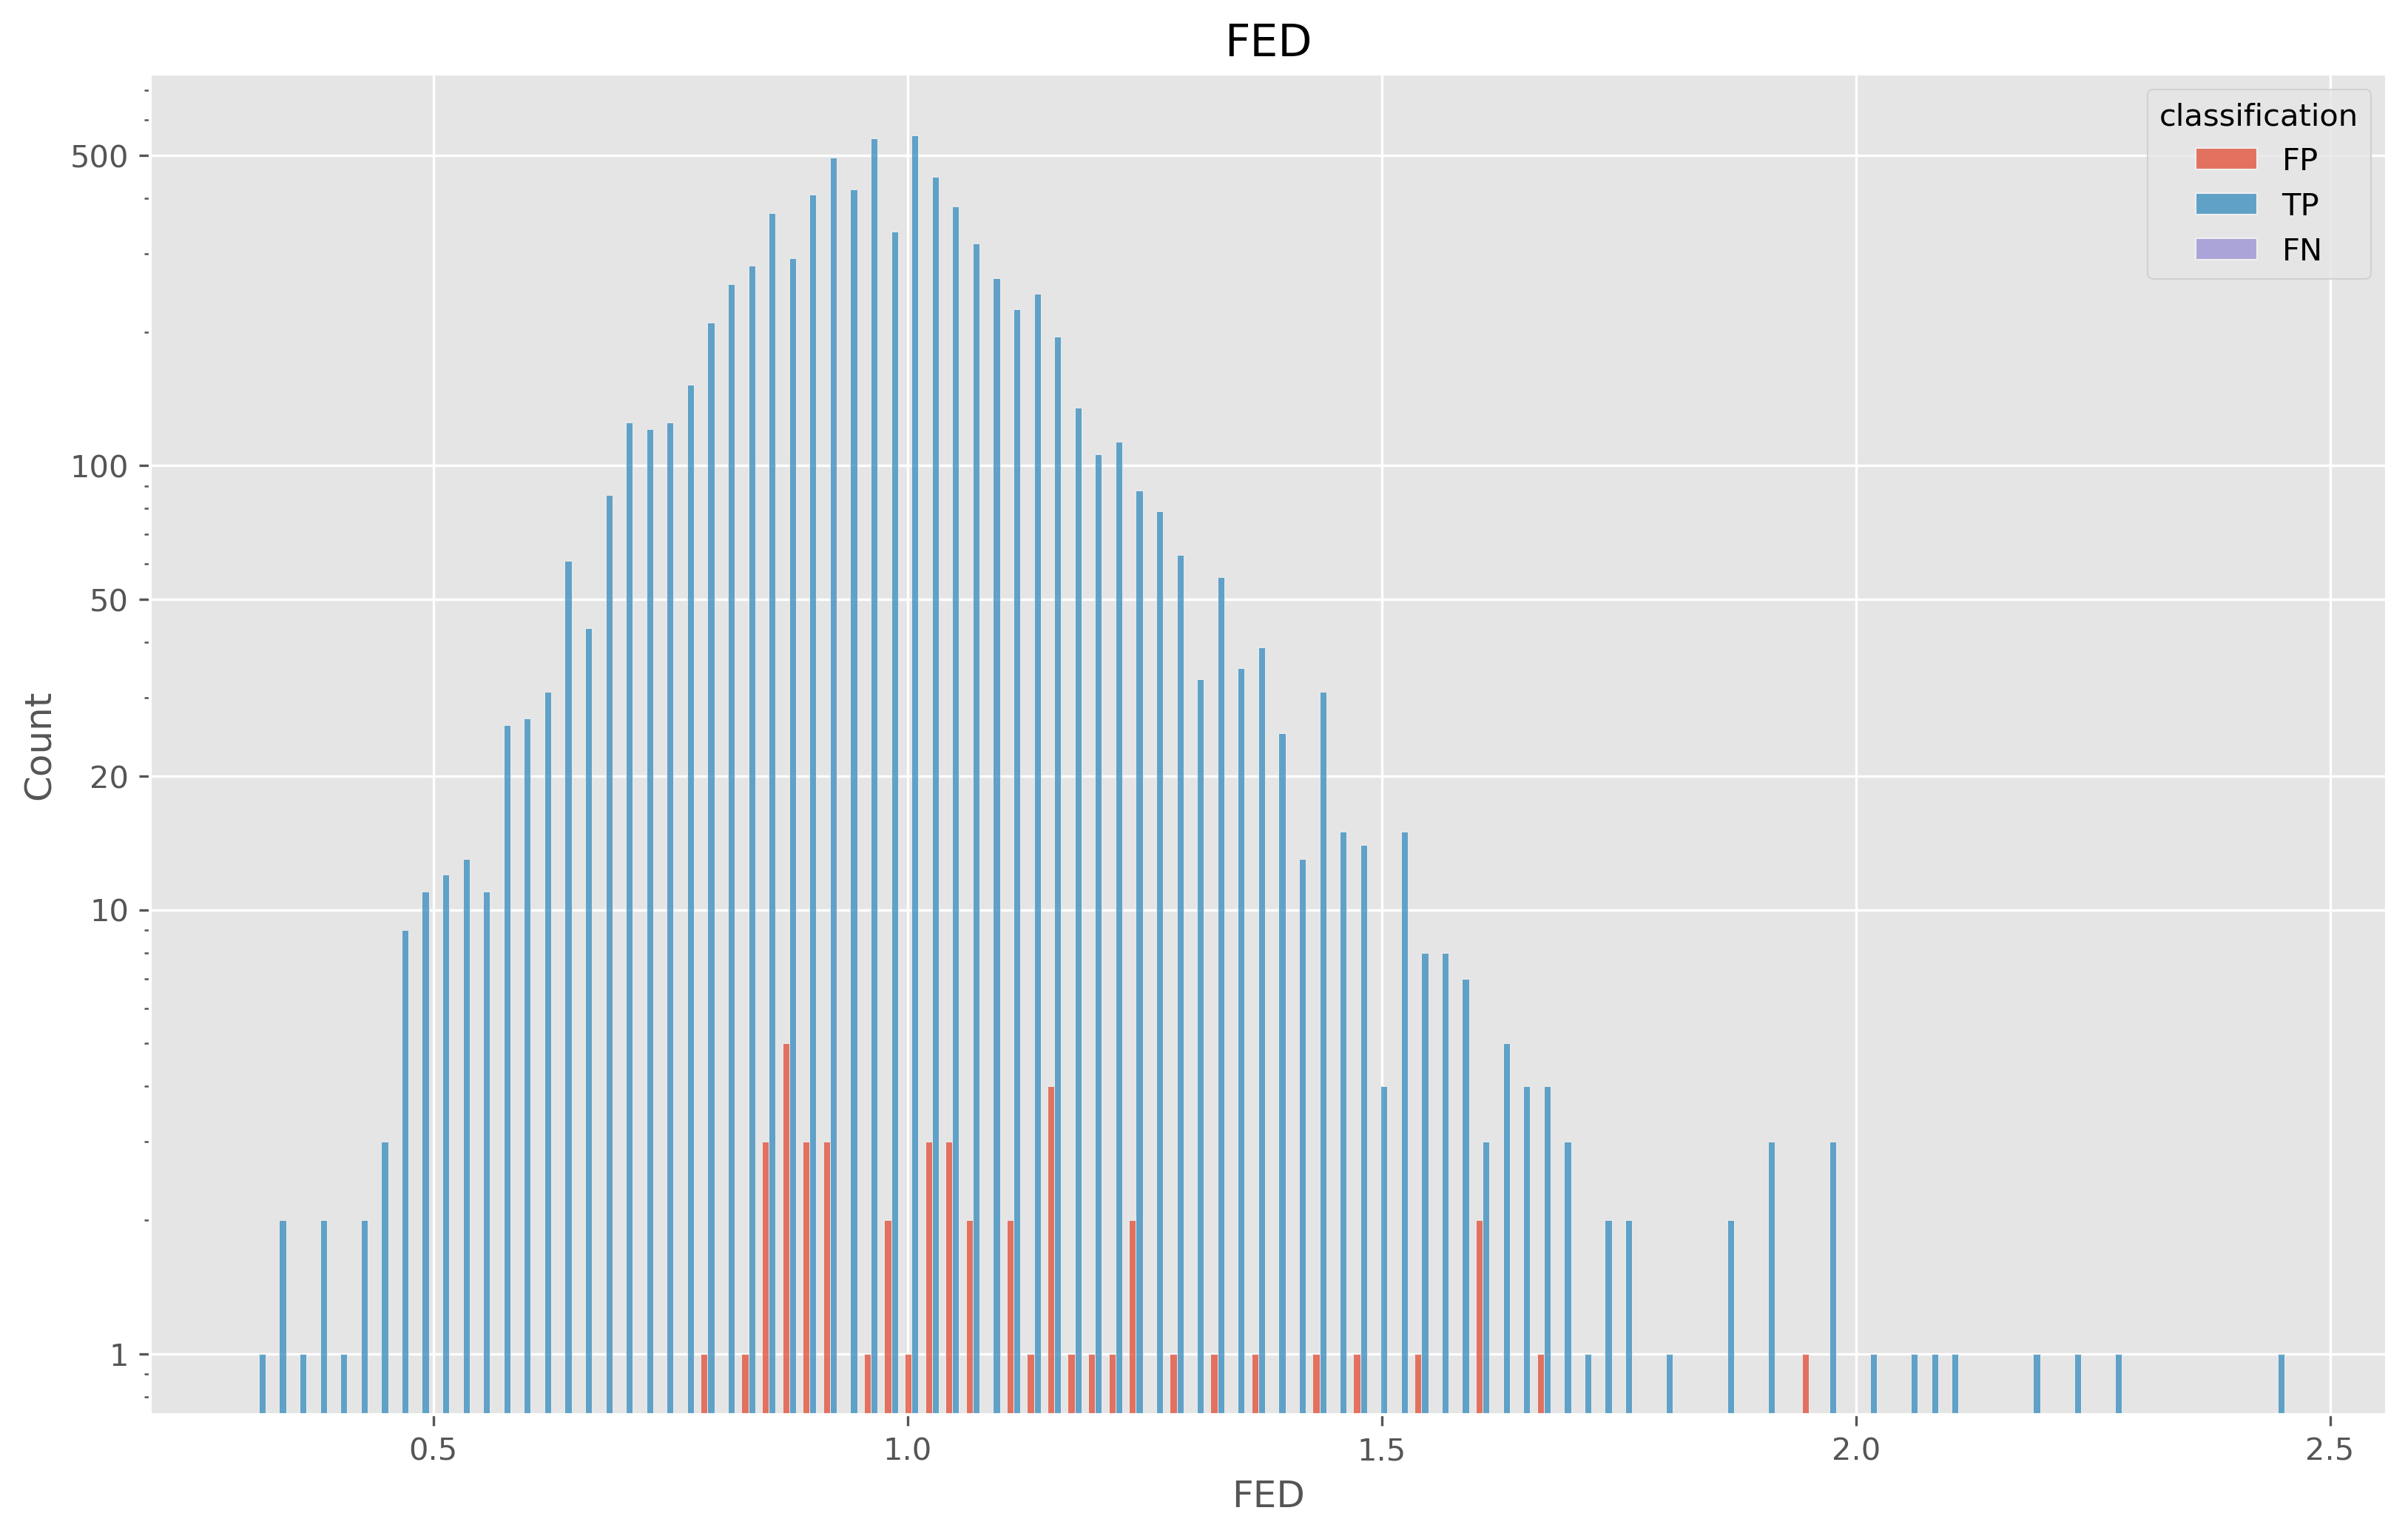

In [28]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "FED"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=100)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.5))
_=ax.set_title(x)

In [153]:
for f in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
    print(f)
    print(len(df.query(f"HQFED<{f} and classification=='TP'")))
    print(len(df.query(f"HQFED<{f} and classification=='FP'")))
    print()

0.05
0
0

0.1
0
0

0.15
0
0

0.2
0
0

0.25
28
2

0.3
109
8



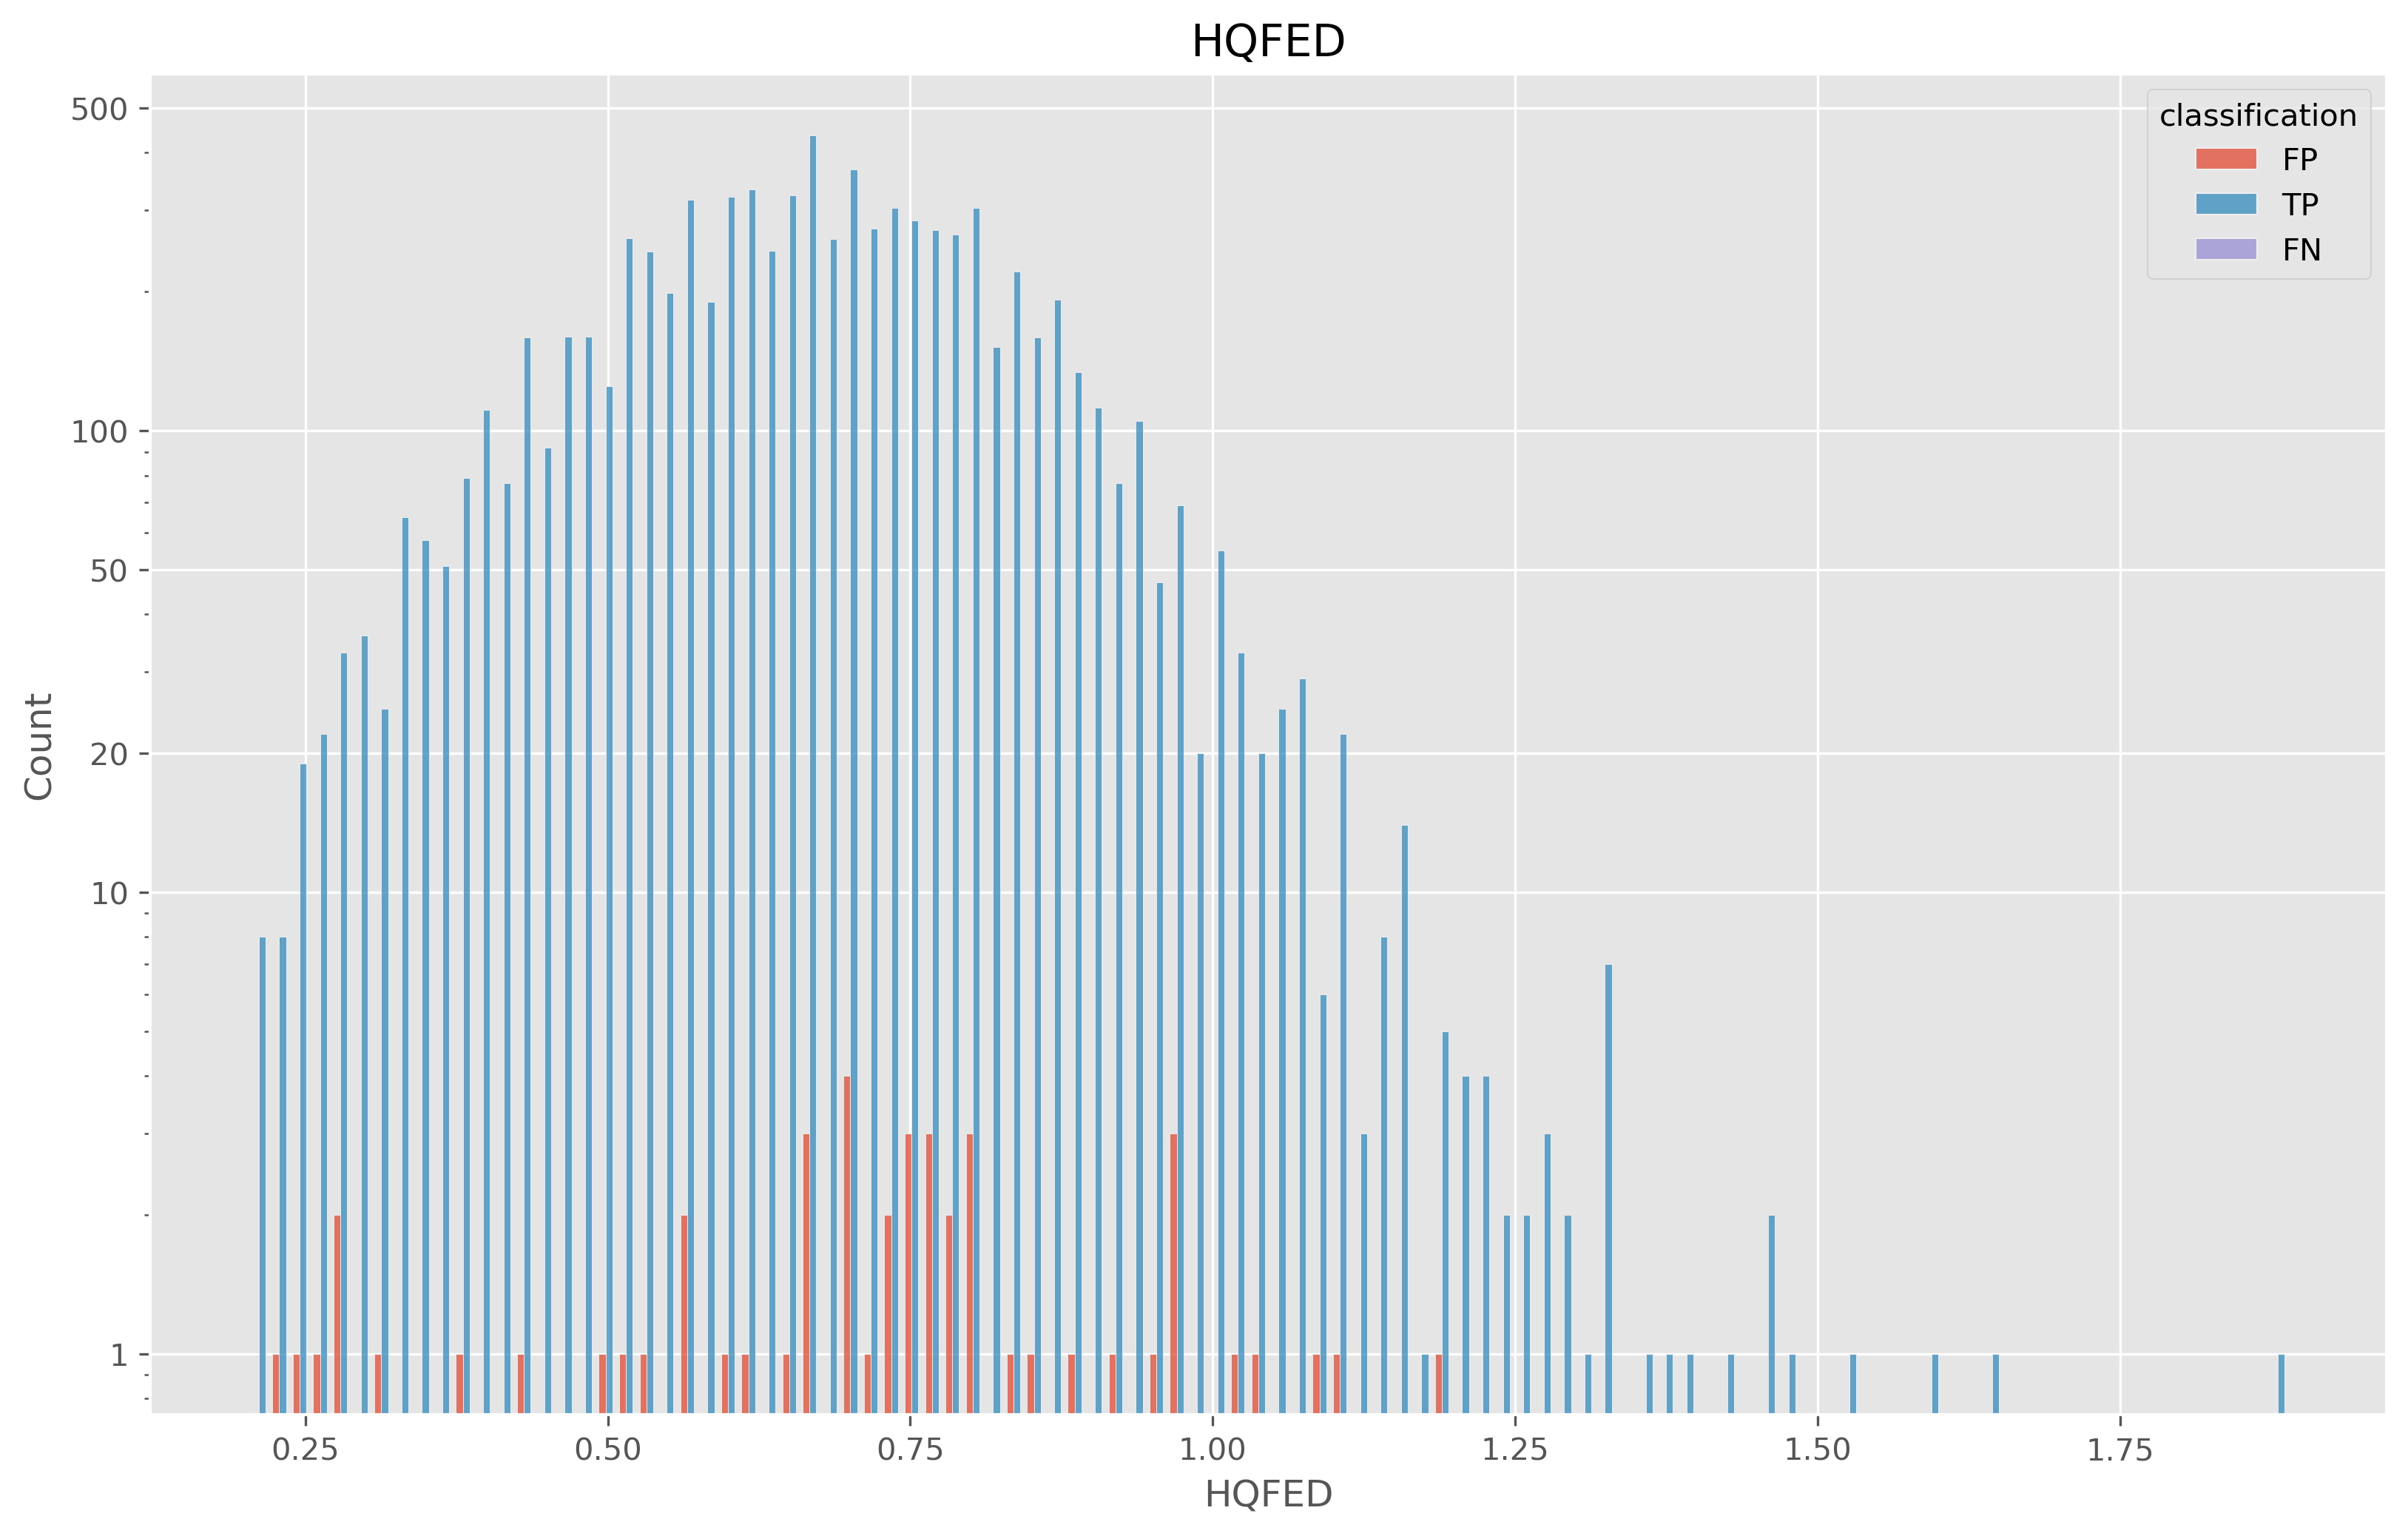

In [29]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "HQFED"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=100)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.5))
_=ax.set_title(x)

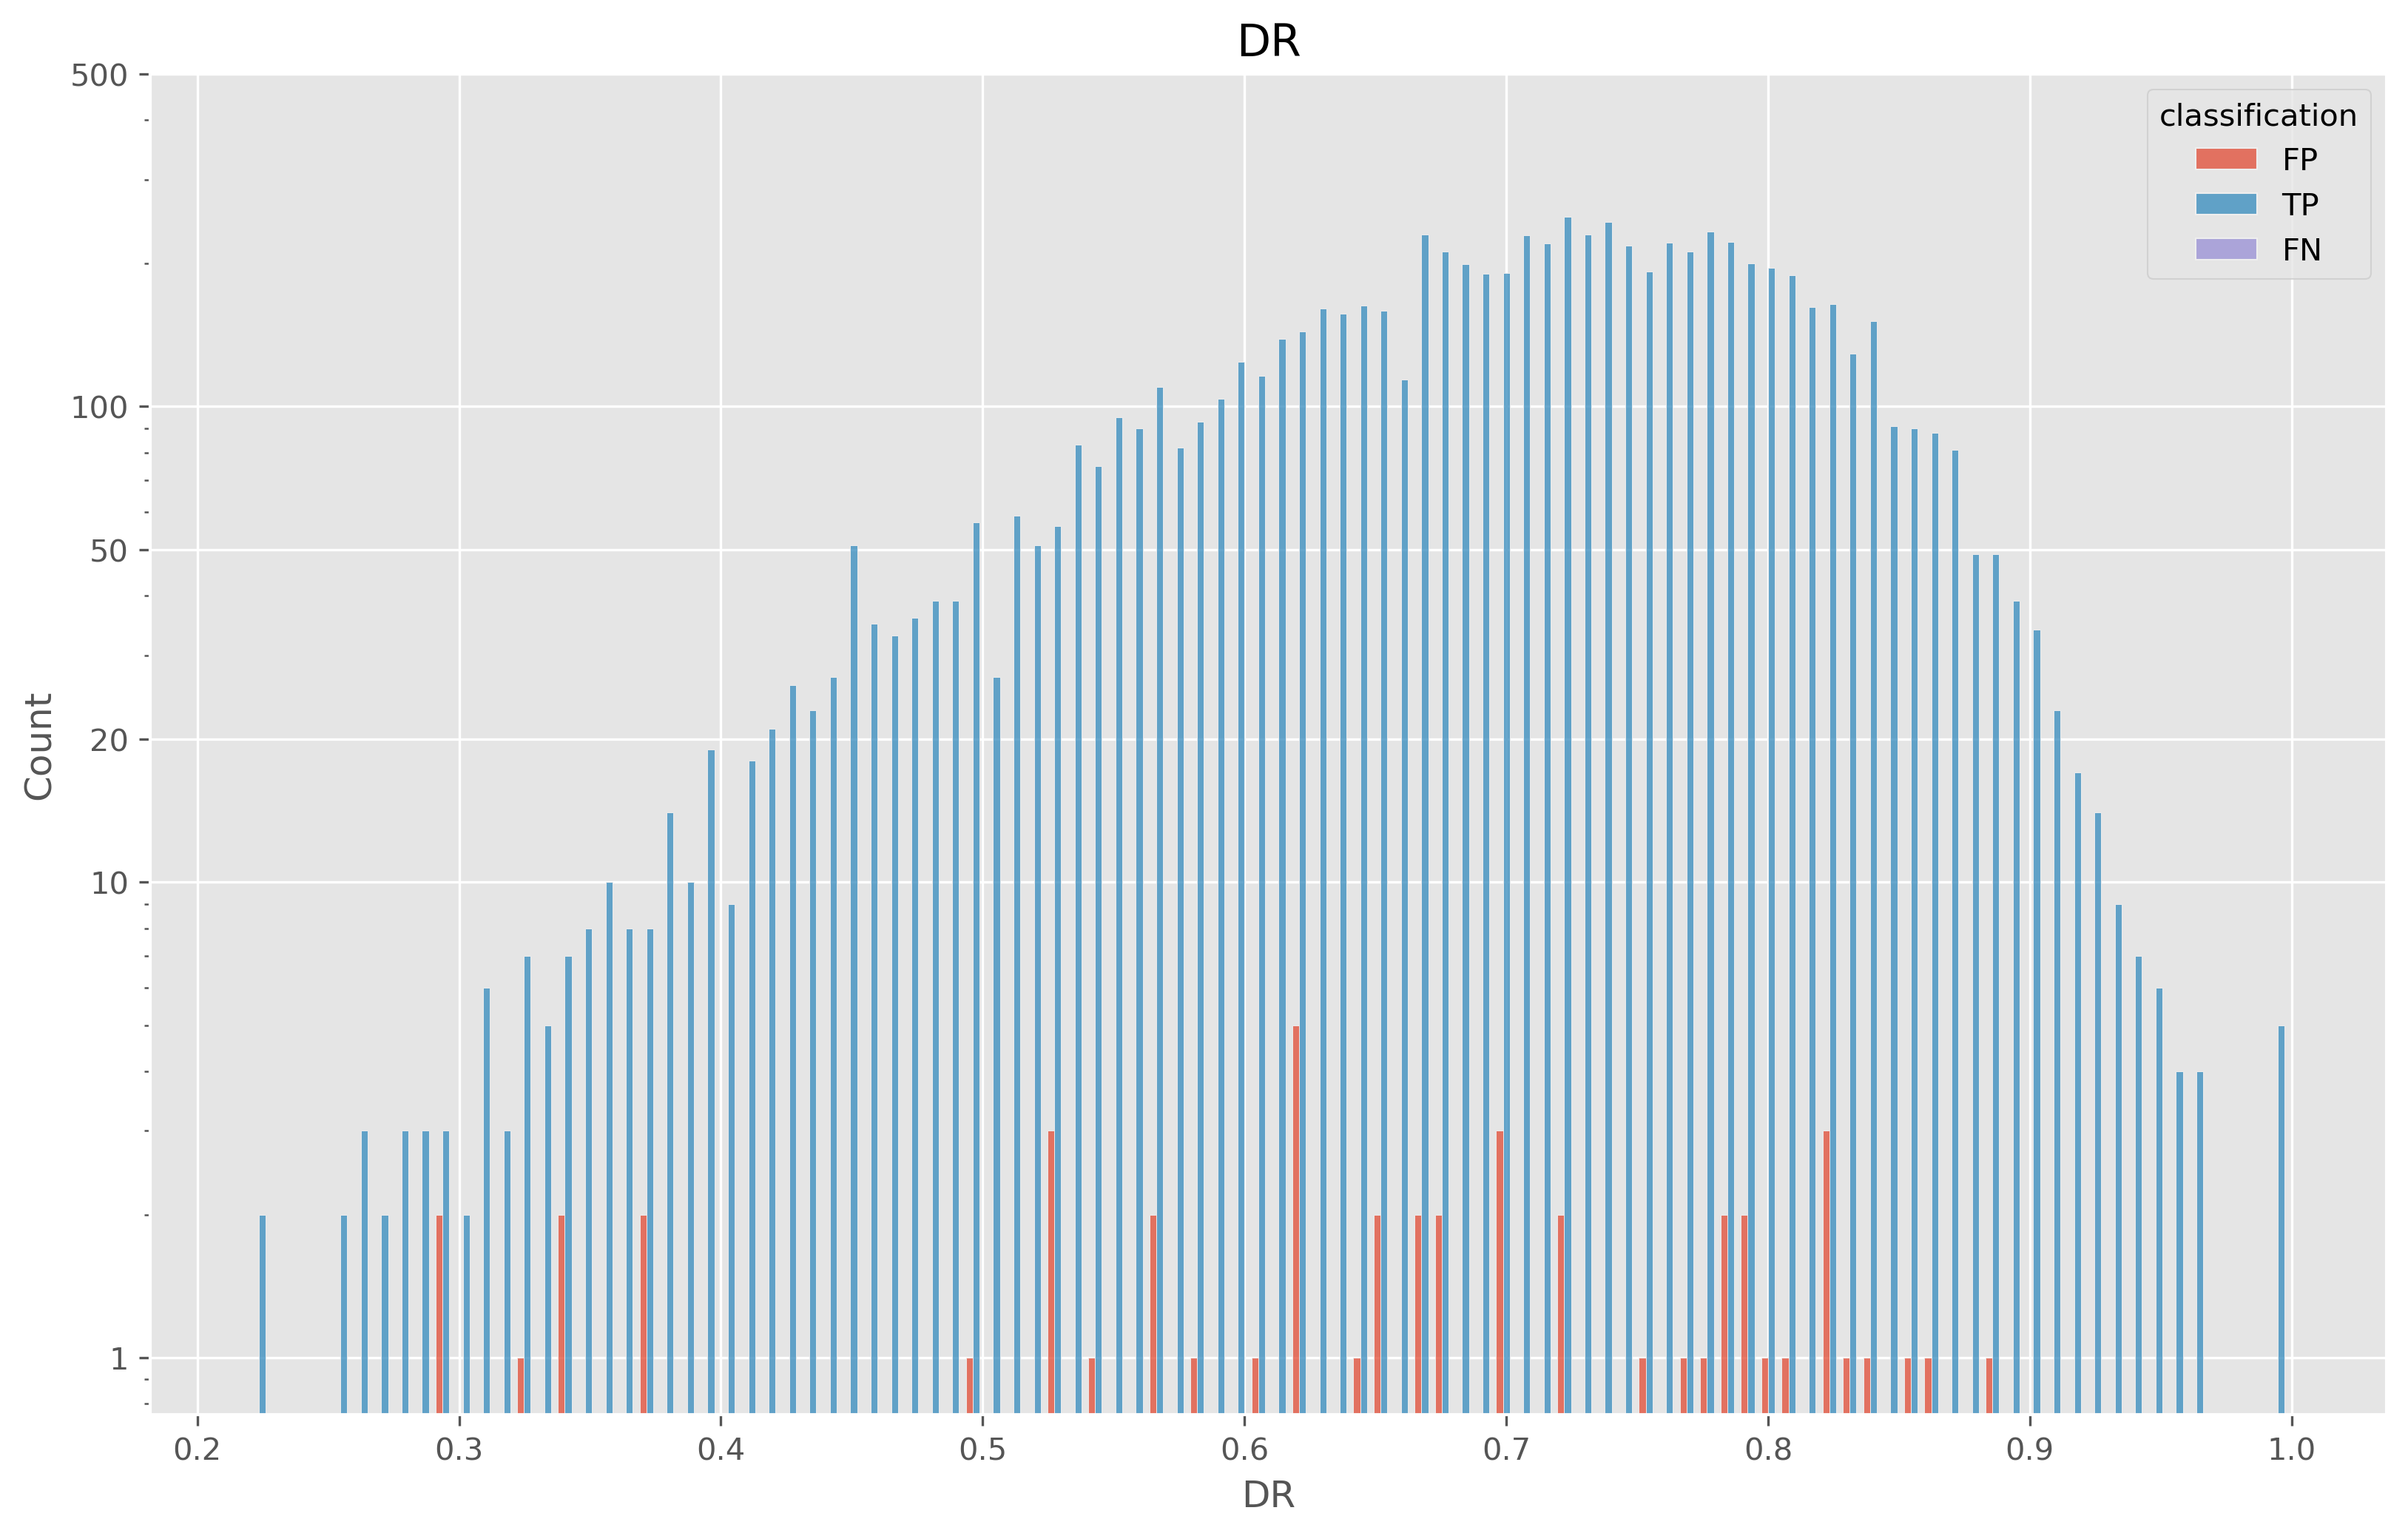

In [49]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "DR"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=100)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.5))
_=ax.set_title(x)

In [35]:
print(len(df.query("SCRF>1.5 and classification=='TP'")))
print(len(df.query("SCRF>1.5 and classification=='FP'")))

27
4


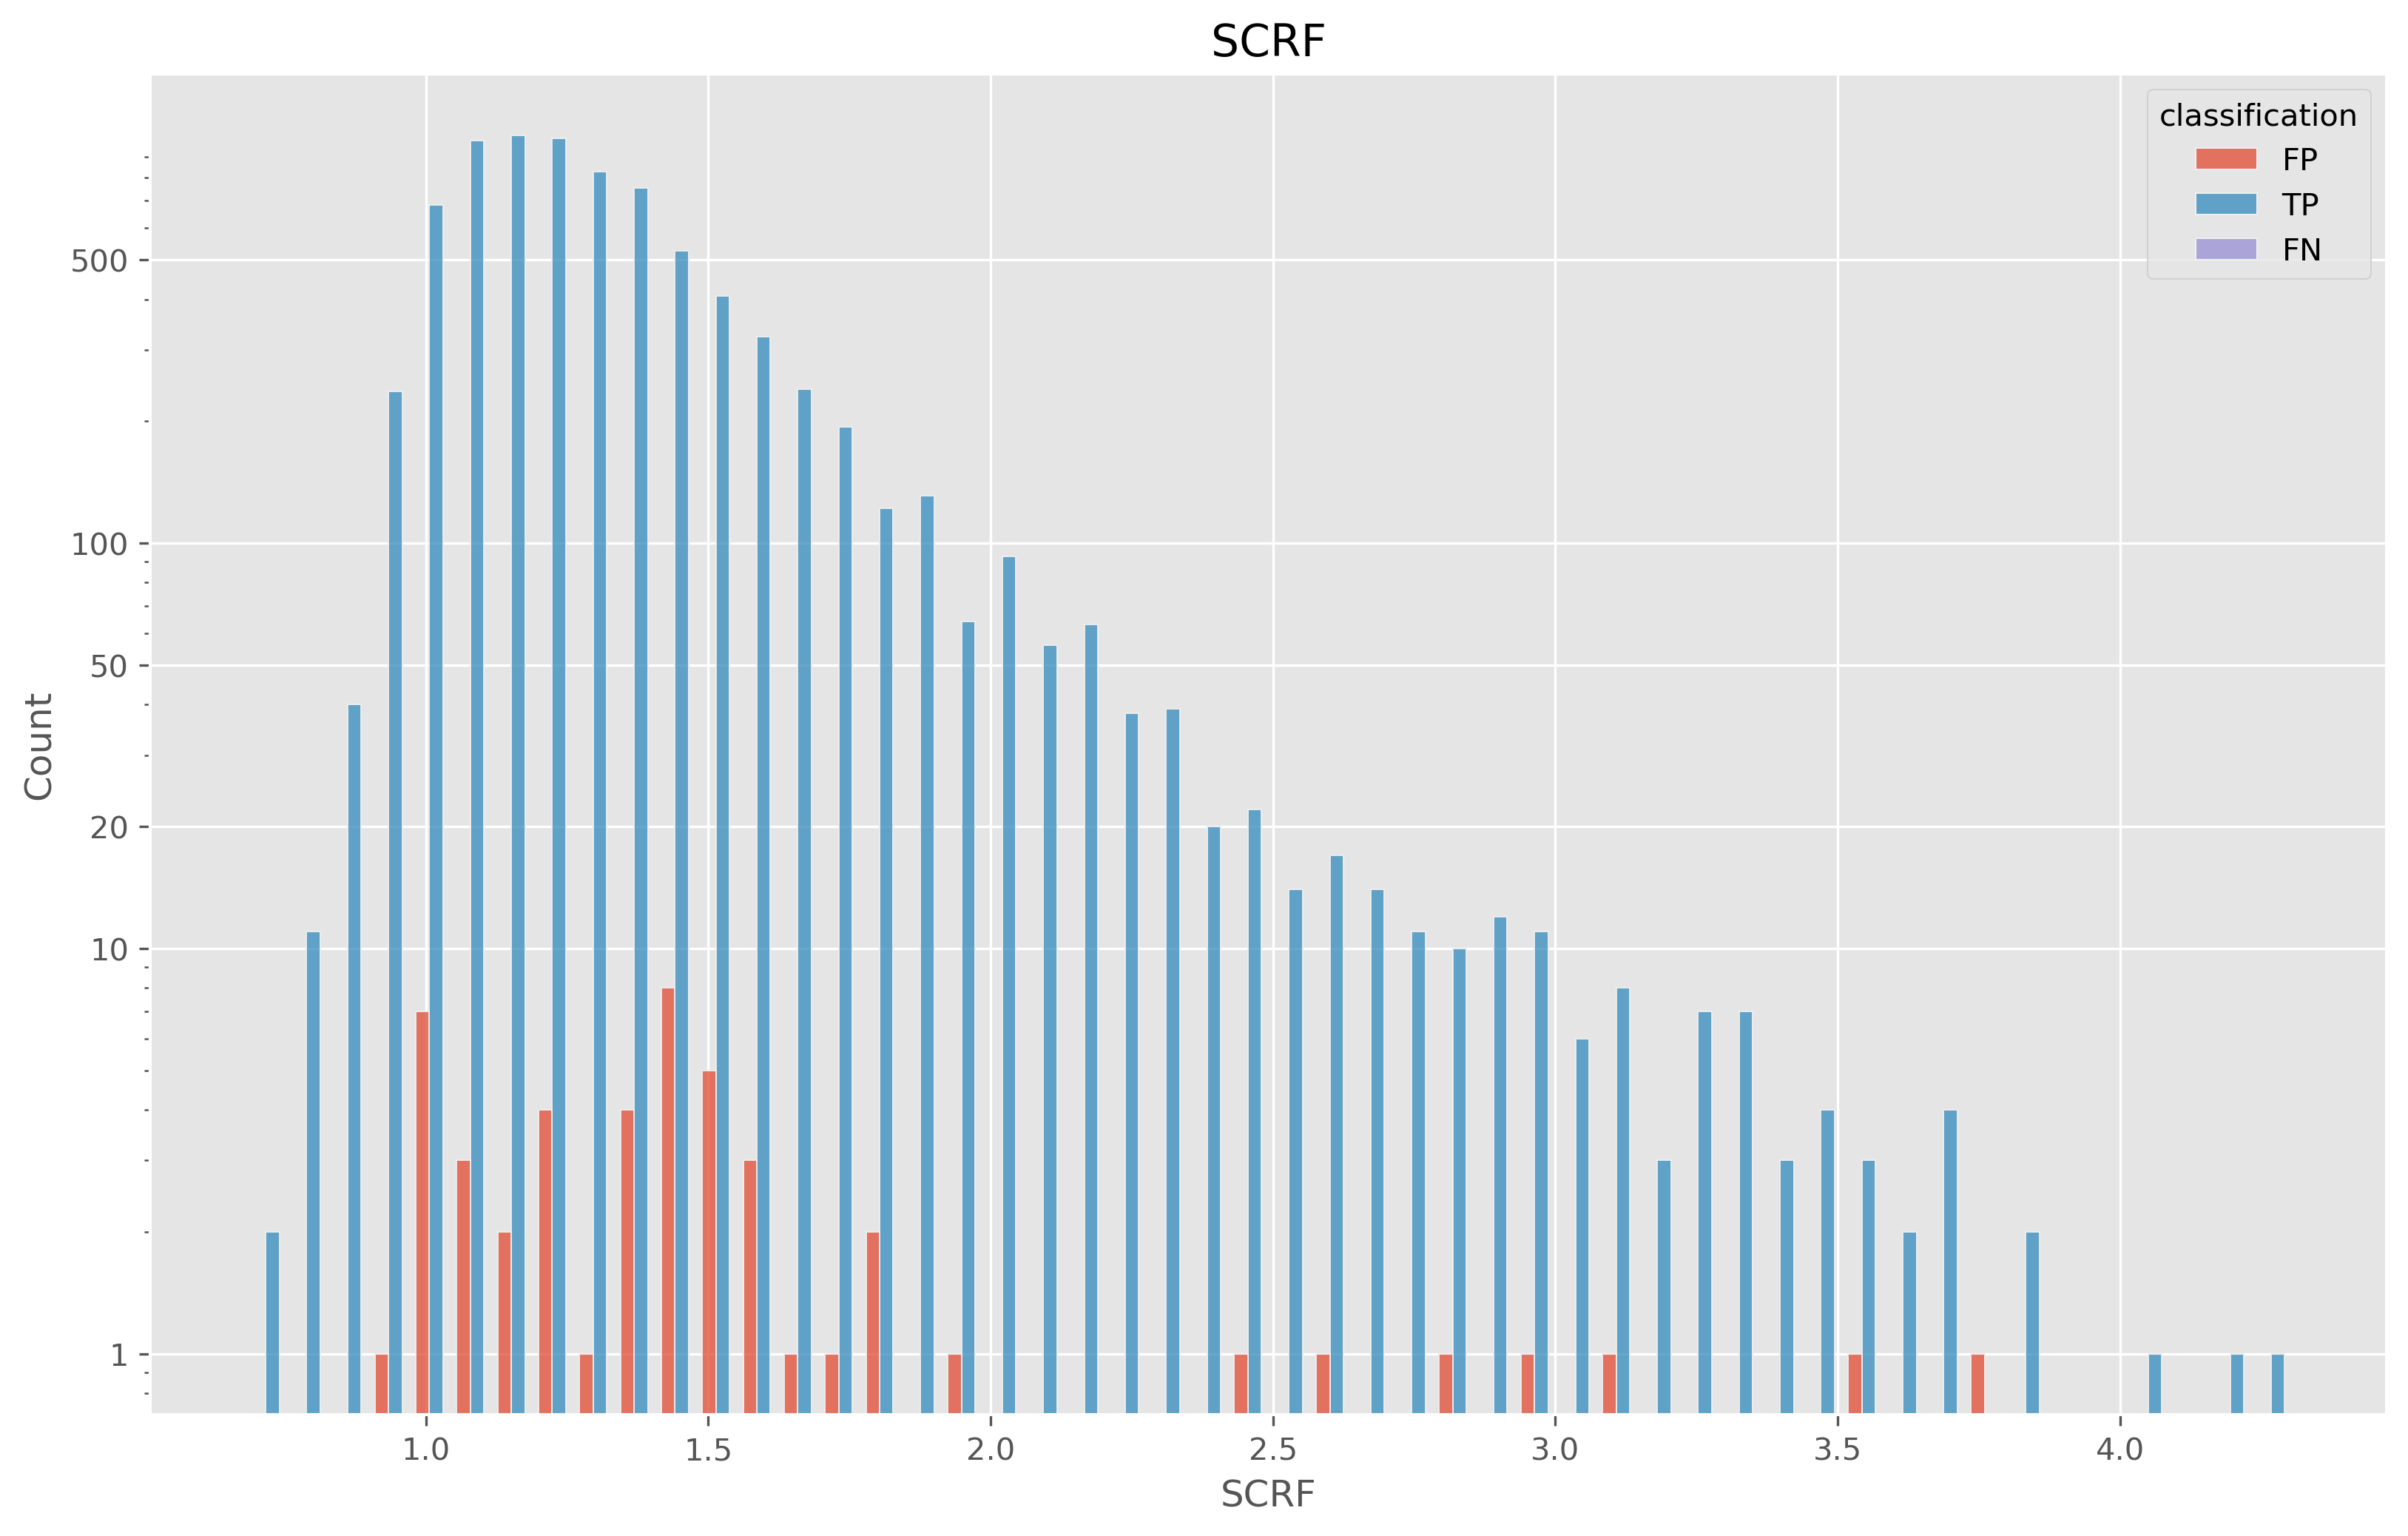

In [45]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "SCRF"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 1))
_=ax.set_title(x)

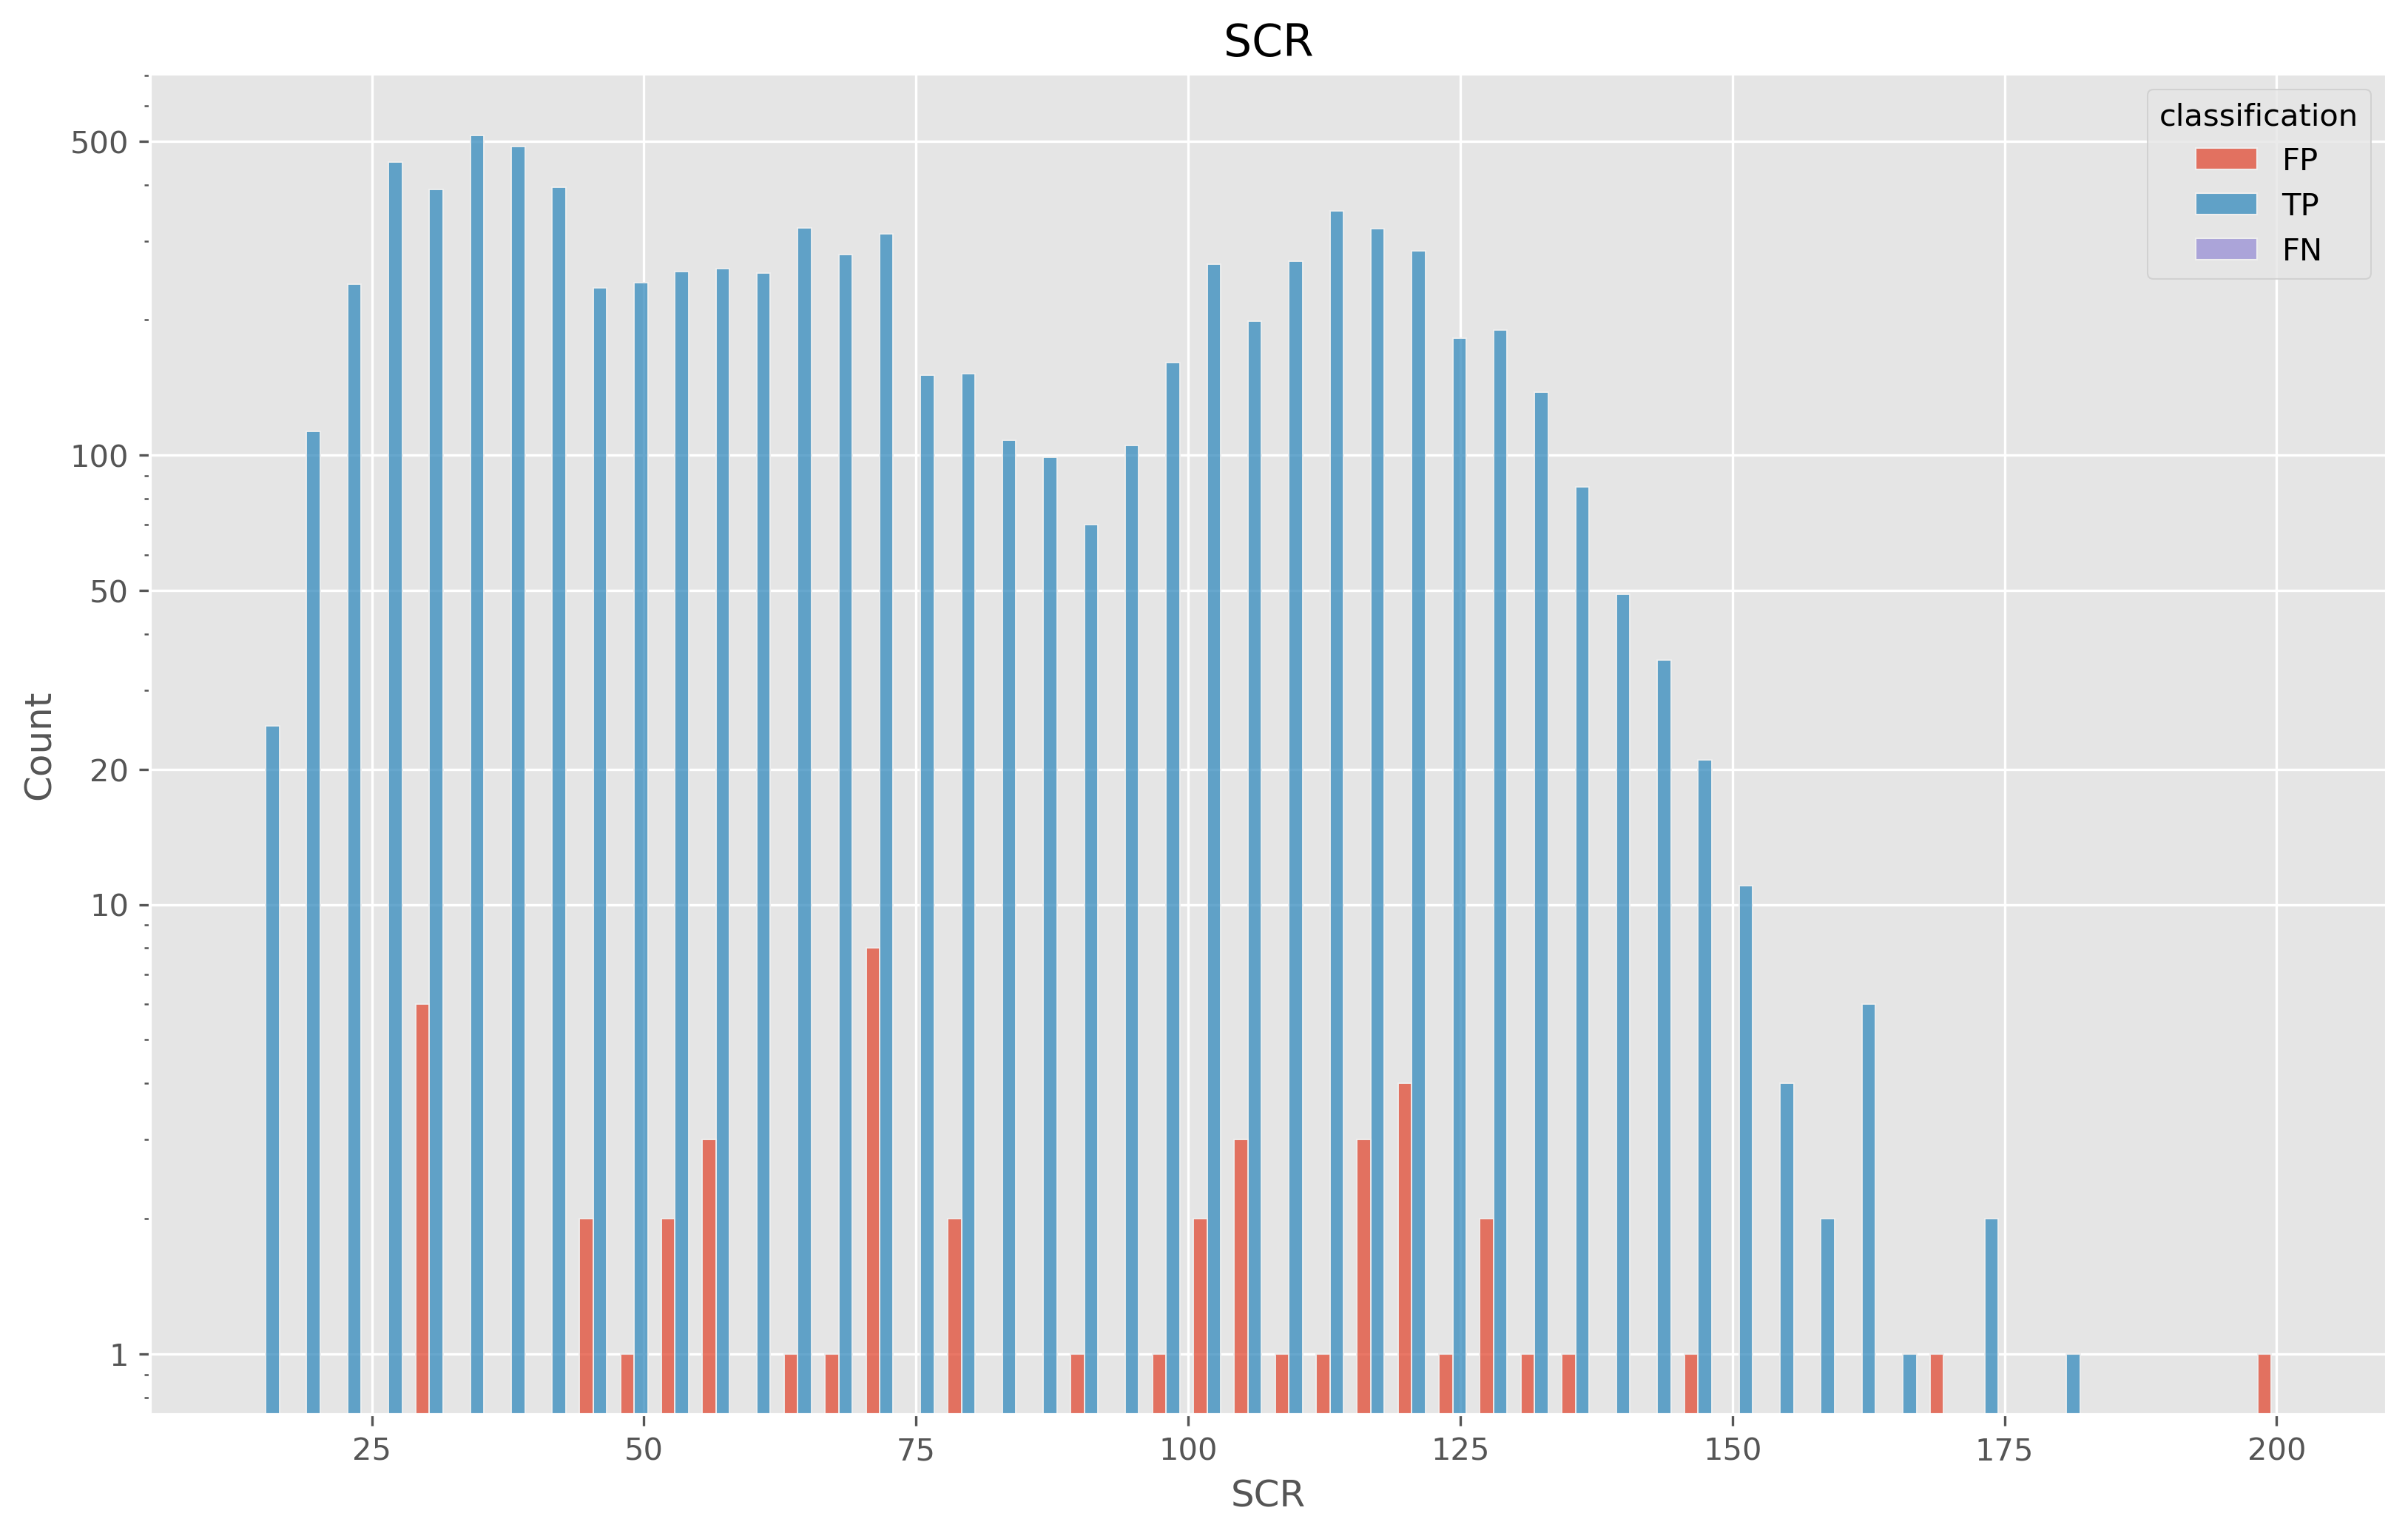

In [36]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "SCR"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 1))
_=ax.set_title(x)

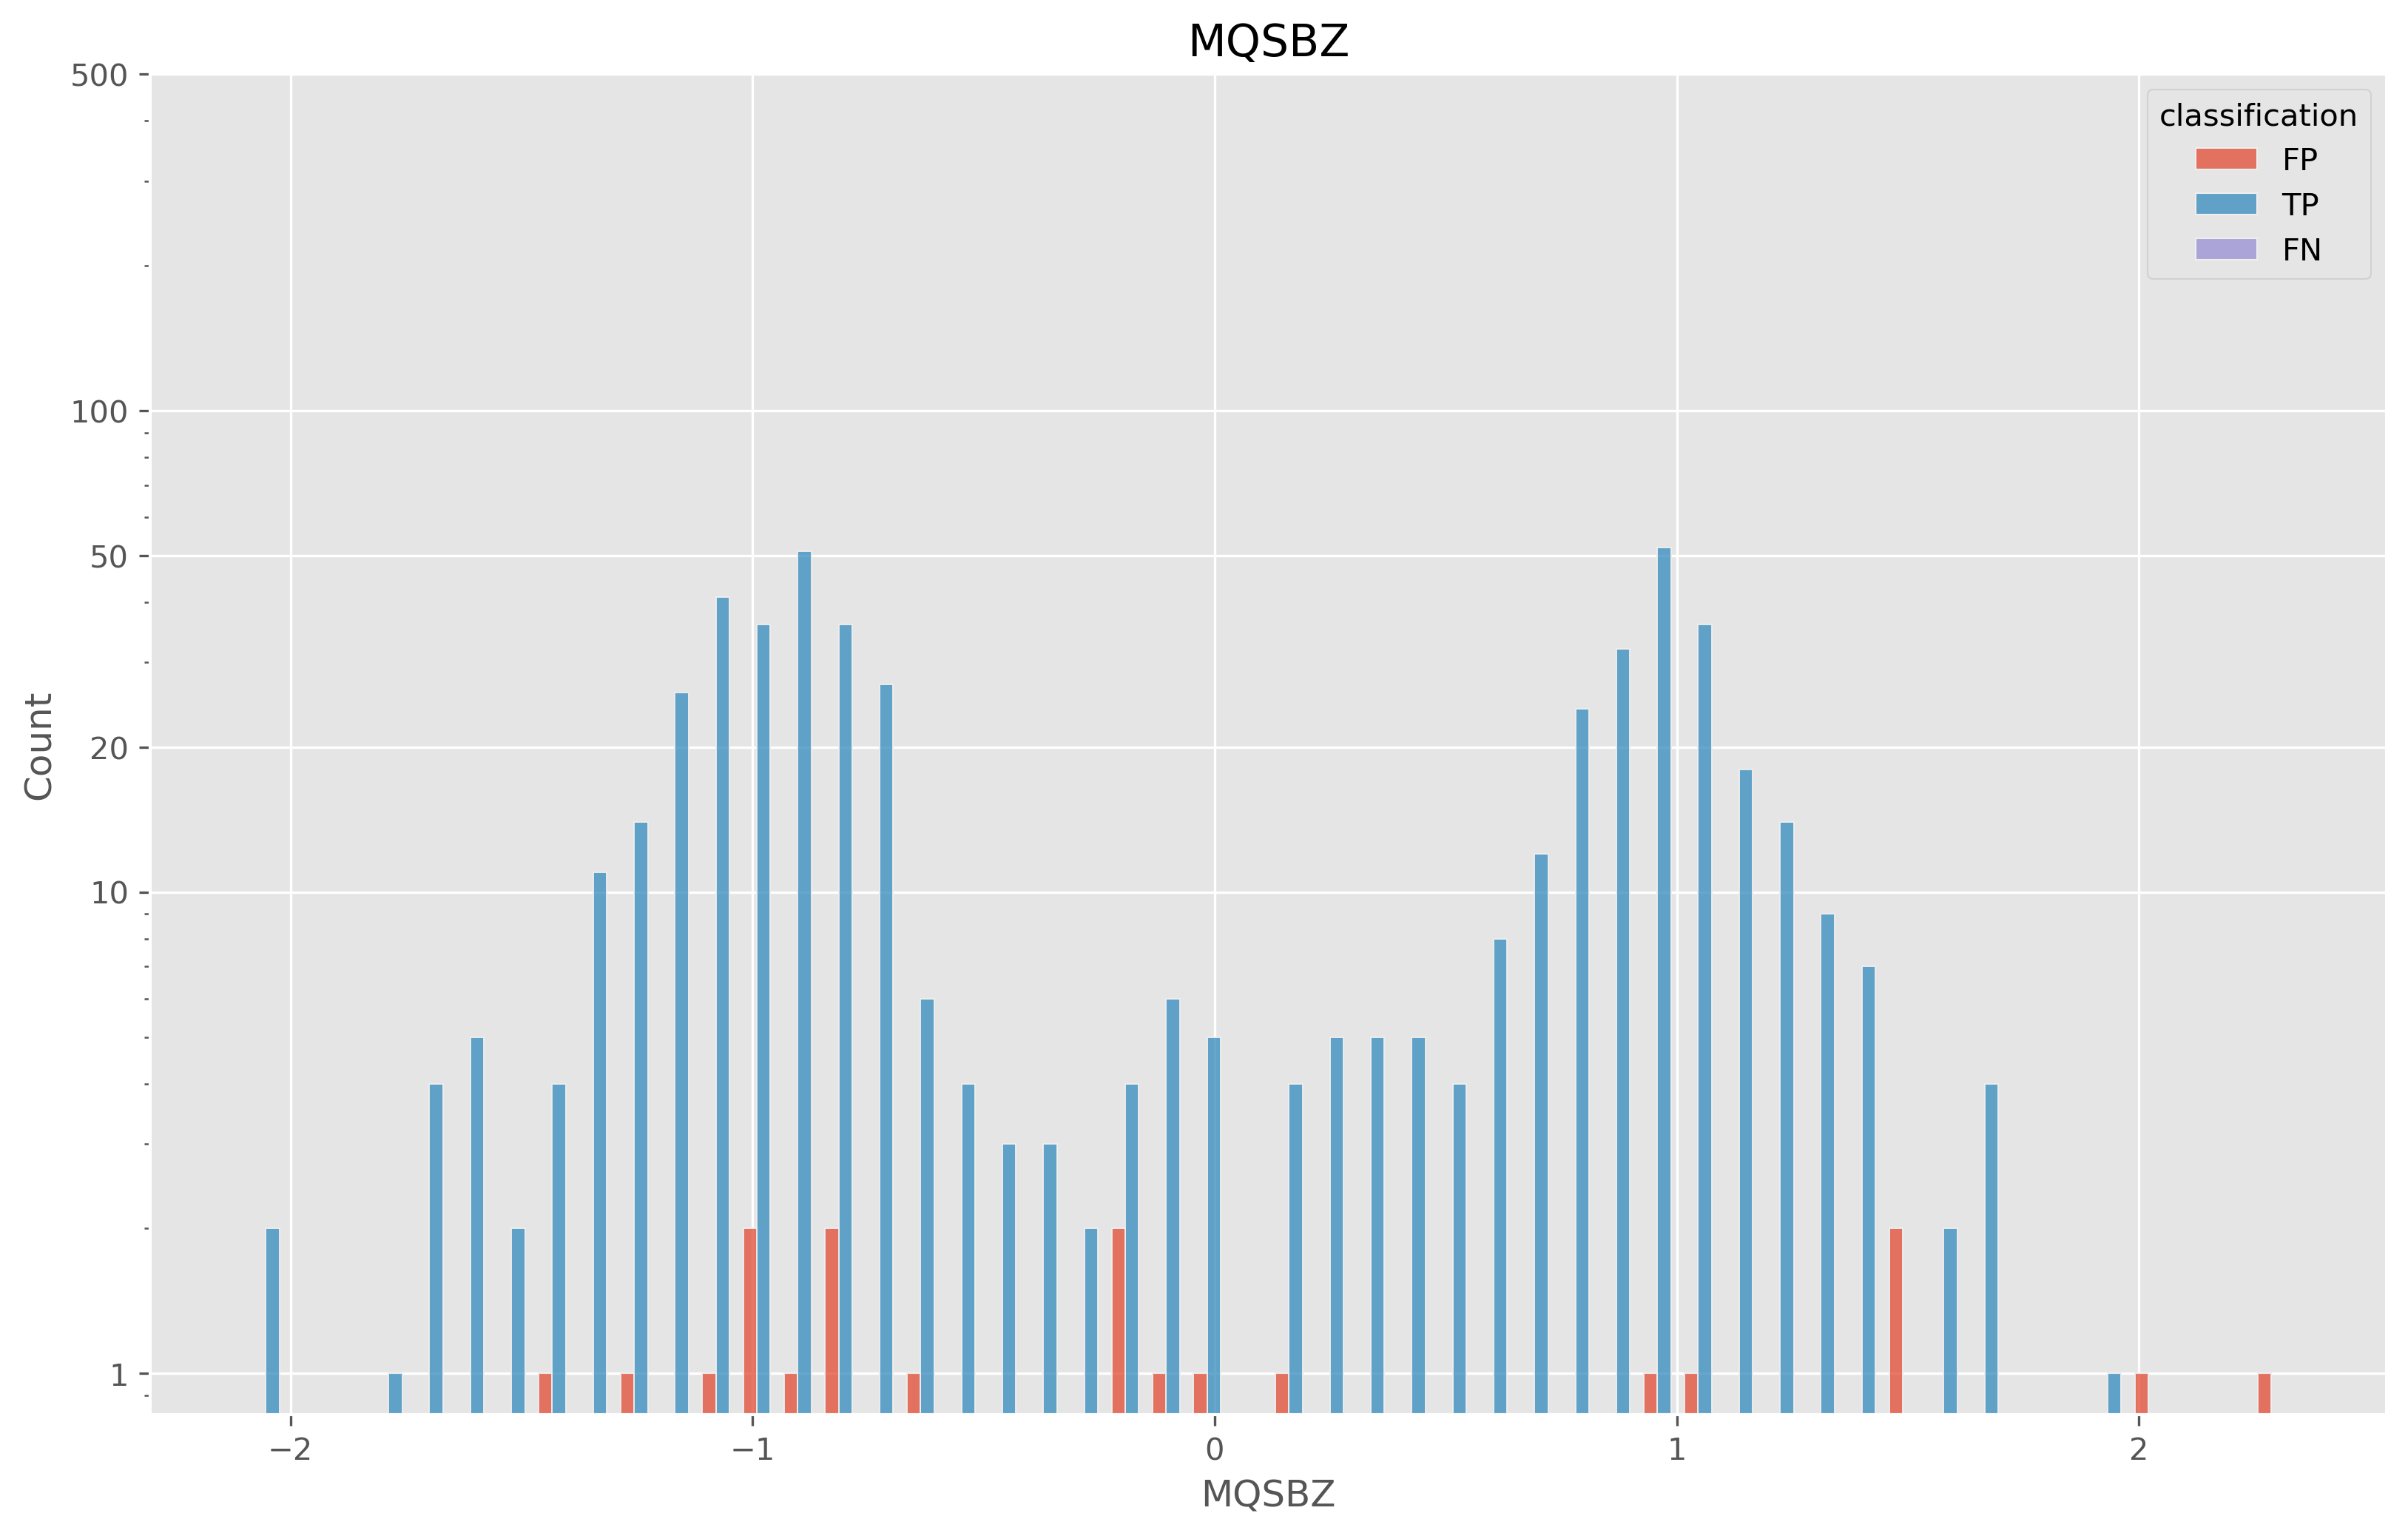

In [158]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "MQSBZ"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.4))
_=ax.set_title(x)

In [159]:
print(len(df.query("MQ<50 and classification=='TP'")))
print(len(df.query("MQ<50 and classification=='FP'")))

2
0


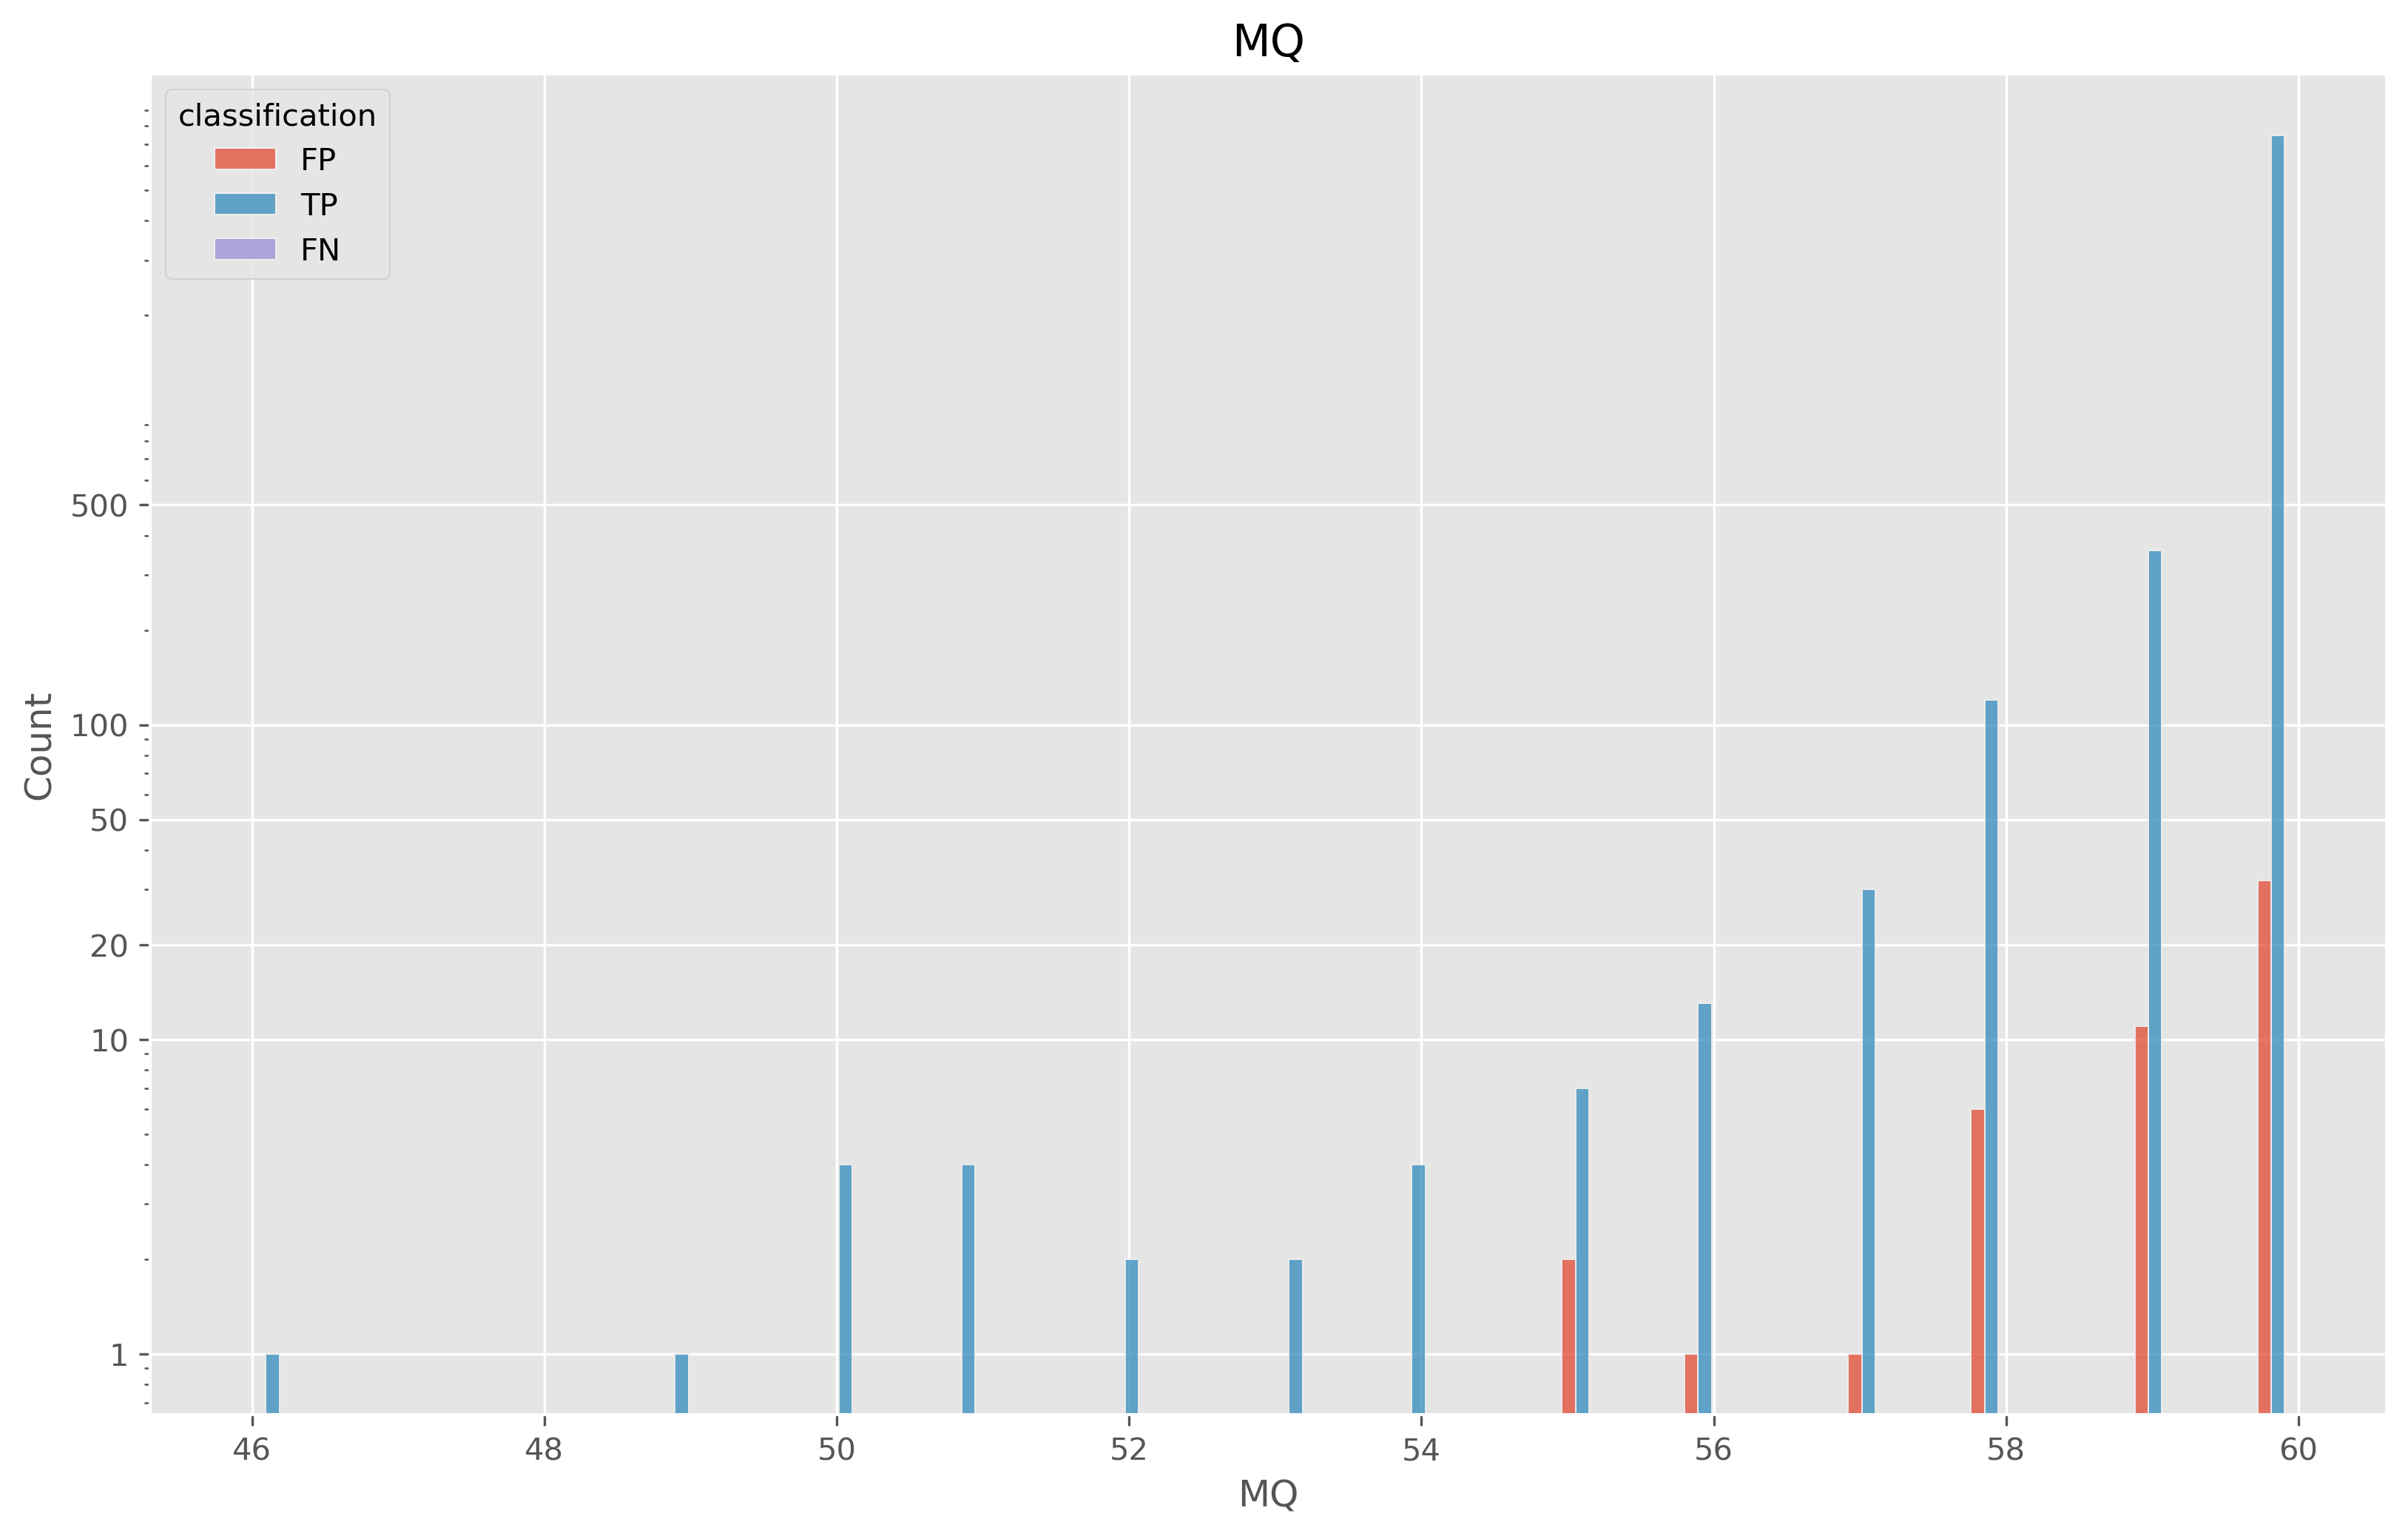

In [160]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "MQ"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.4))
_=ax.set_title(x)

In [175]:
print(len(df.query(f"VDB<0.0001 and classification=='TP'")))
print(len(df.query(f"VDB<0.0001 and classification=='FP'")))

13
3


##### 

In [169]:
f"{1e-5:.7f}"

'0.0000100'

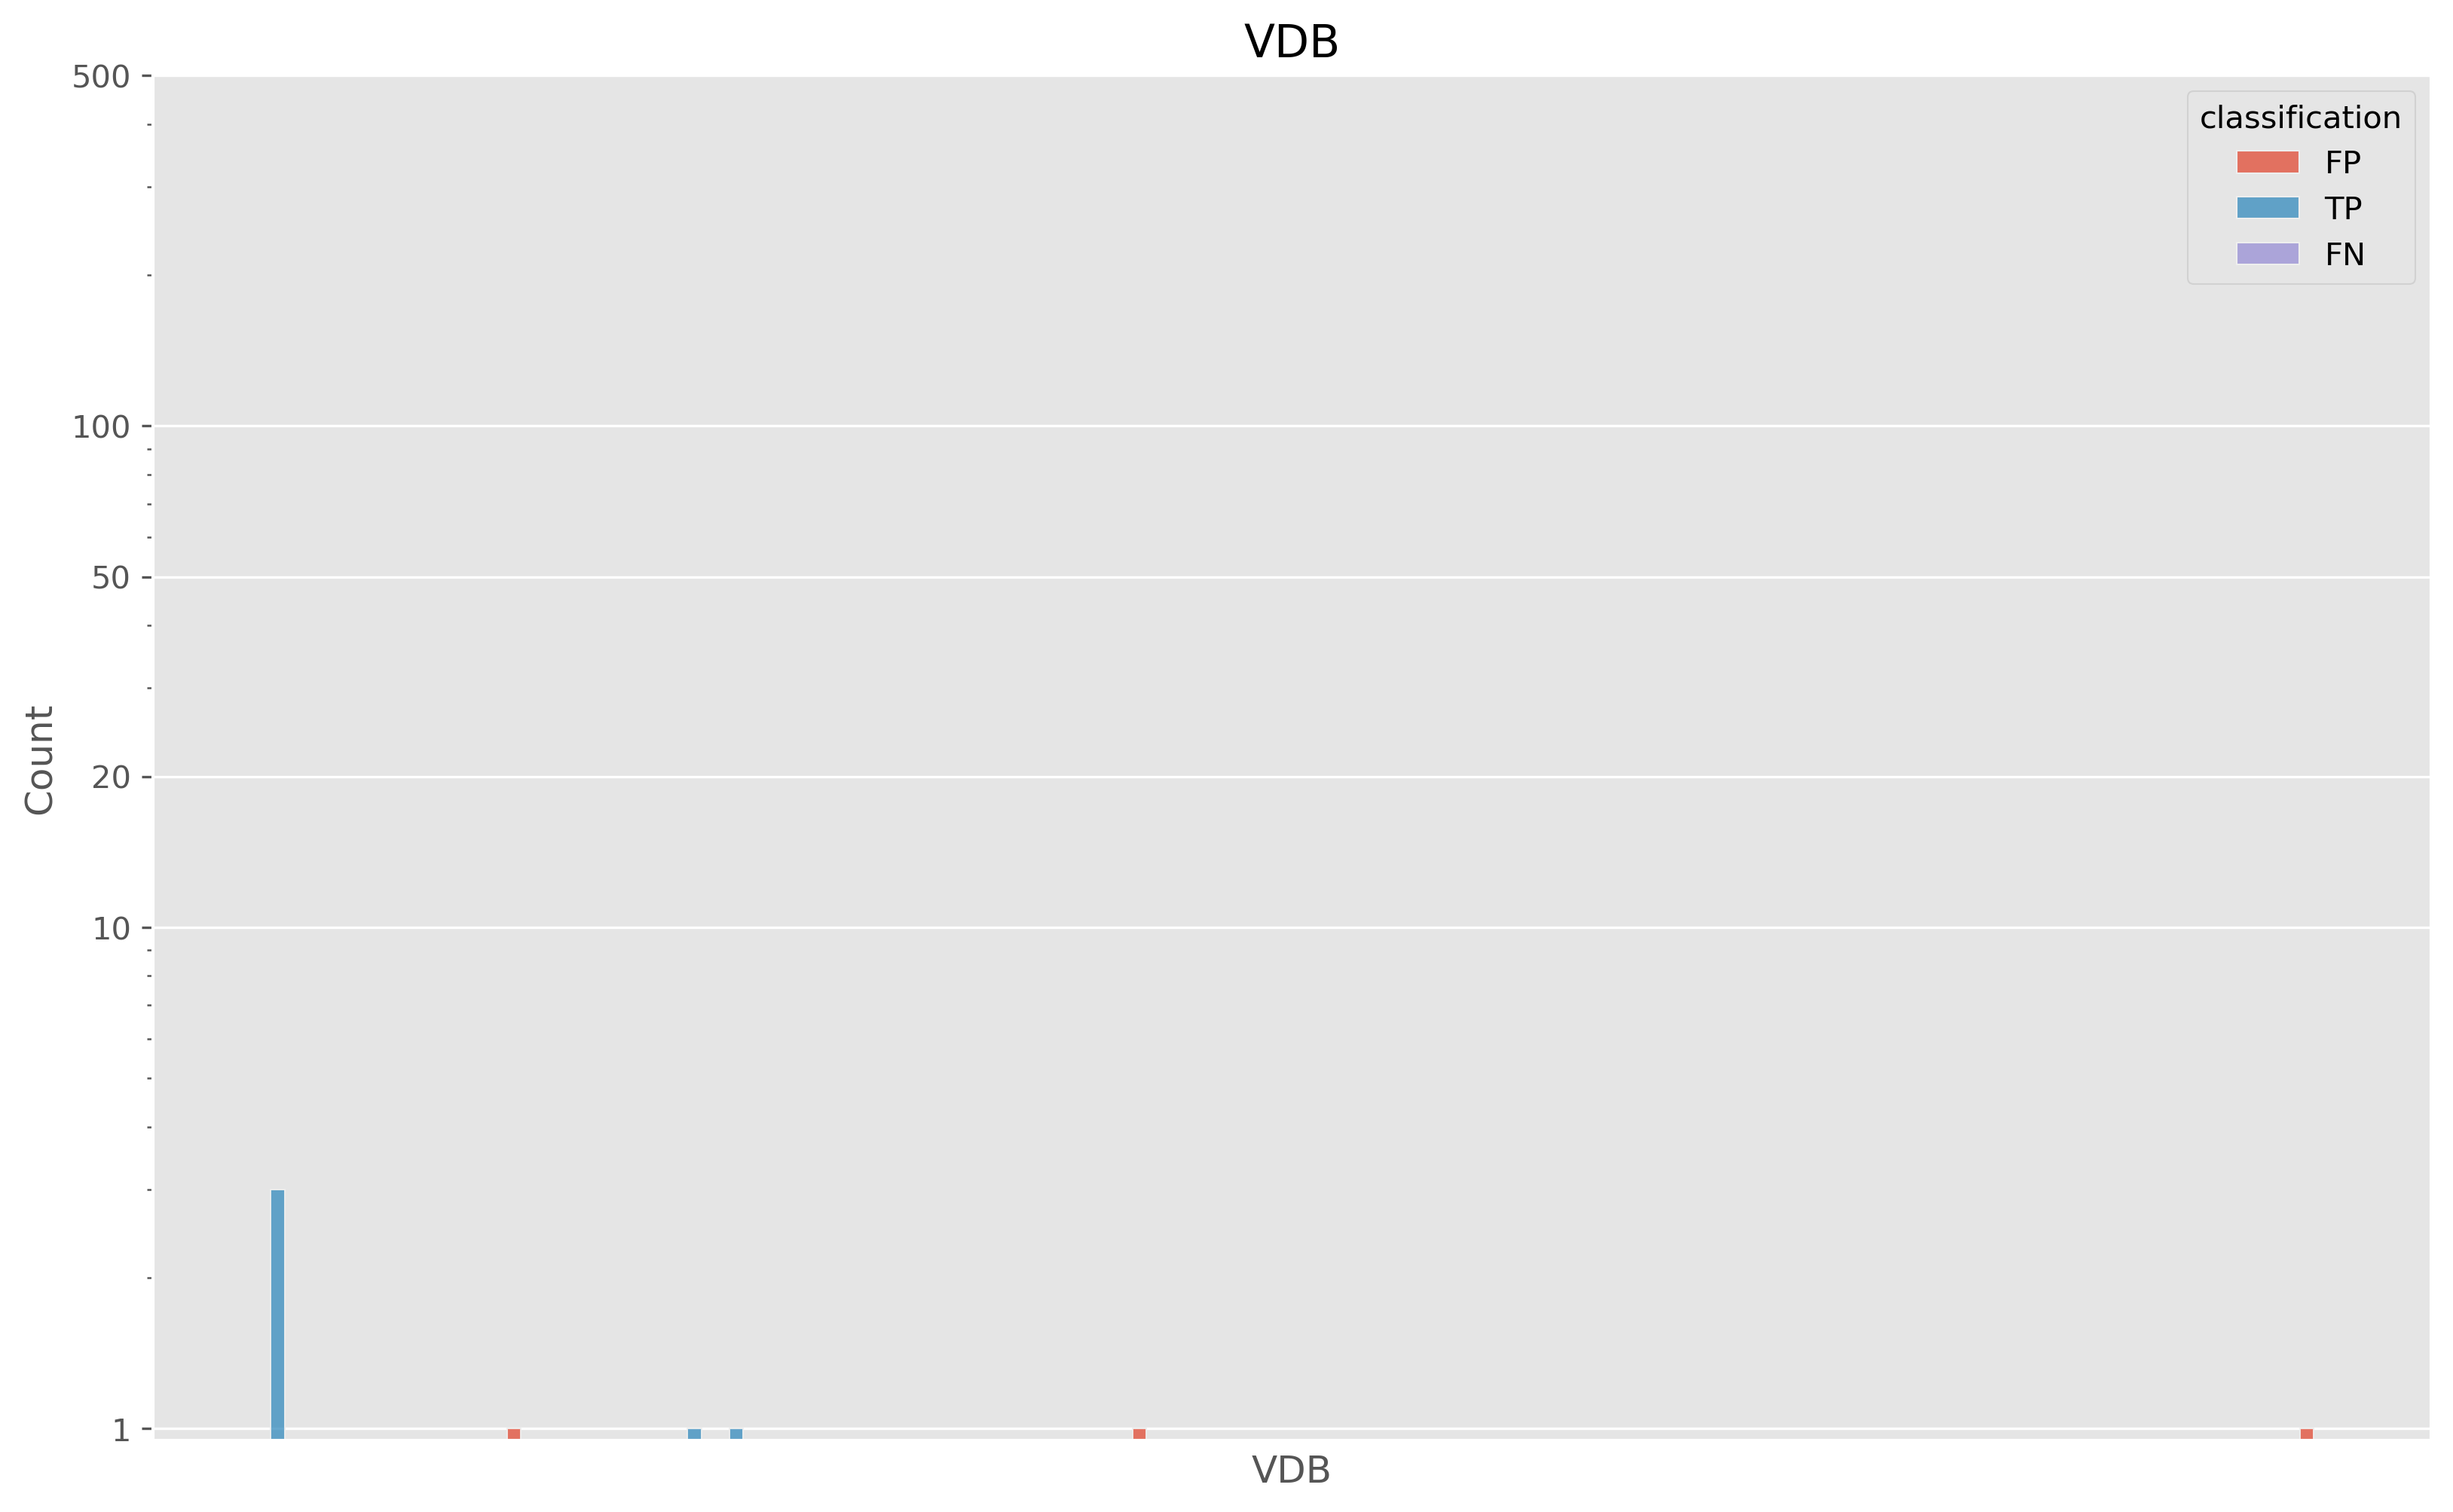

In [171]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "VDB"
sns.histplot(data=df.query("VDB<0.00001"), x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
xlabs = [1e-5]
ax.set_xticks(xlabs)
ax.set_xticklabels(xlabs)
# ax.set_xlim((0, 0.4))
_=ax.set_title(x)

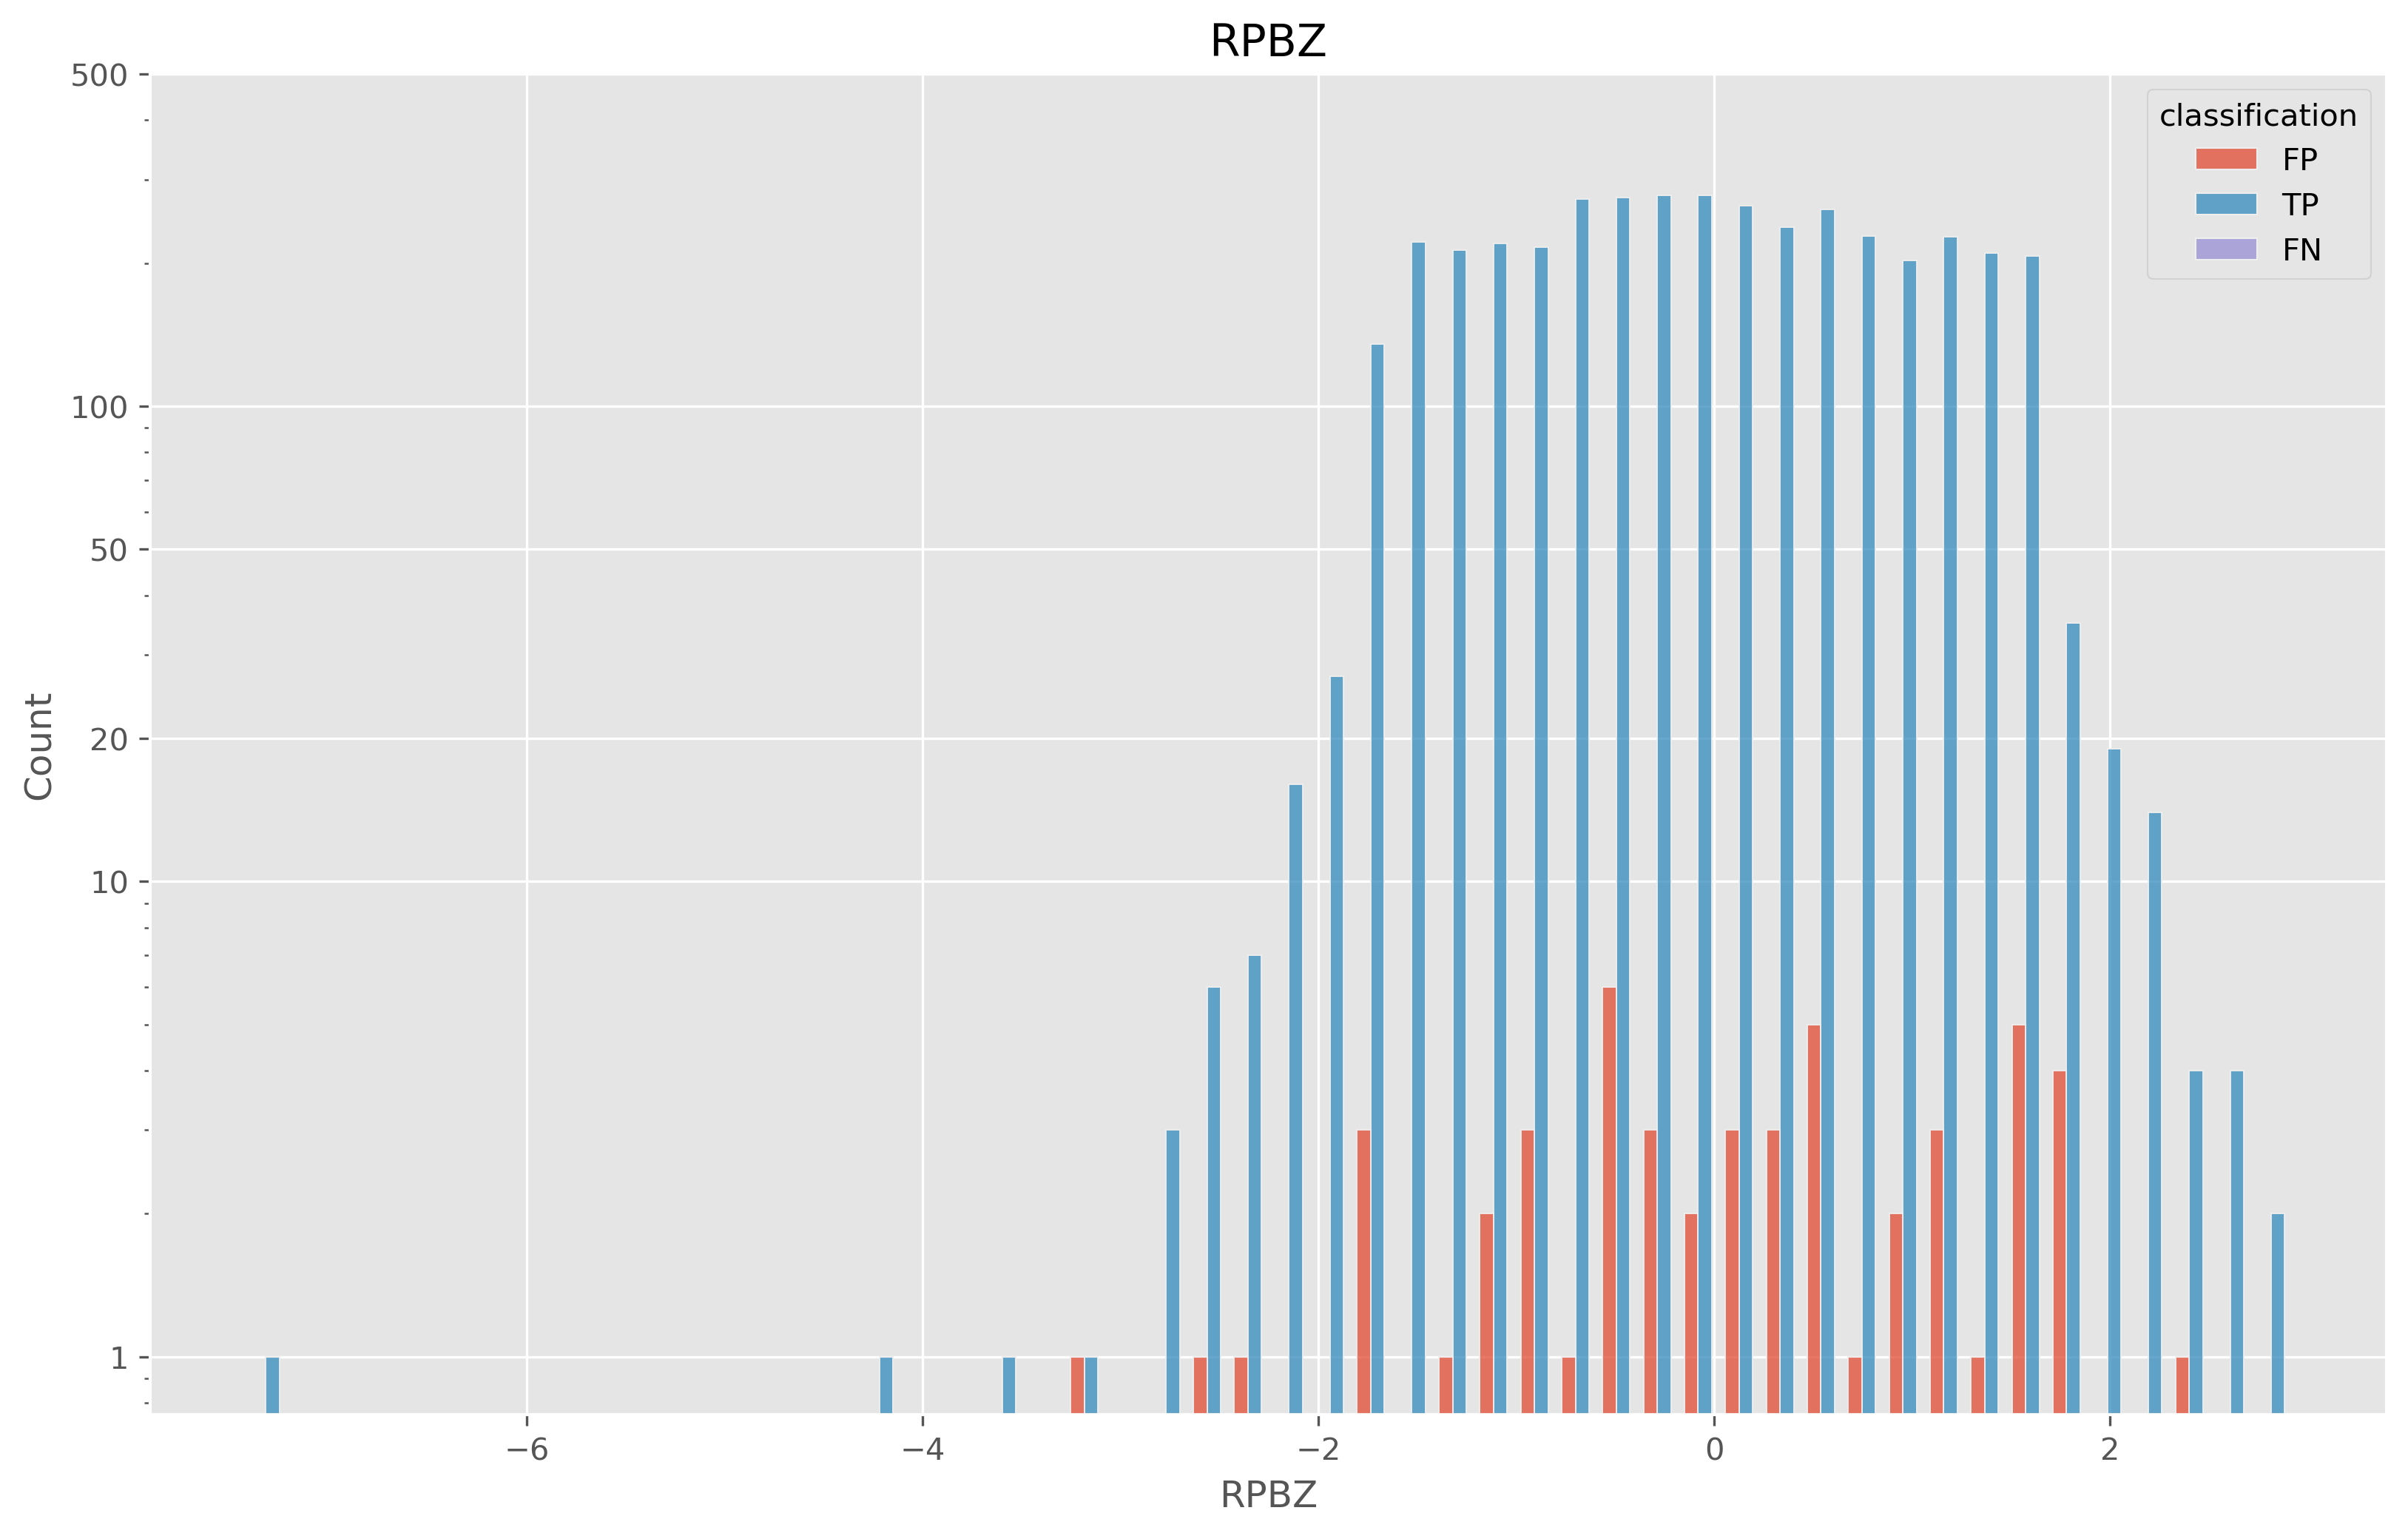

In [481]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "RPBZ"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.4))
_=ax.set_title(x)

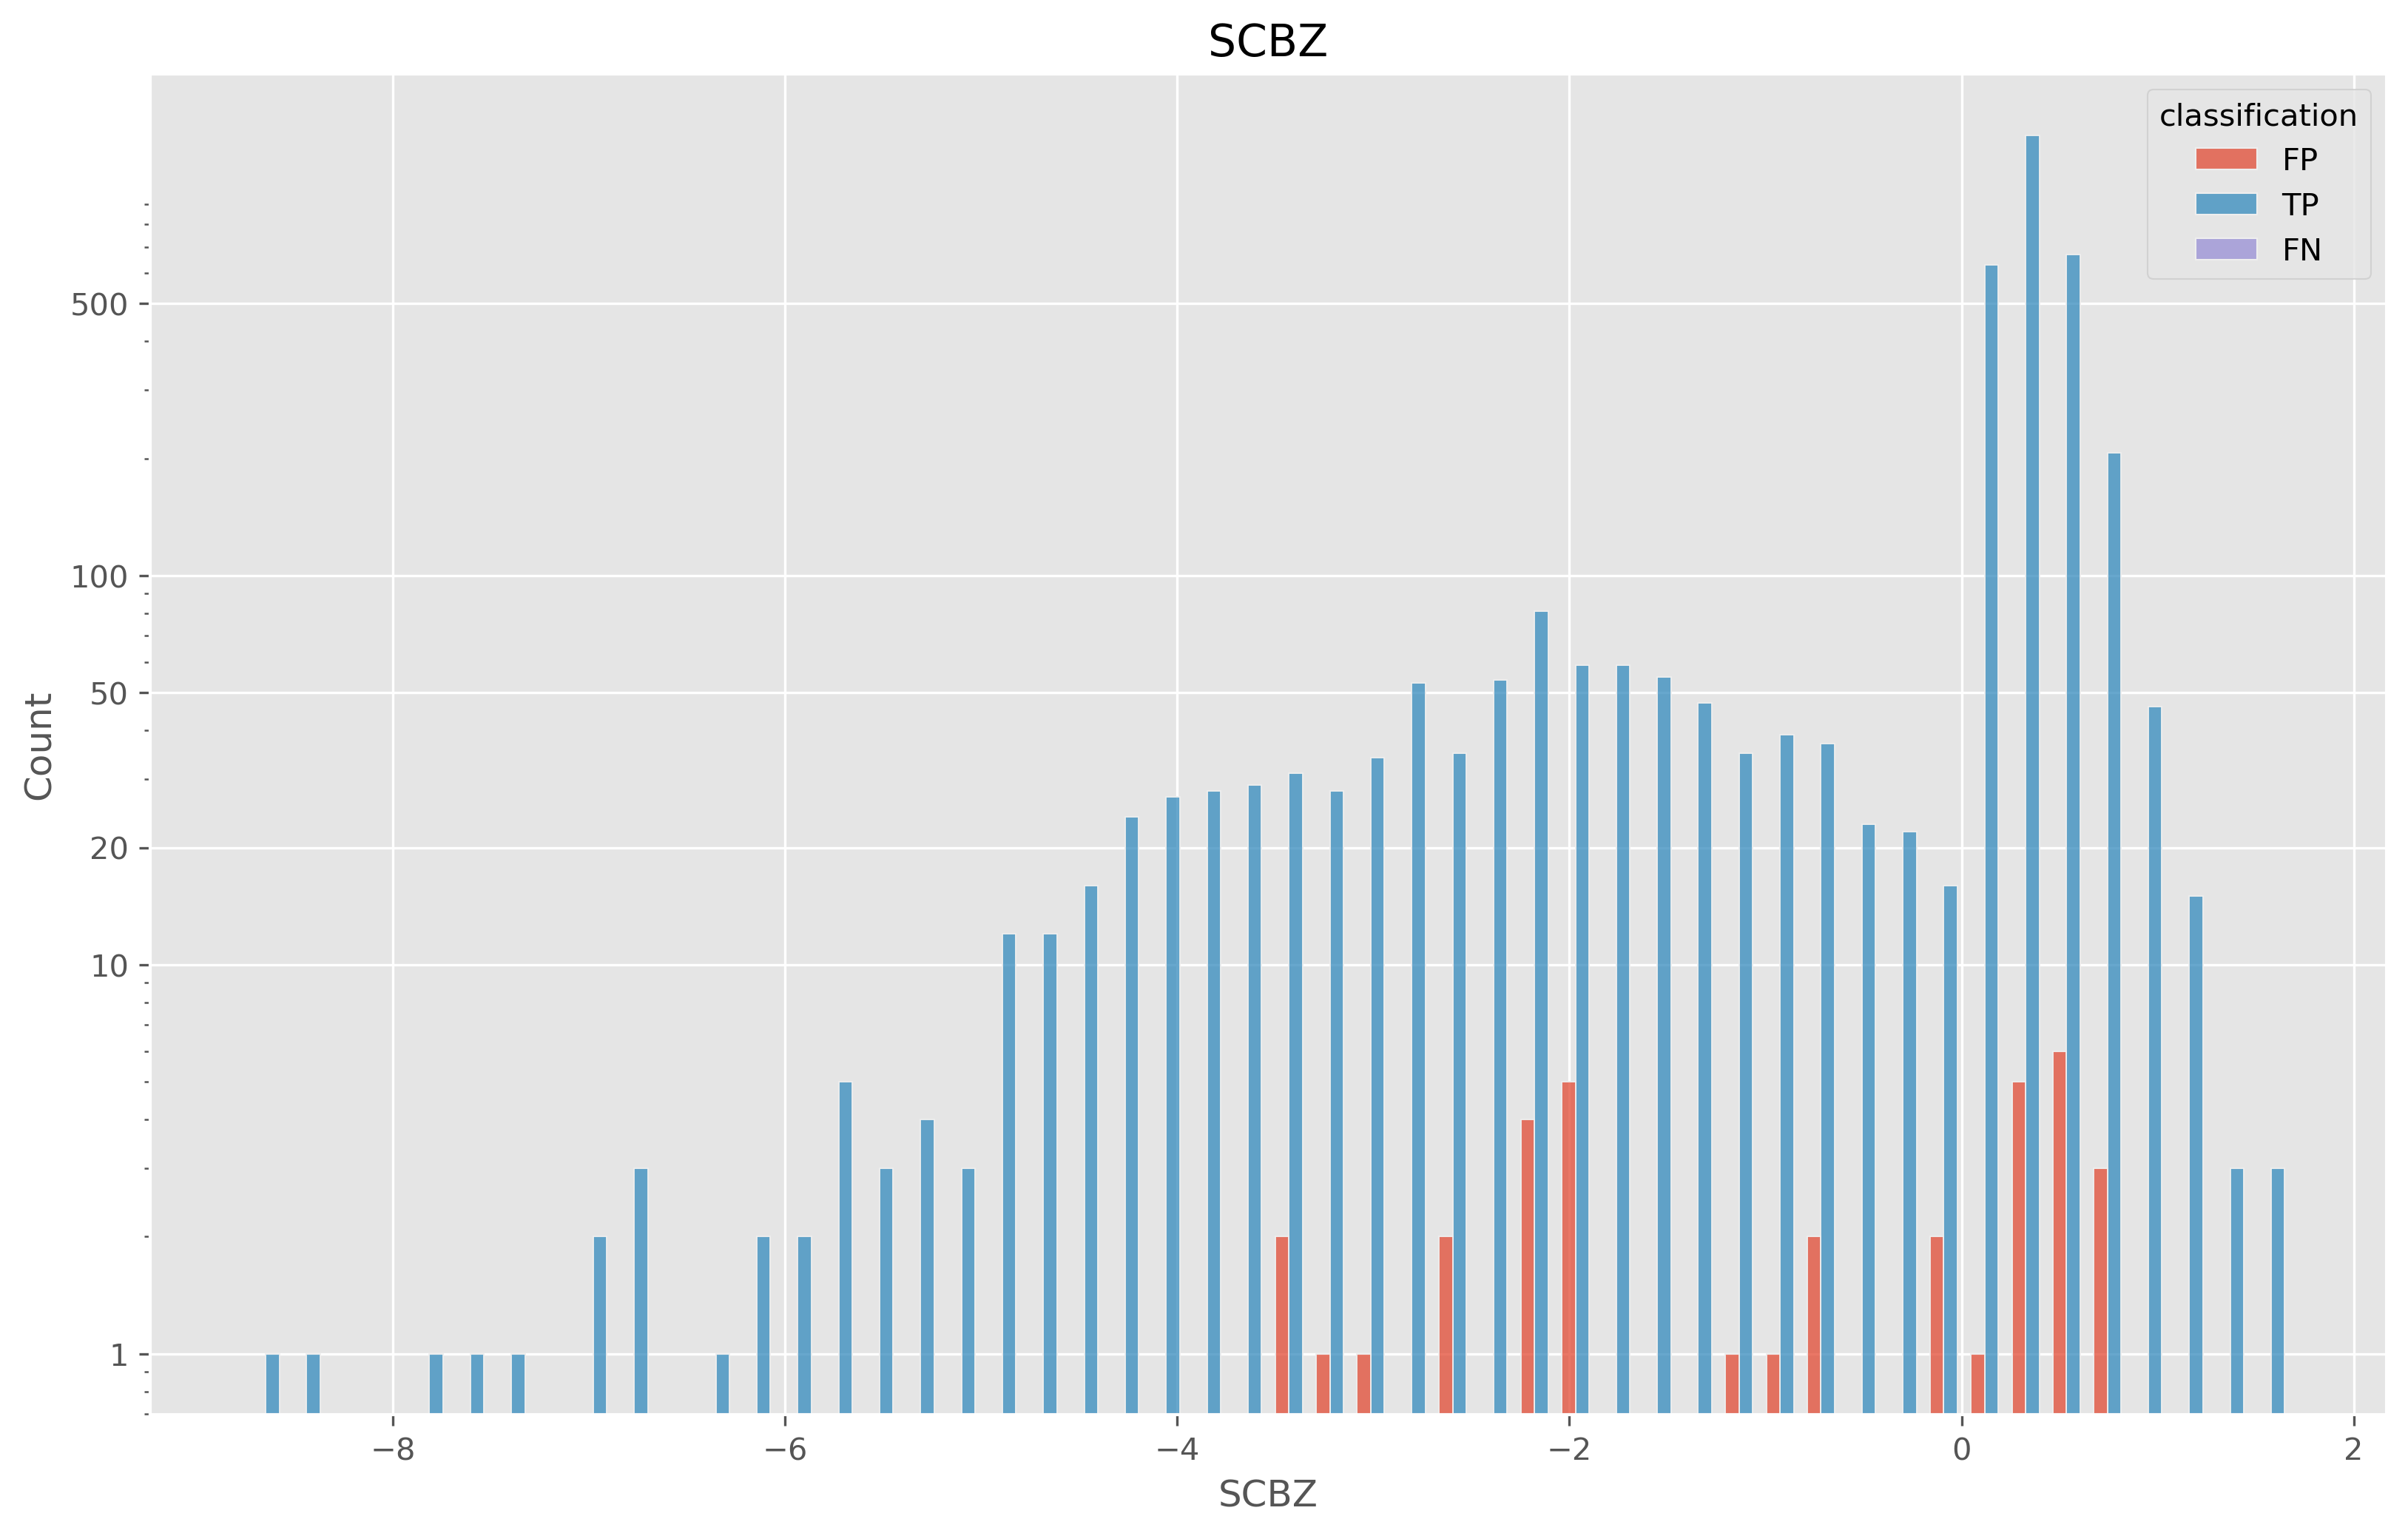

In [79]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "SCBZ"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.4))
_=ax.set_title(x)

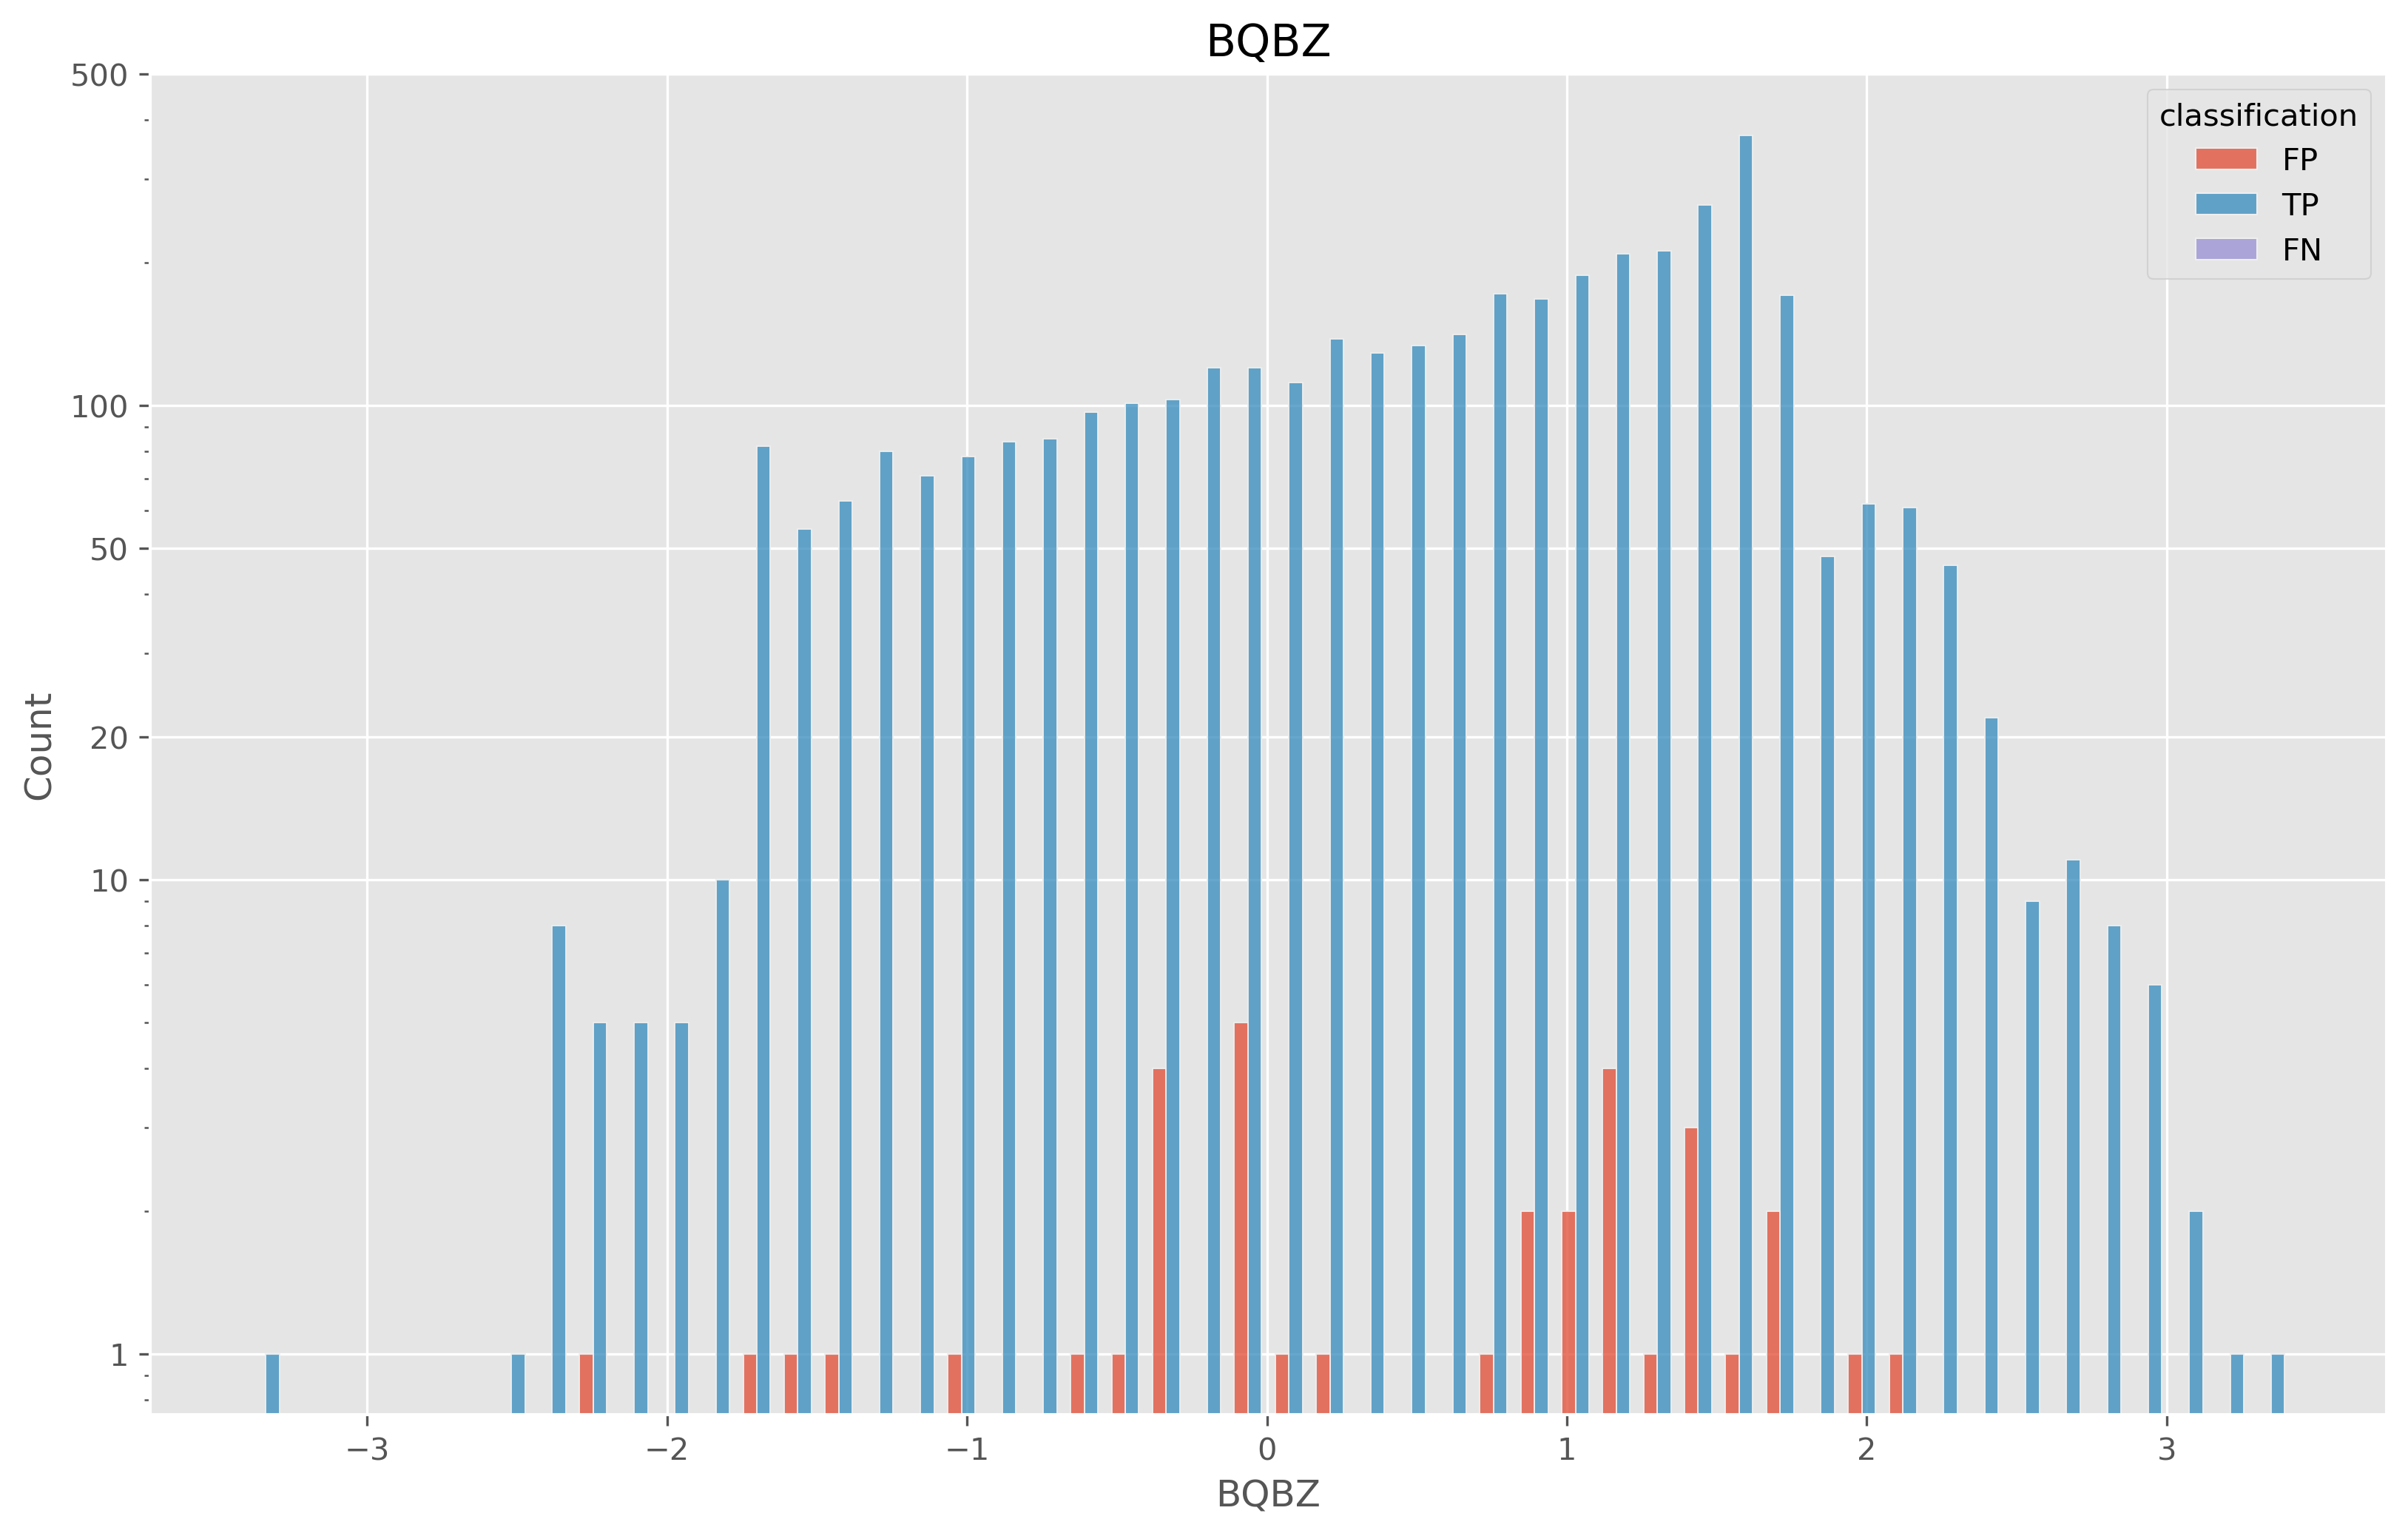

In [80]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "BQBZ"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.4))
_=ax.set_title(x)

In [441]:
print(len(df.query("SGB>-0.6 and classification=='TP'")))
print(len(df.query("SGB>-0.6 and classification=='FP'")))

15
3


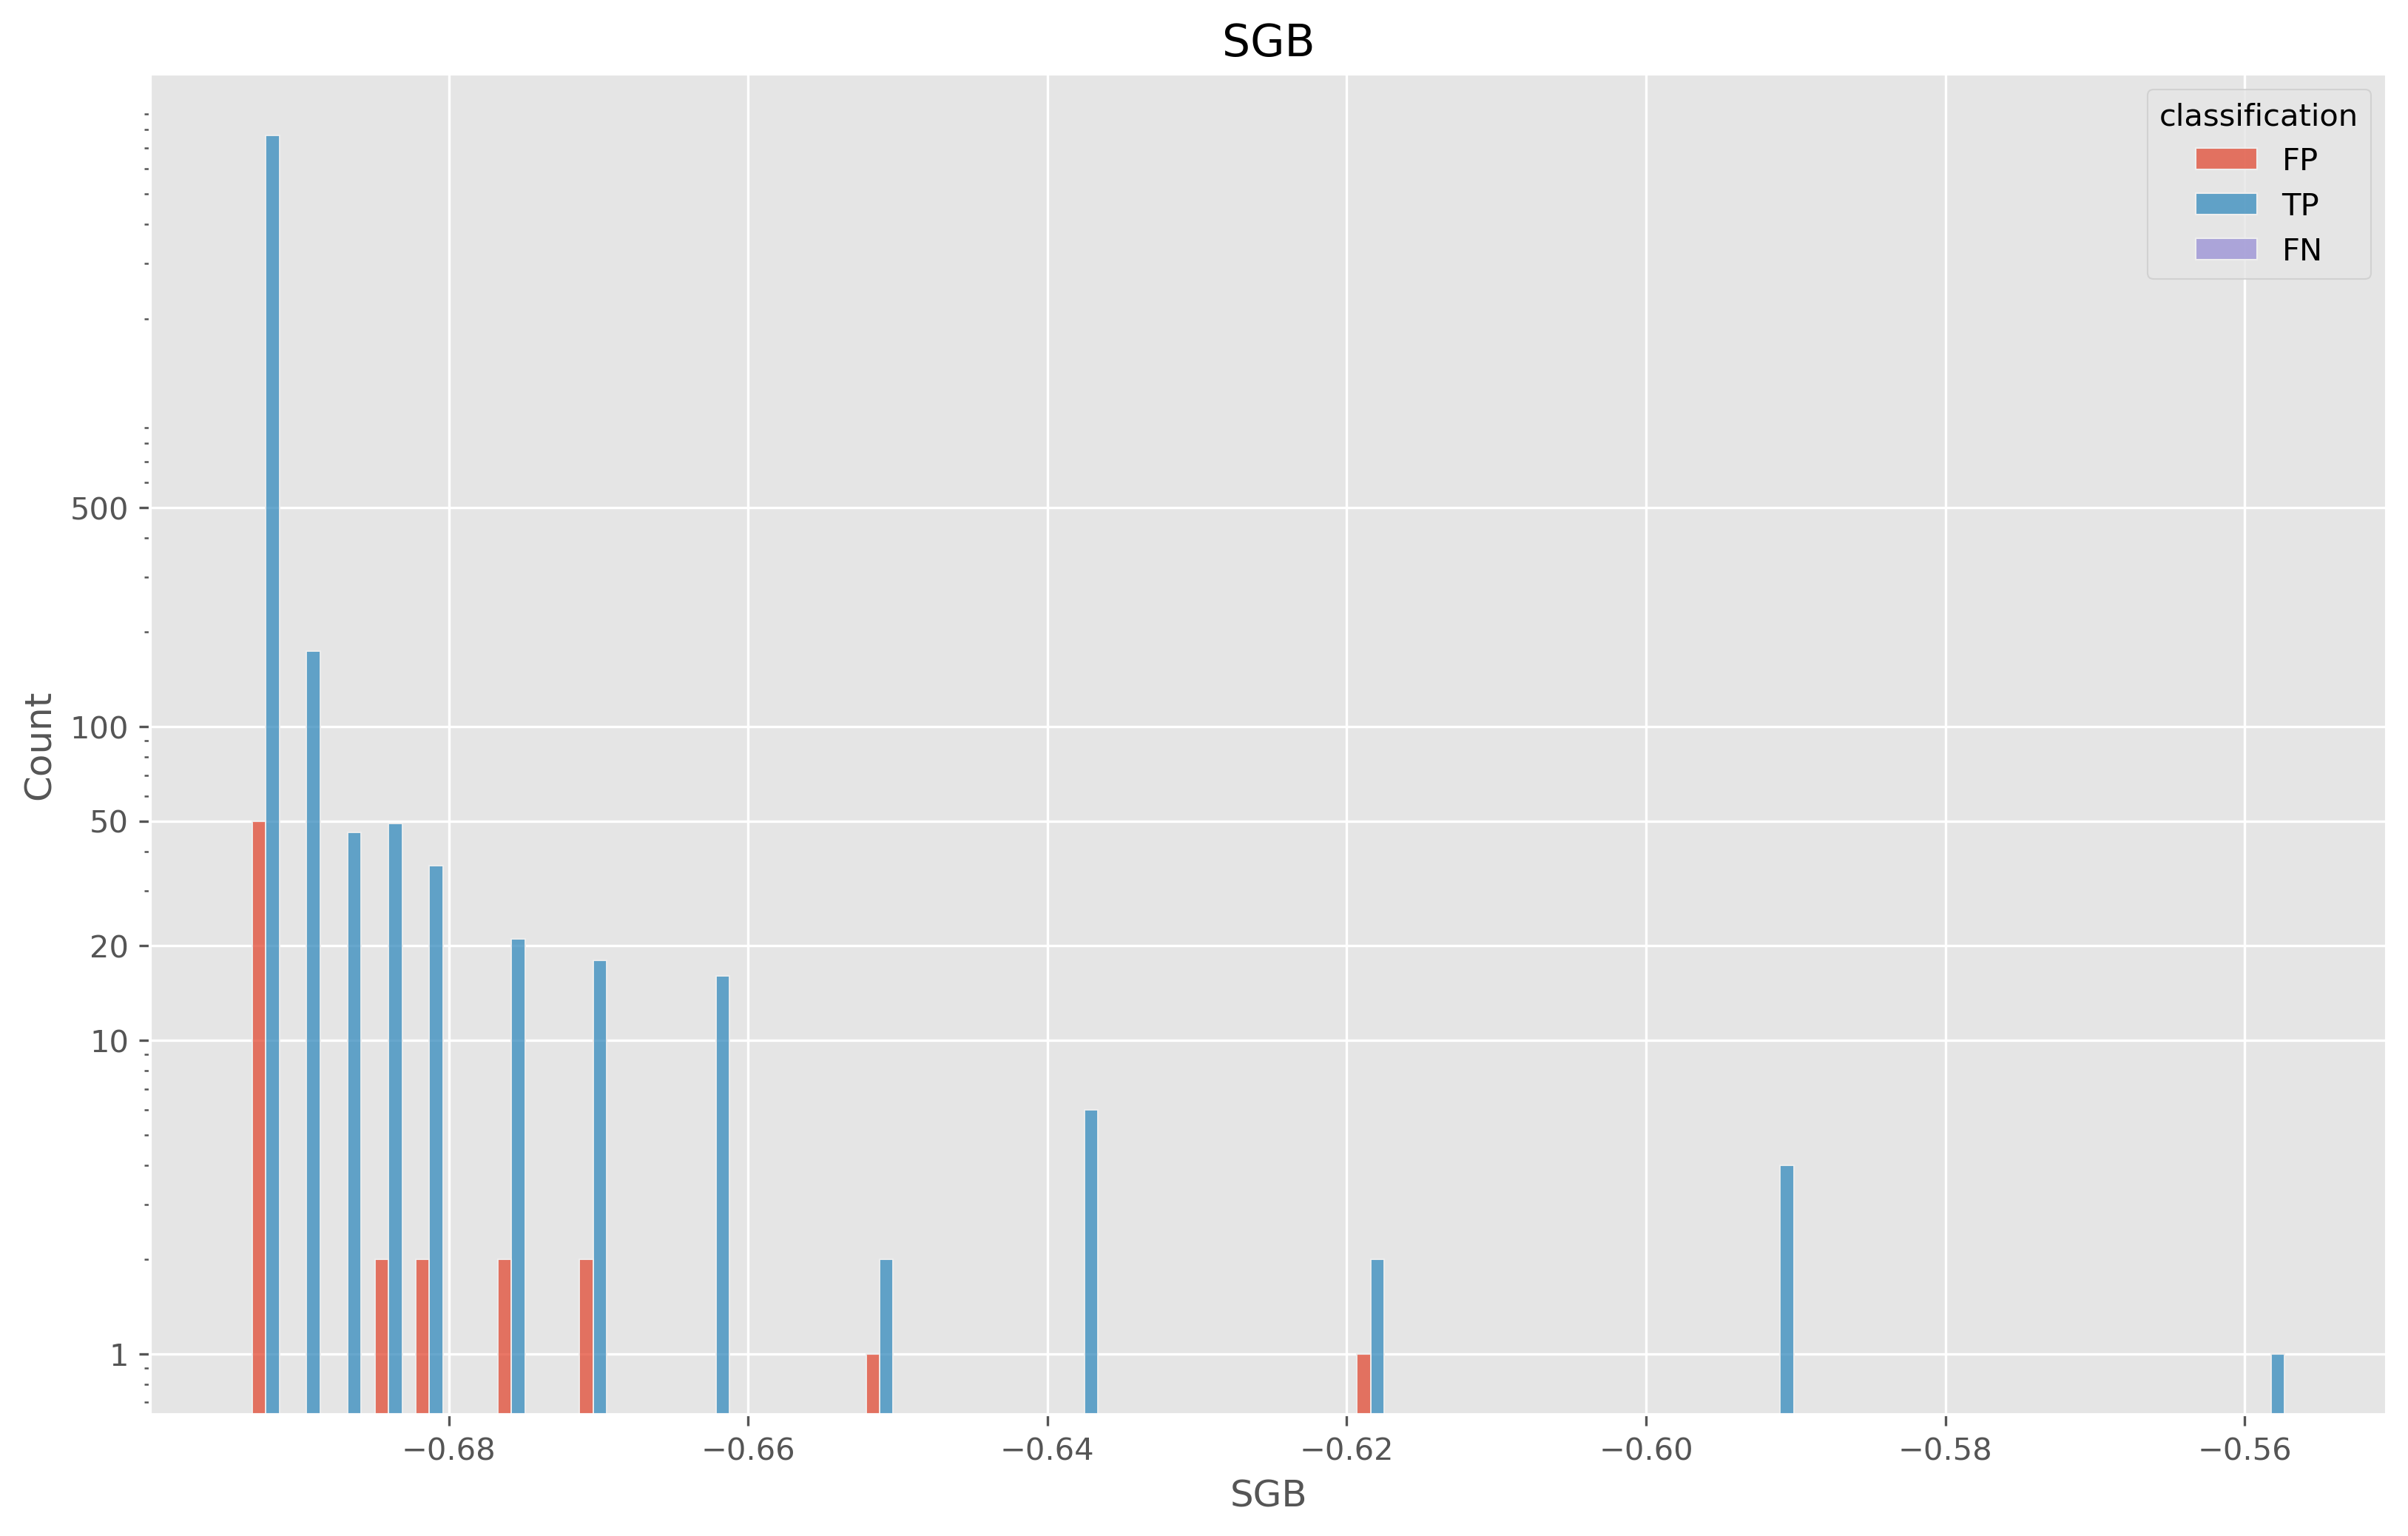

In [81]:
hue_order = ["FP", "TP", "FN"]
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "classification"
x = "SGB"
sns.histplot(data=df, x=x, hue=hue, ax=ax, hue_order=hue_order, multiple="dodge", bins=50)
ax.set_yscale("log")
ylabs = [1, 10, 20, 50, 100, 500]
ax.set_yticks(ylabs)
ax.set_yticklabels(ylabs)
# ax.set_xlim((0, 0.4))
_=ax.set_title(x)

In [195]:
columns

['sample',
 'pos',
 'classification',
 'quality',
 'FRS',
 'HQDP',
 'SB',
 'SP',
 'FED',
 'HQFED',
 'SCR',
 'SCRF',
 'MQSBZ',
 'MQ',
 'VDB',
 'RPBZ',
 'SCBZ',
 'BQBZ',
 'SGB',
 'DP']

In [286]:
df.query("SGB>-0.5")

,sample,pos,classification,quality,FRS,HQDP,SB,SP,FED,HQFED,SCR,SCRF,MQSBZ,MQ,VDB,RPBZ,SCBZ,BQBZ,SGB,DP
103,mada_1-44,180170,FP,6.512480,1.0,1,0.0,0,0.022901,0.007634,115,0.877863,NaN,60.0,NaN,NaN,NaN,NaN,-0.379885,3
270,mada_1-44,532513,FP,3.224508,1.0,1,0.0,0,0.007634,0.007634,104,0.793893,NaN,60.0,NaN,NaN,NaN,NaN,-0.379885,1
404,mada_1-44,820702,FP,4.384660,1.0,2,0.0,0,0.045802,0.015267,98,0.748092,NaN,60.0,0.64,NaN,NaN,NaN,-0.453602,6
1727,mada_1-44,4092921,FP,12.656574,1.0,2,0.5,0,0.038168,0.015267,77,0.587786,NaN,60.0,0.10,NaN,NaN,NaN,-0.453602,5
2637,mada_102,3379884,TP,18.476357,1.0,2,0.5,0,0.088435,0.013605,63,0.428571,NaN,60.0,0.36,NaN,NaN,NaN,-0.453602,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8908,mada_132,1996022,FP,27.422153,1.0,2,0.5,0,0.066667,0.066667,1,0.033333,1.0,31.0,0.38,NaN,NaN,NaN,-0.453602,2
8909,mada_132,1996024,FP,27.422153,1.0,2,0.5,0,0.066667,0.066667,1,0.033333,1.0,31.0,0.38,NaN,NaN,NaN,-0.453602,2
8910,mada_132,1996035,FP,15.537348,1.0,2,0.5,0,0.066667,0.066667,1,0.033333,1.0,31.0,0.38,NaN,NaN,NaN,-0.453602,2
8911,mada_132,1996036,FP,15.537348,1.0,2,0.5,0,0.066667,0.066667,1,0.033333,1.0,31.0,0.38,NaN,NaN,NaN,-0.453602,2


Text(0.5, 1.0, 'VDB')

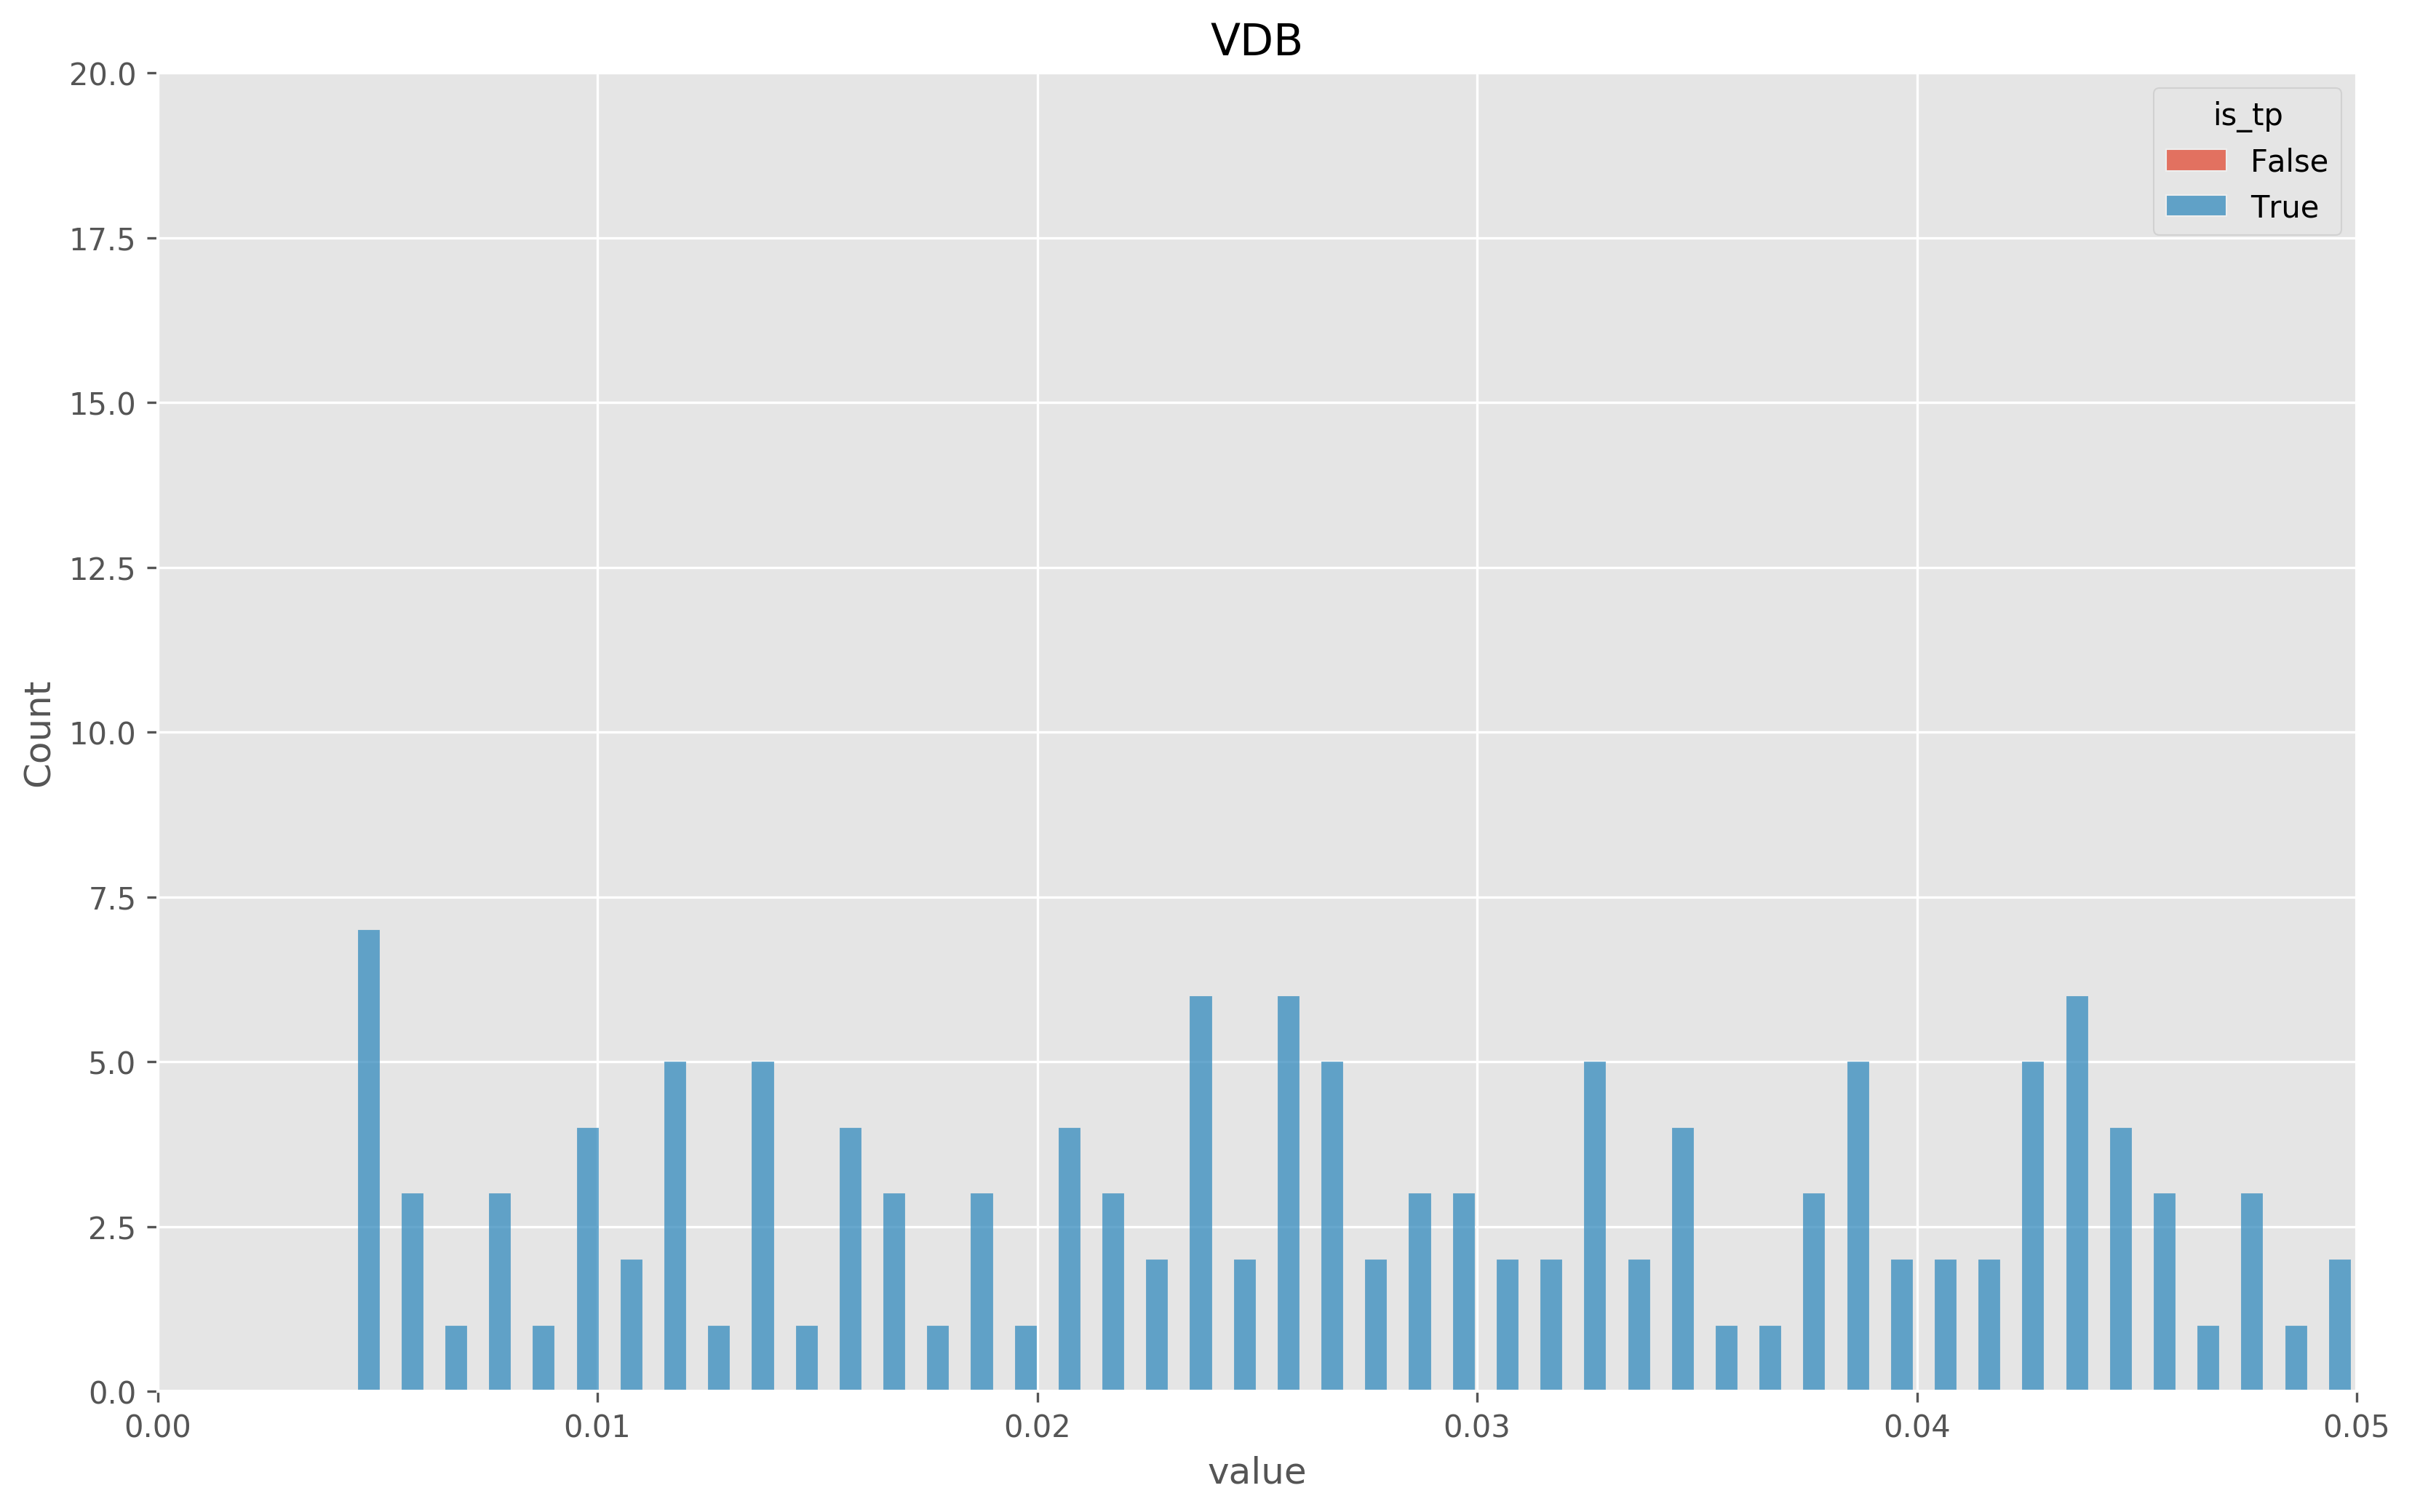

In [631]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=data, x=y, hue=x, ax=ax, multiple="dodge", bins=1000)
# sns.histplot(data=data, x=y, hue=x, ax=ax, multiple="dodge", stat="percent", common_norm=False)
ax.set_xlim((0, 0.05))
ax.set_ylim((0, 20))
# sns.violinplot(data=data, x=x, y=y, ax=ax)
ax.set_title(field)

Text(0.5, 1.0, 'MQBZ')

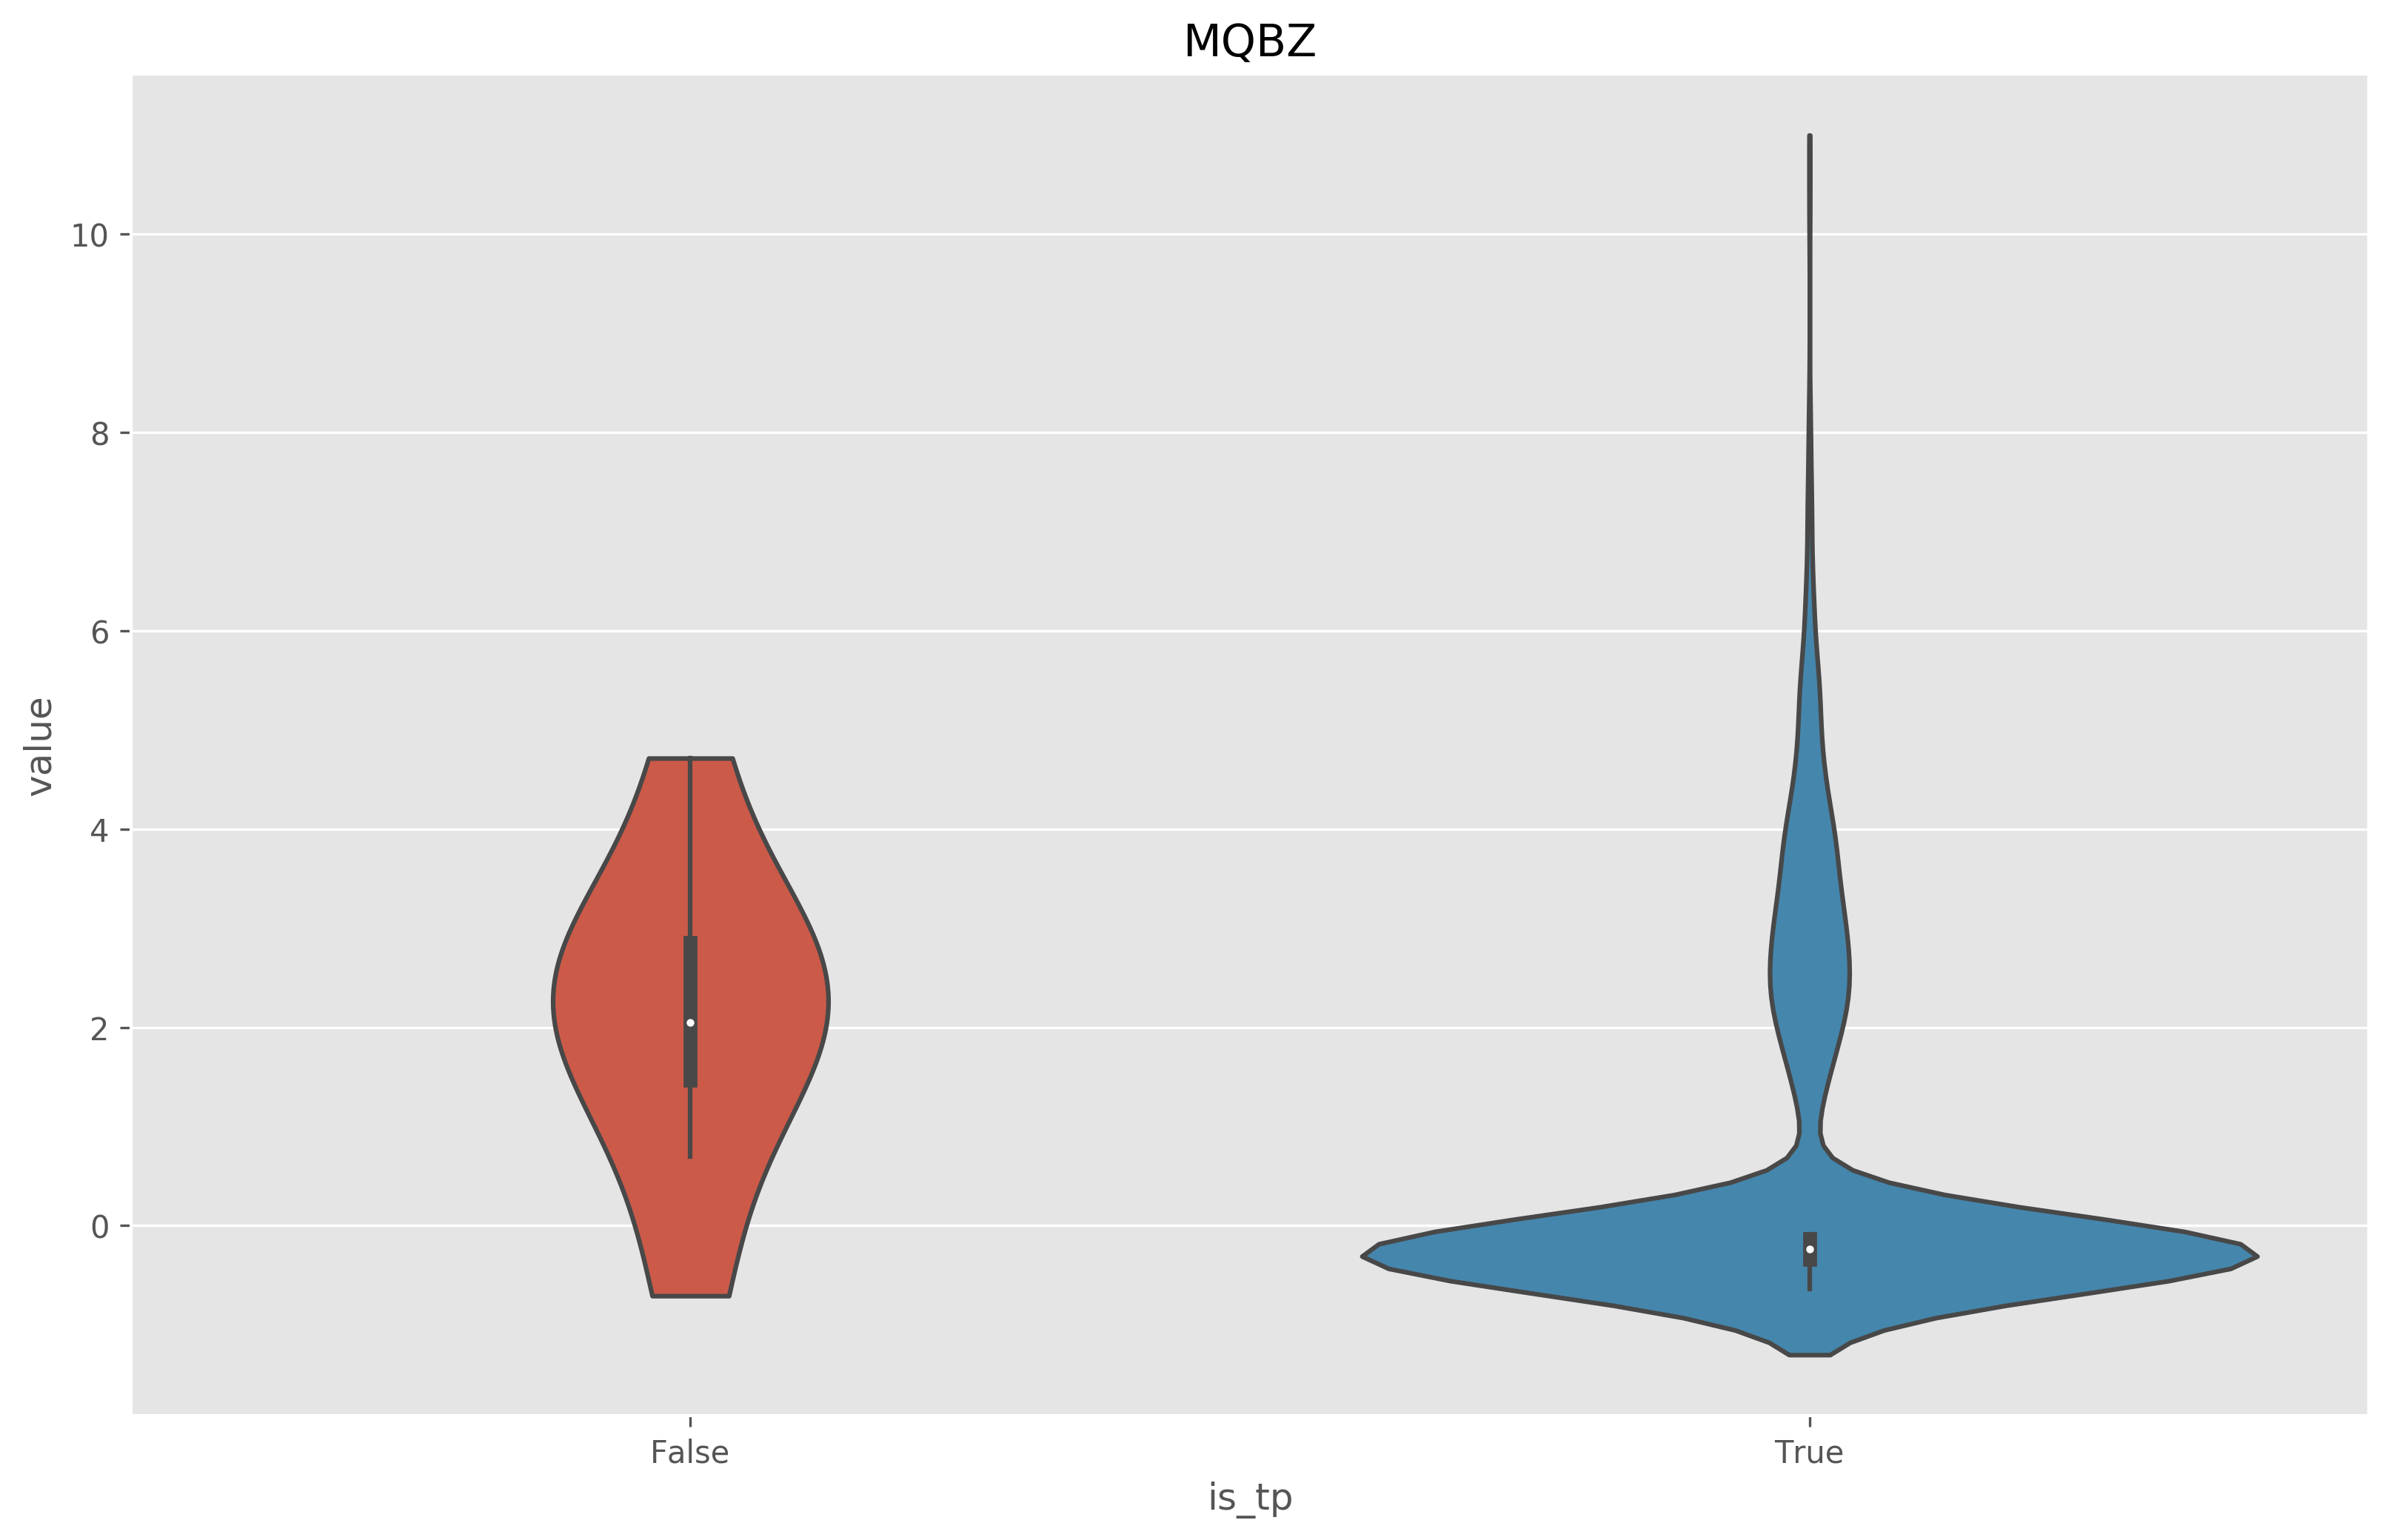

In [632]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
x = "is_tp"
y = "value"
field = info[9]
data = df.query("field==@field")
sns.violinplot(data=data, x=x, y=y, ax=ax, cut=0)
ax.set_title(field)

Text(0.5, 1.0, 'MQBZ')

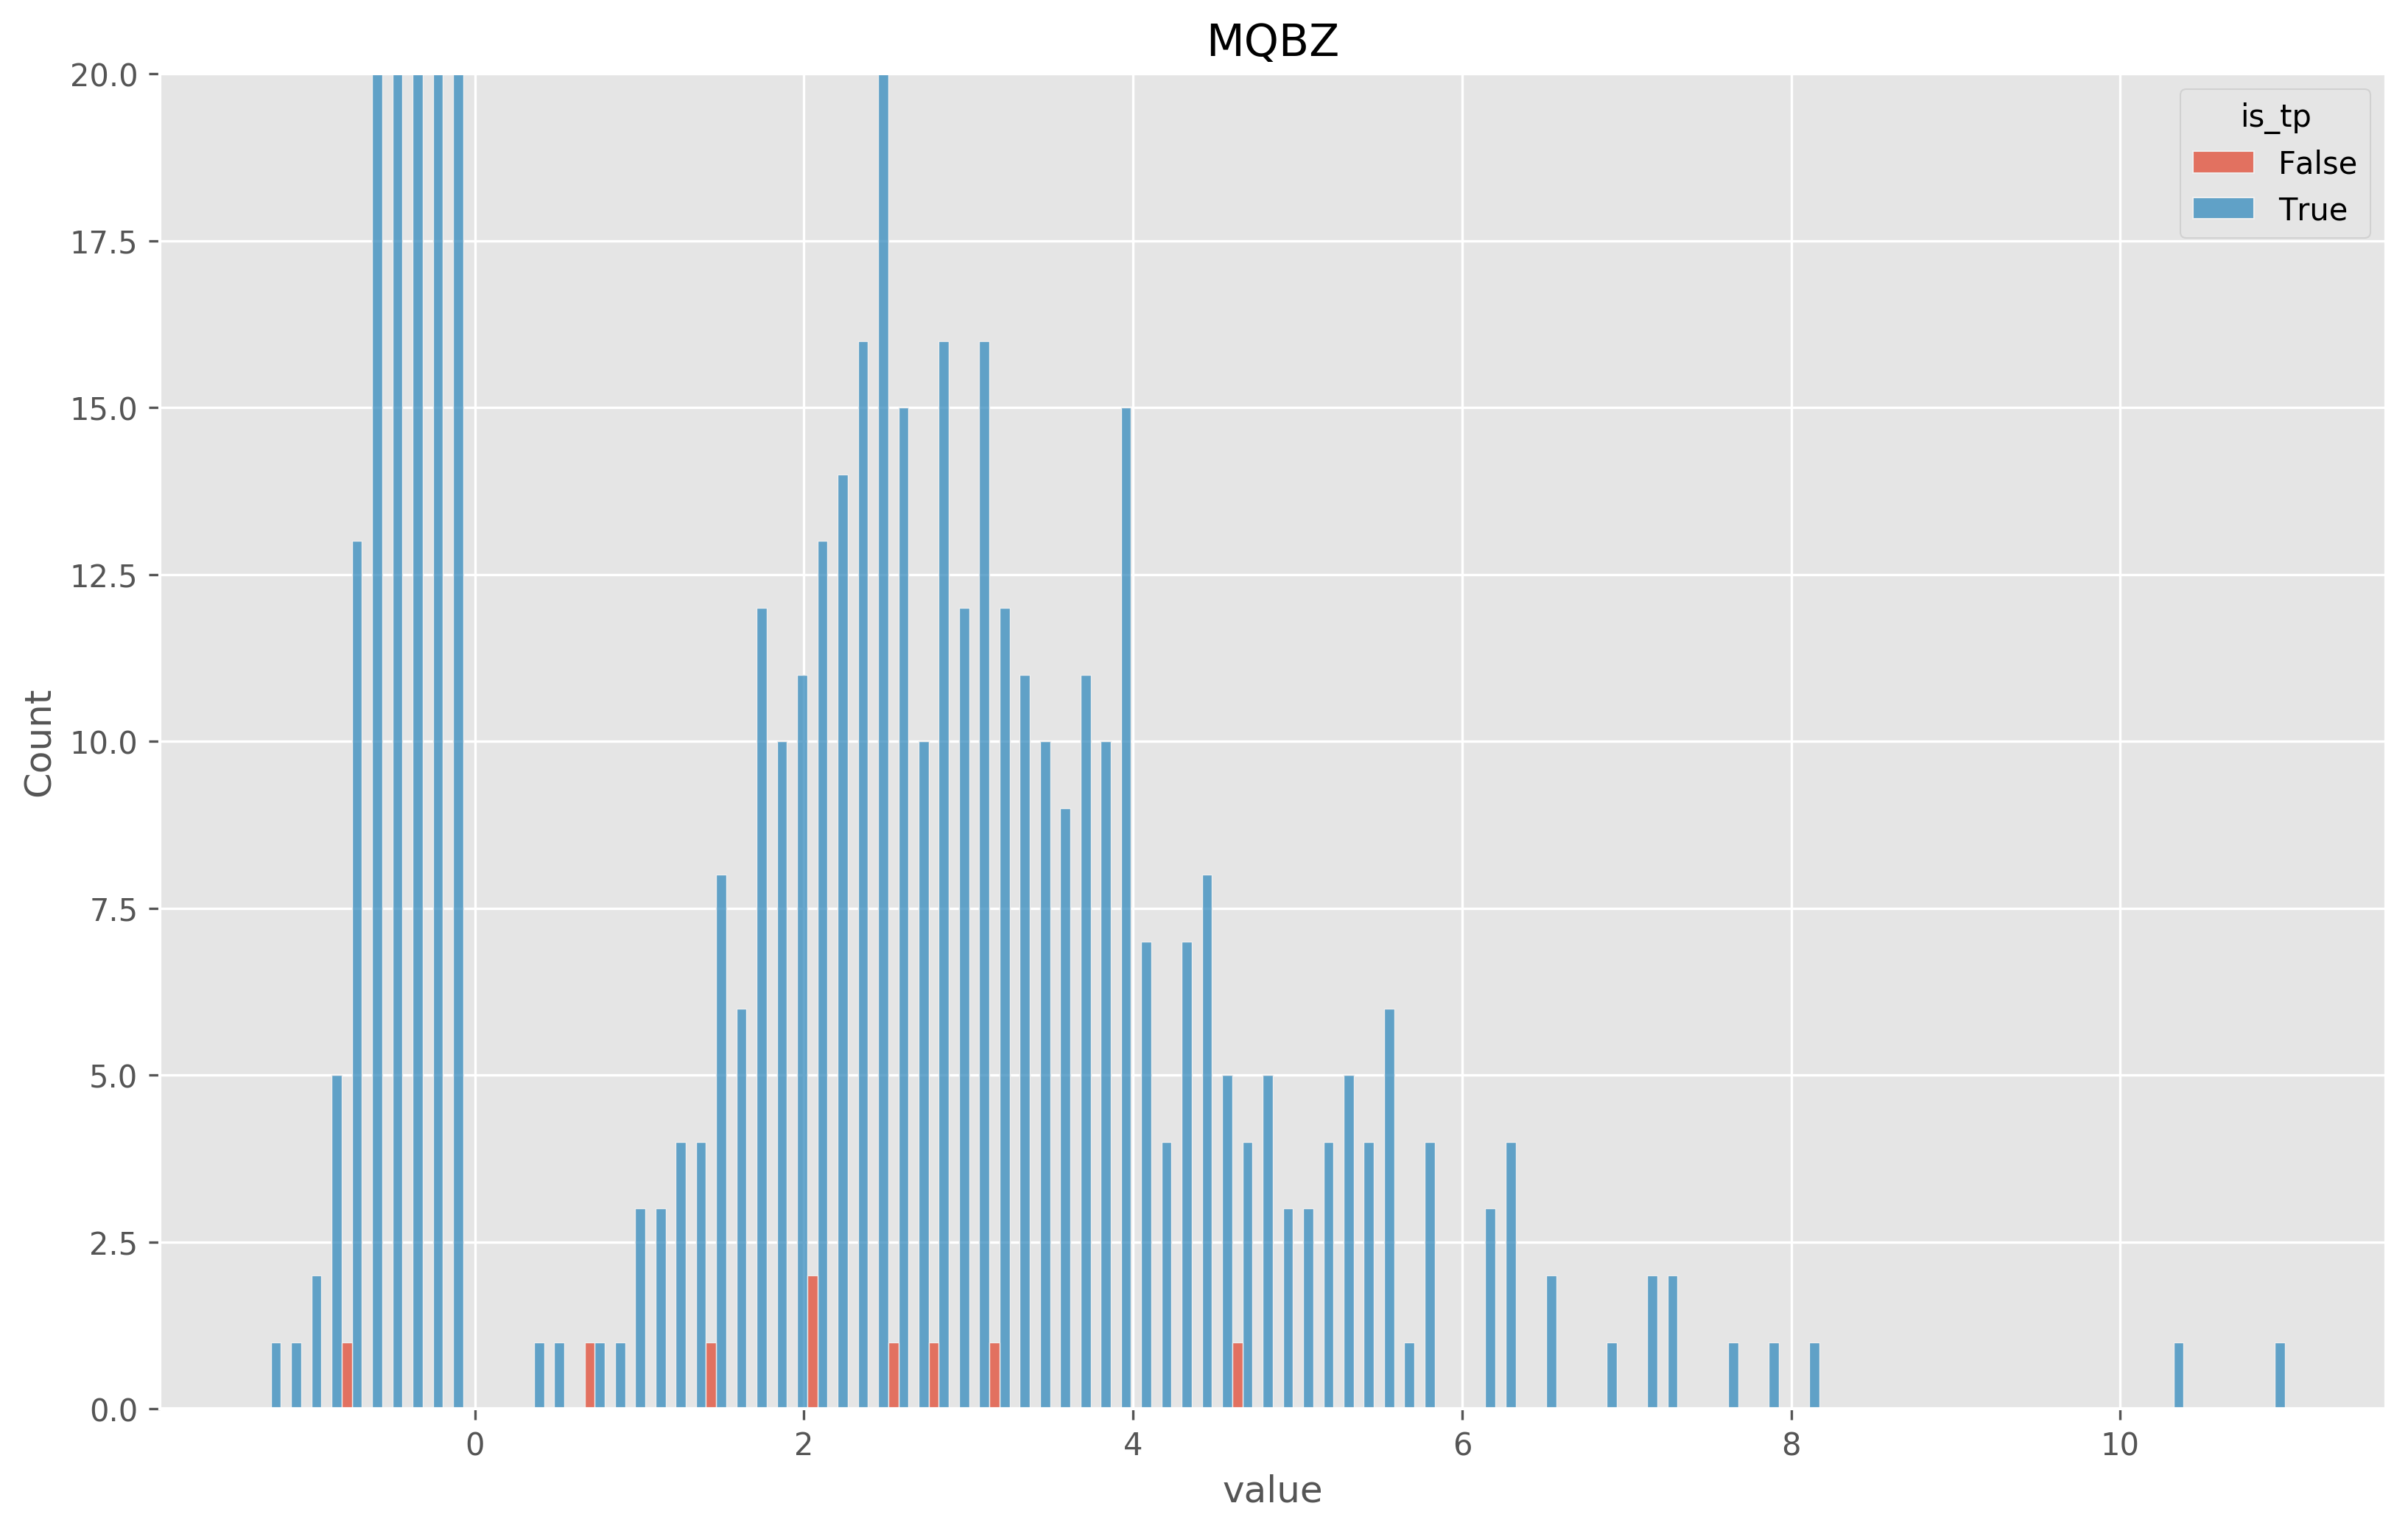

In [634]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=data, x=y, hue=x, ax=ax, multiple="dodge", bins=100)
# sns.histplot(data=data, x=y, hue=x, ax=ax, multiple="dodge", stat="percent", common_norm=False)
# ax.set_xlim((0, 0.0005))
ax.set_ylim((0, 20))
# sns.violinplot(data=data, x=x, y=y, ax=ax)
ax.set_title(field)

In [683]:
f = "SGB"
vs = np.linspace(-0.7, -0.652, num=10)
xs = []
for v in vs:
    print(v)
#     print(df.query("field==@f and value<@v").groupby(["is_tp"]).count()["sample"])
    fps, tps = df.query("field==@f and value>@v").groupby(["is_tp"]).count()["sample"]
    p=fps/(fps+tps)
    xs.append(p)
    print(f"{fps} / {fps} + {tps} = {p}")


-0.7
22 / 22 + 8170 = 0.002685546875
-0.6946666666666667
22 / 22 + 8170 = 0.002685546875
-0.6893333333333334
5 / 5 + 213 = 0.022935779816513763
-0.6839999999999999
4 / 4 + 94 = 0.04081632653061224
-0.6786666666666666
3 / 3 + 53 = 0.05357142857142857
-0.6733333333333333
3 / 3 + 37 = 0.075
-0.668
1 / 1 + 22 = 0.043478260869565216
-0.6626666666666667
1 / 1 + 22 = 0.043478260869565216
-0.6573333333333333
1 / 1 + 12 = 0.07692307692307693
-0.652
1 / 1 + 12 = 0.07692307692307693


In [257]:
from sklearn.impute import SimpleImputer

In [264]:
y = np.array([int(c!="TP") for c in df["classification"]])

In [265]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [266]:
features = ["quality", "SCRF", "FRS", "SB", "FED", "HQFED", "MQ", "VDB", "RPBZ", "SCBZ", "BQBZ", "SGB"]
X = df[features].to_numpy()

In [267]:
# Create our imputer to replace missing values with the median e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp = imp.fit(X)
# Impute our data, then train
X_imp = imp.transform(X)

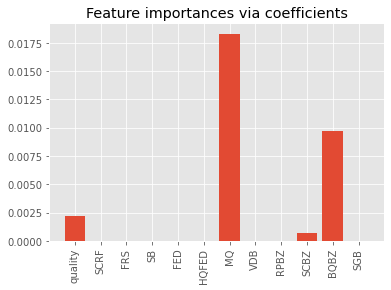

In [268]:
from sklearn.linear_model import LassoCV

lasso = LassoCV().fit(X_imp, y)
importance = np.abs(lasso.coef_)
feature_names = np.array(features)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.xticks(rotation=90)
plt.show()

In [231]:
X

array([[ 2.25421524e+02,  1.00000000e+00,  1.00000000e+00, ...,
                    nan,             nan, -6.93147182e-01],
       [ 2.28390930e+02,  1.09160305e+00,  9.82456140e-01, ...,
        -2.76572299e+00,  4.53979671e-01, -6.93147182e-01],
       [ 2.25416794e+02,  9.46564885e-01,  1.00000000e+00, ...,
                    nan,             nan, -6.93147182e-01],
       ...,
       [ 2.28385056e+02,  1.13333333e+00,  9.68750000e-01, ...,
         3.76914293e-01,  1.46942174e+00, -6.93110228e-01],
       [ 2.28367401e+02,  1.40000000e+00,  9.72972973e-01, ...,
         4.79784310e-01, -9.40271169e-02, -6.93139195e-01],
       [ 2.25416794e+02,  9.33333333e-01,  1.00000000e+00, ...,
                    nan,             nan, -6.93120003e-01]])

In [227]:
y

0       TP
1       TP
2       TP
3       TP
4       TP
        ..
9153    TP
9154    TP
9155    TP
9156    TP
9157    TP
Name: classification, Length: 8843, dtype: object

In [228]:
df

,sample,pos,classification,quality,FRS,HQDP,SB,SP,FED,HQFED,SCR,SCRF,MQSBZ,MQ,VDB,RPBZ,SCBZ,BQBZ,SGB,DP
0,mada_1-44,1977,TP,225.421524,1.000000,120,0.483333,0,1.190840,0.916031,131,1.000000,NaN,60.0,0.059813,NaN,NaN,NaN,-0.693147,156
1,mada_1-44,2532,TP,228.390930,0.982456,114,0.473214,0,1.244275,0.854962,143,1.091603,NaN,60.0,0.423704,0.021588,-2.765723,0.453980,-0.693147,163
2,mada_1-44,4013,TP,225.416794,1.000000,108,0.435185,0,1.129771,0.824427,124,0.946565,NaN,60.0,0.708110,NaN,NaN,NaN,-0.693147,148
3,mada_1-44,6112,TP,225.416794,1.000000,87,0.344828,0,0.908397,0.664122,111,0.847328,NaN,60.0,0.464688,NaN,NaN,NaN,-0.693147,119
4,mada_1-44,6124,TP,225.416794,1.000000,95,0.410526,0,1.068702,0.725191,110,0.839695,NaN,60.0,0.625217,NaN,NaN,NaN,-0.693147,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9153,mada_132,4382054,TP,210.416595,1.000000,16,0.375000,0,0.700000,0.533333,19,0.633333,NaN,60.0,0.033282,NaN,NaN,NaN,-0.689466,21
9154,mada_132,4382275,TP,225.416794,1.000000,25,0.440000,0,0.966667,0.833333,26,0.866667,NaN,60.0,0.838978,NaN,NaN,NaN,-0.692914,29
9155,mada_132,4388870,TP,228.385056,0.968750,32,0.290323,0,1.233333,1.033333,34,1.133333,NaN,60.0,0.346512,1.516980,0.376914,1.469422,-0.693110,37
9156,mada_132,4408254,TP,228.367401,0.972973,37,0.444444,0,1.400000,1.200000,42,1.400000,NaN,60.0,0.621464,0.562318,0.479784,-0.094027,-0.693139,42


In [251]:
df["MQ"]

0       60.0
1       60.0
2       60.0
3       60.0
4       60.0
        ... 
9153    60.0
9154    60.0
9155    60.0
9156    60.0
9157    60.0
Name: MQ, Length: 8843, dtype: float64